In [1]:
import pandas as pd
import numpy as np
#import sklearn
import datetime
import time
import matplotlib.pyplot as plt
#from statistics import mean
from scipy.optimize import curve_fit
import pytz
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, max_error
from scipy.stats import linregress
import csv
import math

In [2]:
Grades=np.zeros((10,3))
Students=['S01','S02','S03','S04','S05','S06','S07','S08','S09','S10']
with open('StudentGrades.txt') as f:
    lines = f.readlines()
    ist=0   # student index
    iex=0   # exam index
    for line in lines:
      # print(line)
      for st in Students: 
        if (st in line): # is text like S01 in line
          #print(line)
          i=int(line[-4:-1])  # last 3 chars 
          #print(ist,iex,st,i)
          Grades[ist,iex]=i
          ist=ist+1
          if(ist >9):
            ist=0
            iex=iex+1
            
print(Grades)
Grade2=Grades
for i in range(10): 
    Grade2[i,2]=Grades[i,2]/2   # scale the final grades
#print(Grade2)

[[ 78.  82. 182.]
 [ 82.  85. 180.]
 [ 77.  90. 188.]
 [ 75.  77. 149.]
 [ 67.  77. 157.]
 [ 71.  64. 175.]
 [ 64.  33. 110.]
 [ 92.  88. 184.]
 [ 80.  39. 126.]
 [ 89.  64. 116.]]


In [3]:
def read_data(filenl):

# filenl list of filenames, 
# return X data, X_time starting times, X_fr sampling Freq, X_mean average, X_std standard dev, X_var variance
  X_time=[]
  X_fr=[]
  X=[]
  X_mean=[]
  X_std=[]
  X_var=[]
  for i in filenl:
    D0 = np.loadtxt(i)
    X_time.append(D0[0])  # first  start time 
    X_fr.append(D0[1])    # sampling freq 
    data=D0[2:]           # data
    X.append(data)
    X_mean.append(np.mean(data))
    X_std.append(np.std(data))
    X_var.append(np.var(data))
    print(i,' mean ',np.mean(data),' std ',np.std(data),'var',np.var(data),' data len',len(data))

  for i in range(len(X_time)): 
    print('start time ',datetime.datetime.fromtimestamp(X_time[i],pytz.timezone("US/Central")))
  print('Frequency ',X_fr, 'in Hz')
 
  return X,X_time,X_fr,X_mean,X_std,X_var

In [4]:
def read_data_only(filenl):

# filenl list of filenames, 
# return X data, X_time starting times, X_fr sampling Freq

  X_time=[]
  X_fr=[]
  X=[]
  for i in filenl:
    D0 = np.loadtxt(i)
    X_time.append(D0[0])
    X_fr.append(D0[1])
    data=D0[2:]
    X.append(data)
    print(i,' mean ',np.mean(data),' std ',np.std(data),'var',np.var(data),' data len',len(data))

  for i in range(len(X_time)): 
    print('start time ',datetime.datetime.fromtimestamp(X_time[i],pytz.timezone("US/Central")))
  print('Frequency ',X_fr, 'in Hz')
 
  return X,X_time,X_fr

In [5]:
def read_data_IBI(HR):
# read time, and data 
# HR file names, 
# return X data, X_stime starting times, X_time sampling times, X_mean average, X_std standard dev 

  X_time=[]
  X_stime=[]
  X=[]
  X_mean=[]
  X_std=[]
  for i in HR:
    with open(i) as file:
      line = file.readline()
      fields = line.split(',')
      X_stime.append(float(fields[0]))   # from first line get the starting time
    D0 = np.loadtxt(i,delimiter=',',skiprows=1)   # skip the first line
    X_time.append(D0[:,0])   # first collum time
#    X_fr.append(D0[1])  # no freq
    data=D0[:,1]
    X.append(data)    # second collumn  data 
    md=np.mean(data)
    sd=np.std(data)
    X_mean.append(md)
    X_std.append(sd)
    print(i,' mean ',md,' std ',sd,' data len',len(data),'last time',D0[-1,0])

  for i in range(len(X_stime)): 
    print('start time ',datetime.datetime.fromtimestamp(X_stime[i],pytz.timezone("US/Central")))

 
  return X,X_time,X_stime,X_mean,X_std

In [6]:
def smooth_data(X_in,X_fr,atime):
    
#  X_in input data, atime aver time in sec, X_fr sampling Frew,  
# return  X_smoo smooth data, X_time time steps,

  X_smoo=[]  # smooth HR
  X_time=[]
  for k in range(10):
     window=int(atime*X_fr[k])   # 2 min aver, points 120s*sampling
     midw=int(window/2)
     aver0=[]
     xa=[]
     for i in range(0,len(X_in[k]),window):  # 2 min steps, sampling X_fr Hz
       xa.append((i+midw)/X_fr[k]/3600)
       aver0.append(np.mean(X_in[k][i:i+window]))  # 2 min average
      
     X_smoo.append(aver0)
     X_time.append(xa)
    
  return X_smoo,X_time

In [7]:
def aver_data(X_in,X_fr,time0,time1):
    
#  X_in input data, time0 start time in sec, time1 end time, X_fr sampling Freq,  
# return  X_aver average, X_std standard dev and X_var variance

  X_aver=[]  # average of X_in
  X_std=[]
  X_var=[]
  for k in range(len(X_fr)):
     i0=int(time0*X_fr[k]) 
     i1=int(time1*X_fr[k]) 
     X_aver.append(np.mean(X_in[k][i0:i1]))  # time0 to time1 average
     X_std.append(np.std(X_in[k][i0:i1]))
     X_var.append(np.var(X_in[k][i0:i1]))
        
  return X_aver,X_std,X_var

In [8]:
def aver_data_IBI(X_in,X_time,time0,time1):
    
# averaging for IBI 
#  X_in input data, time0 start time in sec, time1 end time, X_time sampling time, NOT regular 
# return  X_aver average and X_std, standard dev

  X_aver=[]  # average of X_in
  X_std=[]
  for k in range(10):
#    print(k,X_time[k][0])
    aver=0.0
    for i in range(len(X_in[k])): 
      if((X_time[k][i] > time0)and(X_time[k][i] < time1)): 
        if i == len(X_in[k])-1:
            dt = 0
        else:
            dt=X_time[k][i+1]-X_time[k][i] # use the time intervall to weight the values
            aver=aver+dt*X_in[k][i]
    aver=aver/(time1-time0)
    X_aver.append(aver)  # 2 min average
    sqd=0.0
    for i in range(len(X_in[k])):
        if((X_time[k][i] > time0)and(X_time[k][i] < time1)): 
            if i == len(X_in[k])-1:
                dt=0
            else:
                dt=X_time[k][i+1]-X_time[k][i] # use the time intervall to weight the values
                sqd=sqd+dt*(X_in[k][i]-aver)**2 #sqd square data
                #print(dt,i)
    sqd = sqd/(time1-time0)
    #print(sqd)
    #print(dt)
    X_std.append(math.sqrt(sqd))
  return X_aver, X_std

In [9]:
#code found: https://www.geeksforgeeks.org/how-to-convert-datetime-to-unix-timestamp-in-python/

exam_time_M1 = datetime.datetime(2018,10,13,17,0) #start klo 09:00 CT -> used klo 17:00 for correct unix time
print('exam time =>', exam_time_M1)
unix_M1 = time.mktime(exam_time_M1.timetuple())
print('unix timestamp =>',unix_M1)

exam_time_M2 = datetime.datetime(2018,11,10,17,0) #start klo 09:00 CT -> used klo 17:00 for correct unix time
print('exam time =>', exam_time_M2)
unix_M2 = time.mktime(exam_time_M2.timetuple())
print('unix timestamp =>',unix_M2)

exam_time_F = datetime.datetime(2018,12,5,18,45) #start klo 10:45 CT -> used klo 18:45 for correct unix time
print('exam time =>', exam_time_F)
unix_F = time.mktime(exam_time_F.timetuple())
print('unix timestamp =>',unix_F)

exam time => 2018-10-13 17:00:00
unix timestamp => 1539439200.0
exam time => 2018-11-10 17:00:00
unix timestamp => 1541862000.0
exam time => 2018-12-05 18:45:00
unix timestamp => 1544028300.0


In [10]:
#testi, että unix aika antaa oikean ajan US CT:ssä
print(unix_M1, unix_M2, unix_F)
print('start time M1_HR',datetime.datetime.fromtimestamp(unix_M1,pytz.timezone("US/Central")))
print('start time M2_HR',datetime.datetime.fromtimestamp(unix_M2,pytz.timezone("US/Central")))
print('start time F_HR',datetime.datetime.fromtimestamp(unix_F,pytz.timezone("US/Central")))

1539439200.0 1541862000.0 1544028300.0
start time M1_HR 2018-10-13 09:00:00-05:00
start time M2_HR 2018-11-10 09:00:00-06:00
start time F_HR 2018-12-05 10:45:00-06:00


In [11]:
EX='Midterm 1/'  # Exam 
PARAM='HR' # parameter
HR=["Data/S1/"+EX+PARAM+".csv","Data/S2/"+EX+PARAM+".csv","Data/S3/"+EX+PARAM+".csv",
    "Data/S4/"+EX+PARAM+".csv","Data/S5/"+EX+PARAM+".csv","Data/S6/"+EX+PARAM+".csv",
     "Data/S7/"+EX+PARAM+".csv","Data/S8/"+EX+PARAM+".csv","Data/S9/"+EX+PARAM+".csv",
     "Data/S10/"+EX+PARAM+".csv"]

M1_HR,M1_HR_time,M1_HR_fr,M1_HR_mean,M1_HR_std,M1_HR_var = read_data(HR)  # return data, time, fr, mean, std

for i in range(10):
    t0 = 0
    t1 = unix_M1-M1_HR_time[i]
    M1_HR_mean_bf, M1_HR_std_bf, M1_HR_var_bf = aver_data(M1_HR,M1_HR_fr,t0,t1) # HR before M1 exam
    t2 = t1 + 5400
    M1_HR_mean_ex, M1_HR_std_ex, M1_HR_var_ex = aver_data(M1_HR,M1_HR_fr,t1,t2) # HR during M1 exam
    t3 = int(len(M1_HR[i]))
    M1_HR_mean_af, M1_HR_std_af, M1_HR_var_af = aver_data(M1_HR,M1_HR_fr,t2,t3) # HR after M1 exam
print('Heart rate BEFORE ',EX,' exam \n', M1_HR_mean_bf, np.mean(M1_HR_mean_bf))
print('Heart rate std BEFORE ',EX,' exam \n', M1_HR_std_bf, np.mean(M1_HR_std_bf))
print('Heart rate var BEFORE ',EX,' exam \n', M1_HR_var_bf, np.mean(M1_HR_var_bf))
print()
print('Heart rate DURING ',EX,' exam \n', M1_HR_mean_ex, np.mean(M1_HR_mean_ex))
print('Heart rate std DURING ',EX,' exam \n', M1_HR_std_ex, np.mean(M1_HR_std_ex))
print('Heart rate var DURING ',EX,' exam \n', M1_HR_var_ex, np.mean(M1_HR_var_ex))
print()
print('Heart rate AFTER ',EX,' exam \n', M1_HR_mean_af, np.mean(M1_HR_mean_af))
print('Heart rate std AFTER ',EX,' exam \n', M1_HR_std_af, np.mean(M1_HR_std_af))
print('Heart rate var AFTER ',EX,' exam \n', M1_HR_var_af, np.mean(M1_HR_var_af))

Data/S1/Midterm 1/HR.csv  mean  103.11374697824334  std  26.303593037249865 var 691.8790066692595  data len 11169
Data/S2/Midterm 1/HR.csv  mean  111.4595198329854  std  32.890043116857264 var 1081.7549362287298  data len 11975
Data/S3/Midterm 1/HR.csv  mean  105.68317954601326  std  29.026403583519105 var 842.5321049933308  data len 12203
Data/S4/Midterm 1/HR.csv  mean  110.63580280725779  std  29.929565843591867 var 895.778911585901  data len 11684
Data/S5/Midterm 1/HR.csv  mean  108.25669029352902  std  28.102857151866452 var 789.7705800982114  data len 11992
Data/S6/Midterm 1/HR.csv  mean  107.04559314429288  std  23.509342293626695 var 552.6891750789049  data len 11144
Data/S7/Midterm 1/HR.csv  mean  112.38305640859868  std  28.0617193113119 var 787.4600907068552  data len 12374
Data/S8/Midterm 1/HR.csv  mean  113.6724231733358  std  29.516010881741884 var 871.1948983711053  data len 10771
Data/S9/Midterm 1/HR.csv  mean  108.35460227272728  std  27.41990611445267 var 751.851251325

In [12]:
EX='Midterm 2/'  # Exam 
PARAM='HR' # parameter
HR=["Data/S1/"+EX+PARAM+".csv","Data/S2/"+EX+PARAM+".csv","Data/S3/"+EX+PARAM+".csv",
    "Data/S4/"+EX+PARAM+".csv","Data/S5/"+EX+PARAM+".csv","Data/S6/"+EX+PARAM+".csv",
     "Data/S7/"+EX+PARAM+".csv","Data/S8/"+EX+PARAM+".csv","Data/S9/"+EX+PARAM+".csv",
     "Data/S10/"+EX+PARAM+".csv"]

M2_HR,M2_HR_time,M2_HR_fr,M2_HR_mean,M2_HR_std,M2_HR_var = read_data(HR)  # return data, time, fr, mean, std

for i in range(10):
    t0 = 0
    t1 = unix_M2-M2_HR_time[i]
    M2_HR_mean_bf, M2_HR_std_bf, M2_HR_var_bf = aver_data(M2_HR,M2_HR_fr,t0,t1) # HR before M2 exam
    t2 = t1 + 5400
    M2_HR_mean_ex, M2_HR_std_ex, M2_HR_var_ex = aver_data(M2_HR,M2_HR_fr,t1,t2) # HR during M2 exam
    t3 = int(len(M2_HR[i]))
    M2_HR_mean_af, M2_HR_std_af, M2_HR_var_af = aver_data(M2_HR,M2_HR_fr,t2,t3) # HR during M2 exam
print('Heart rate BEFORE ',EX,' exam \n', M2_HR_mean_bf, np.mean(M2_HR_mean_bf))
print('Heart rate std BEFORE ',EX,' exam \n', M2_HR_std_bf, np.mean(M2_HR_std_bf))
print('Heart rate var BEFORE ',EX,' exam \n', M2_HR_var_bf, np.mean(M2_HR_var_bf))
print()
print('Heart rate DURING ',EX,' exam \n', M2_HR_mean_ex, np.mean(M2_HR_mean_ex))
print('Heart rate std DURING ',EX,' exam \n', M2_HR_std_ex, np.mean(M2_HR_std_ex))
print('Heart rate var DURING ',EX,' exam \n', M2_HR_var_ex, np.mean(M2_HR_var_ex))
print()
print('Heart rate AFTER ',EX,' exam \n', M2_HR_mean_af, np.mean(M2_HR_mean_af))
print('Heart rate std AFTER ',EX,' exam \n', M2_HR_std_af, np.mean(M2_HR_std_af))
print('Heart rate var AFTER ',EX,' exam \n', M2_HR_var_af, np.mean(M2_HR_var_af))

Data/S1/Midterm 2/HR.csv  mean  110.99448009346635  std  22.612554631012742 var 511.32762694053577  data len 11127
Data/S2/Midterm 2/HR.csv  mean  106.65148900900903  std  22.16058552196999 var 491.0915506765459  data len 13875
Data/S3/Midterm 2/HR.csv  mean  97.41239472398631  std  21.681662977457073 var 470.0945094680327  data len 10235
Data/S4/Midterm 2/HR.csv  mean  94.80819846073378  std  32.19351258992868 var 1036.4222528778964  data len 13383
Data/S5/Midterm 2/HR.csv  mean  113.31848255184475  std  18.522482824849455 var 343.08236999684306  data len 12007
Data/S6/Midterm 2/HR.csv  mean  104.69295183696495  std  27.583228405114596 var 760.8344892487206  data len 14181
Data/S7/Midterm 2/HR.csv  mean  98.94739726027399  std  22.856584975677503 var 522.4234767503665  data len 10804
Data/S8/Midterm 2/HR.csv  mean  102.70056370578779  std  21.20443638300489 var 449.6281223209014  data len 9952
Data/S9/Midterm 2/HR.csv  mean  103.10692964095958  std  22.22642606432759 var 494.014015593

In [13]:
EX='Final/'  # Exam 
PARAM='HR' # parameter
HR=["Data/S1/"+EX+PARAM+".csv","Data/S2/"+EX+PARAM+".csv","Data/S3/"+EX+PARAM+".csv",
    "Data/S4/"+EX+PARAM+".csv","Data/S5/"+EX+PARAM+".csv","Data/S6/"+EX+PARAM+".csv",
     "Data/S7/"+EX+PARAM+".csv","Data/S8/"+EX+PARAM+".csv","Data/S9/"+EX+PARAM+".csv",
     "Data/S10/"+EX+PARAM+".csv"]

F_HR,F_HR_time,F_HR_fr,F_HR_mean,F_HR_std,F_HR_var = read_data(HR)  # return data, time, fr, mean, std
#print(F_HR_fr,F_HR_mean)

for i in range(10):
    t0 = 0
    t1 = unix_F-F_HR_time[i]
    F_HR_mean_bf, F_HR_std_bf,F_HR_var_bf = aver_data(F_HR,F_HR_fr,t0,t1) # HR before F exam
    t2 = t1 + 5400*2
    F_HR_mean_ex, F_HR_std_ex,F_HR_var_ex = aver_data(F_HR,F_HR_fr,t1,t2) # HR during F exam
    t3 = int(len(F_HR[i]))
    F_HR_mean_af, F_HR_std_af,F_HR_var_af = aver_data(F_HR,F_HR_fr,t2,t3) # HR during F exam
print('Heart rate BEFORE ',EX,' exam \n', F_HR_mean_bf, np.mean(F_HR_mean_bf))
print('Heart rate std BEFORE ',EX,' exam \n', F_HR_std_bf, np.mean(F_HR_std_bf))
print('Heart rate var BEFORE ',EX,' exam \n', F_HR_var_bf, np.mean(F_HR_var_bf))
print()
print('Heart rate DURING ',EX,' exam \n', F_HR_mean_ex, np.mean(F_HR_mean_ex))
print('Heart rate std DURING ',EX,' exam \n', F_HR_std_ex, np.mean(F_HR_std_ex))
print('Heart rate var DURING ',EX,' exam \n', F_HR_var_ex, np.mean(F_HR_var_ex))
print()
print('Heart rate AFTER ',EX,' exam \n', F_HR_mean_af, np.mean(F_HR_mean_af))
print('Heart rate std AFTER ',EX,' exam \n', F_HR_std_af, np.mean(F_HR_std_af))
print('Heart rate var AFTER ',EX,' exam \n', F_HR_var_af, np.mean(F_HR_var_af))

Data/S1/Final/HR.csv  mean  106.1215089579681  std  18.716388526647776 var 350.30319948043245  data len 23387
Data/S2/Final/HR.csv  mean  119.90186559797843  std  21.711149835840526 var 471.3740271943181  data len 25327
Data/S3/Final/HR.csv  mean  104.51009879125988  std  21.949623855617016 var 481.78598740307154  data len 25812
Data/S4/Final/HR.csv  mean  92.67081976488339  std  25.289342531685858 var 639.5508456849353  data len 15907
Data/S5/Final/HR.csv  mean  95.4044402887139  std  14.98894827296992 var 224.6685703297679  data len 15240
Data/S6/Final/HR.csv  mean  103.86028521244565  std  31.56101520597845 var 996.0976808320029  data len 23912
Data/S7/Final/HR.csv  mean  101.22818371607516  std  24.397153228851064 var 595.2210856720379  data len 19639
Data/S8/Final/HR.csv  mean  102.17150612176441  std  26.968094632050843 var 727.2781280832494  data len 17887
Data/S9/Final/HR.csv  mean  86.7034457984081  std  14.052562575128789 var 197.47451492791026  data len 14197
Data/S10/Final/

In [14]:
EX='Midterm 1/'  # Exam 
PARAM='IBI' # parameter
HR=["Data/S1/"+EX+PARAM+".csv","Data/S2/"+EX+PARAM+".csv","Data/S3/"+EX+PARAM+".csv",
    "Data/S4/"+EX+PARAM+".csv","Data/S5/"+EX+PARAM+".csv","Data/S6/"+EX+PARAM+".csv",
     "Data/S7/"+EX+PARAM+".csv","Data/S8/"+EX+PARAM+".csv","Data/S9/"+EX+PARAM+".csv",
     "Data/S10/"+EX+PARAM+".csv"]

M1_IB,M1_IB_stime,M1_IB_time,M1_IB_mean,M1_IB_std = read_data_IBI(HR)  # return data, time, start time, mean, std
#print(F_IB_stime[-1][:])

for i in range(10):
    t0 = 0
    t1 = unix_M1-M1_IB_time[i]
    M1_IB_mean_bf, M1_IB_std_bf = aver_data_IBI(M1_IB,M1_IB_stime,t0,t1) # IBI at M1 exam
    t2 = t1 + 5400
    M1_IB_mean_ex, M1_IB_std_ex = aver_data_IBI(M1_IB,M1_IB_stime,t1,t2) # IBI during M1 exam
    #M1_IB_std_ex = std_data_IBI(M1_IB_mean_ex)
    t3 = M1_IB_stime[i][-1]
    M1_IB_mean_af, M1_IB_std_af = aver_data_IBI(M1_IB,M1_IB_stime,t2,t3) # IBI during M1 exam
    #M1_IB_std_af = std_data_IBI(M1_IB_mean_af)
print('IBI BEFORE ',EX,' exam \n', M1_IB_mean_bf, np.mean(M1_IB_mean_bf))
print('IBI std BEFORE ',EX,' exam \n', M1_IB_std_bf, np.mean(M1_IB_std_bf))
print()
print('IBI DURING ',EX,' exam \n', M1_IB_mean_ex, np.mean(M1_IB_mean_ex))
print('IBI std DURING ',EX,' exam \n', M1_IB_std_ex, np.mean(M1_IB_std_ex))
print()
print('IBI AFTER ',EX,' exam \n', M1_IB_mean_af, np.mean(M1_IB_mean_af))
print('IBI std AFTER ',EX,' exam \n', M1_IB_std_af, np.mean(M1_IB_std_af))

Data/S1/Midterm 1/IBI.csv  mean  0.50731484  std  0.12070859338448554  data len 300 last time 10703.708706
Data/S2/Midterm 1/IBI.csv  mean  0.5332014416666667  std  0.1374720862132016  data len 600 last time 11558.591589
Data/S3/Midterm 1/IBI.csv  mean  0.5545175270833334  std  0.13996055951016798  data len 480 last time 11704.645149
Data/S4/Midterm 1/IBI.csv  mean  0.4822393238095238  std  0.130542741434622  data len 210 last time 10877.357278
Data/S5/Midterm 1/IBI.csv  mean  0.5082263541666666  std  0.12931738427364947  data len 240 last time 11283.71963
Data/S6/Midterm 1/IBI.csv  mean  0.5294512645833334  std  0.11777623196533718  data len 480 last time 10395.882115
Data/S7/Midterm 1/IBI.csv  mean  0.5017156125000001  std  0.1728425752795609  data len 240 last time 11312.111556
Data/S8/Midterm 1/IBI.csv  mean  0.43379957619047627  std  0.09400258108698731  data len 210 last time 10681.598318
Data/S9/Midterm 1/IBI.csv  mean  0.49878582916666664  std  0.15519062578428067  data len 240

In [15]:
EX='Midterm 2/'  # Exam 
PARAM='IBI' # parameter
HR=["Data/S1/"+EX+PARAM+".csv","Data/S2/"+EX+PARAM+".csv","Data/S3/"+EX+PARAM+".csv",
    "Data/S4/"+EX+PARAM+".csv","Data/S5/"+EX+PARAM+".csv","Data/S6/"+EX+PARAM+".csv",
     "Data/S7/"+EX+PARAM+".csv","Data/S8/"+EX+PARAM+".csv","Data/S9/"+EX+PARAM+".csv",
     "Data/S10/"+EX+PARAM+".csv"]

M2_IB,M2_IB_stime,M2_IB_time,M2_IB_mean,M2_IB_std = read_data_IBI(HR)  # return data, time, samp time, mean, std

for i in range(10):
    t0 = 0
    t1 = unix_M2-M2_IB_time[i]
    M2_IB_mean_bf, M2_IB_std_bf = aver_data_IBI(M2_IB,M2_IB_stime,t0,t1) # IBI at M2 exam
    t2 = t1 + 5400
    M2_IB_mean_ex, M2_IB_std_ex = aver_data_IBI(M2_IB,M2_IB_stime,t1,t2) # IBI during M2 exam
    t3 = M2_IB_stime[i][-1]
    M2_IB_mean_af, M2_IB_std_af = aver_data_IBI(M2_IB,M2_IB_stime,t2,t3) # IBI during M2 exam
print('IBI BEFORE ',EX,' exam \n', M2_IB_mean_bf, np.mean(M2_IB_mean_bf))
print('IBI std BEFORE ',EX,' exam \n', M2_IB_std_bf, np.mean(M2_IB_std_bf))
print()
print('IBI DURING ',EX,' exam \n', M2_IB_mean_ex, np.mean(M2_IB_mean_ex))
print('IBI std DURING ',EX,' exam \n', M2_IB_std_ex, np.mean(M2_IB_std_ex))
print()
print('IBI AFTER ',EX,' exam \n', M2_IB_mean_af, np.mean(M2_IB_mean_af))
print('IBI std AFTER ',EX,' exam \n', M2_IB_std_af, np.mean(M2_IB_std_af))

Data/S1/Midterm 2/IBI.csv  mean  0.5153094224806202  std  0.056756686969939324  data len 1290 last time 10333.394877
Data/S2/Midterm 2/IBI.csv  mean  0.6120491494307401  std  0.08708981897995348  data len 2108 last time 13607.685381
Data/S3/Midterm 2/IBI.csv  mean  0.6360584862745098  std  0.0811460735364512  data len 510 last time 9104.651137
Data/S4/Midterm 2/IBI.csv  mean  0.6281884311111111  std  0.20377514447523531  data len 450 last time 13187.916169
Data/S5/Midterm 2/IBI.csv  mean  0.5469686625976562  std  0.04286646504367661  data len 4096 last time 9007.787327
Data/S6/Midterm 2/IBI.csv  mean  0.7351898435897435  std  0.13837526824881194  data len 1560 last time 13188.947466
Data/S7/Midterm 2/IBI.csv  mean  0.6560567571428573  std  0.16163711421235585  data len 210 last time 10612.3764
Data/S8/Midterm 2/IBI.csv  mean  0.6273724666666667  std  0.1404526207444426  data len 60 last time 8979.114139
Data/S9/Midterm 2/IBI.csv  mean  0.6682886537037037  std  0.0809539680394592  data 

In [16]:
EX='Final/'  # Exam 
PARAM='IBI' # parameter
HR=["Data/S1/"+EX+PARAM+".csv","Data/S2/"+EX+PARAM+".csv","Data/S3/"+EX+PARAM+".csv",
    "Data/S4/"+EX+PARAM+".csv","Data/S5/"+EX+PARAM+".csv","Data/S6/"+EX+PARAM+".csv",
     "Data/S7/"+EX+PARAM+".csv","Data/S8/"+EX+PARAM+".csv","Data/S9/"+EX+PARAM+".csv",
     "Data/S10/"+EX+PARAM+".csv"]

F_IB,F_IB_stime,F_IB_time,F_IB_mean,F_IB_std = read_data_IBI(HR)  # return data, start time, samp time, mean, std

for i in range(10):
    t0 = 0
    t1 = unix_F-F_IB_time[i]
    F_IB_mean_bf, F_IB_std_bf = aver_data_IBI(F_IB,F_IB_stime,t0,t1) # IBI at M2 exam
    t2 = t1 + 5400*2
    F_IB_mean_ex, F_IB_std_ex = aver_data_IBI(F_IB,F_IB_stime,t1,t2) # IBI during M2 exam
    t3 = F_IB_stime[i][-1]
    F_IB_mean_af, F_IB_std_af = aver_data_IBI(F_IB,F_IB_stime,t2,t3) # IBI during M2 exam
print('IBI BEFORE ',EX,' exam \n', F_IB_mean_bf, np.mean(F_IB_mean_bf))
print('IBI std BEFORE ',EX,' exam \n', F_IB_std_bf, np.mean(F_IB_std_bf))
print()
print('IBI DURING ',EX,' exam \n', F_IB_mean_ex, np.mean(F_IB_mean_ex))
print('IBI std DURING ',EX,' exam \n', F_IB_std_ex, np.mean(F_IB_std_ex))
print()
print('IBI AFTER ',EX,' exam \n', F_IB_mean_af, np.mean(F_IB_mean_af))
print('IBI std AFTER ',EX,' exam \n', F_IB_std_af, np.mean(F_IB_std_af))

Data/S1/Final/IBI.csv  mean  0.5644068533210332  std  0.08009846197560622  data len 2168 last time 20794.217468
Data/S2/Final/IBI.csv  mean  0.5658900173768151  std  0.05599926975560988  data len 8402 last time 19120.047083
Data/S3/Final/IBI.csv  mean  0.6643098796296296  std  0.07290107468153366  data len 1080 last time 13395.0194
Data/S4/Final/IBI.csv  mean  0.8039802136054421  std  0.10572311809309165  data len 1470 last time 13718.893599
Data/S5/Final/IBI.csv  mean  0.6118746668529905  std  0.08064057087989489  data len 3578 last time 13575.012011
Data/S6/Final/IBI.csv  mean  0.8118946023497515  std  0.12951367125975496  data len 4426 last time 23488.528297
Data/S7/Final/IBI.csv  mean  0.6785176935185185  std  0.1327007595261259  data len 1080 last time 13483.773458
Data/S8/Final/IBI.csv  mean  0.6062777125  std  0.11429403236709186  data len 240 last time 13067.207518
Data/S9/Final/IBI.csv  mean  0.7295776123427202  std  0.09338488870197832  data len 3338 last time 13661.85974
Dat

In [17]:
EX='Midterm 1/'  # Exam 
PARAM='TEMP' # parameter
TE=["Data/S1/"+EX+PARAM+".csv","Data/S2/"+EX+PARAM+".csv","Data/S3/"+EX+PARAM+".csv",
    "Data/S4/"+EX+PARAM+".csv","Data/S5/"+EX+PARAM+".csv","Data/S6/"+EX+PARAM+".csv",
     "Data/S7/"+EX+PARAM+".csv","Data/S8/"+EX+PARAM+".csv","Data/S9/"+EX+PARAM+".csv",
     "Data/S10/"+EX+PARAM+".csv"]

M1_TE,M1_TE_time,M1_TE_fr = read_data_only(TE) # return data, time, fr
#M1_TE,M1_TE_time,M1_TE_fr,M1_TE_mean,M1_TE_std,M1_TE_var = read_data(TE)

for i in range(10):
    t0 = 0
    t1 = unix_M1-M1_TE_time[i]
    M1_TE_mean_bf, M1_TE_std_bf,M1_TE_var_bf = aver_data(M1_TE,M1_TE_fr,t0,t1) # TEMP before M1 exam
    t2 = t1 + 5400
    M1_TE_mean_ex, M1_TE_std_ex,M1_TE_var_ex = aver_data(M1_TE,M1_TE_fr,t1,t2) # TEMP during M1 exam
    t3 = int(len(M1_TE[i]))/4
    M1_TE_mean_af, M1_TE_std_af,M1_TE_var_af = aver_data(M1_TE,M1_TE_fr,t2,t3) # TEMP during M1 exam
print('Temp BEFORE ',EX,' exam \n', M1_TE_mean_bf, np.mean(M1_TE_mean_bf))
print('Temp std BEFORE ',EX,' exam \n', M1_TE_std_bf, np.mean(M1_TE_std_bf))
print('Temp var BEFORE ',EX,' exam \n', M1_TE_var_bf, np.mean(M1_TE_var_bf))
print()
print('Temp DURING ',EX,' exam \n', M1_TE_mean_ex, np.mean(M1_TE_mean_ex))
print('Temp std DURING ',EX,' exam \n', M1_TE_std_ex, np.mean(M1_TE_std_ex))
print('Temp var DURING ',EX,' exam \n', M1_TE_var_ex, np.mean(M1_TE_var_ex))
print()
print('Temp AFTER ',EX,' exam \n', M1_TE_mean_af, np.mean(M1_TE_mean_af))
print('Temp std AFTER ',EX,' exam \n', M1_TE_std_af, np.mean(M1_TE_std_af))
print('Temp var AFTER ',EX,' exam \n', M1_TE_var_af, np.mean(M1_TE_var_af))

Data/S1/Midterm 1/TEMP.csv  mean  26.418378958668814  std  2.2147262871500164 var 4.905012526993297  data len 44712
Data/S2/Midterm 1/TEMP.csv  mean  28.694811415220293  std  4.5965341435325024 var 21.12812613266008  data len 47936
Data/S3/Midterm 1/TEMP.csv  mean  26.73012446773665  std  2.817966720962608 var 7.940936440452753  data len 48848
Data/S4/Midterm 1/TEMP.csv  mean  25.40508465879939  std  1.7933132326652192 var 3.2159723504521787  data len 46776
Data/S5/Midterm 1/TEMP.csv  mean  26.806748333333335  std  2.6166815230995453 var 6.847022193330556  data len 48000
Data/S6/Midterm 1/TEMP.csv  mean  27.983746413199427  std  3.700253797119448 var 13.691878163096892  data len 44608
Data/S7/Midterm 1/TEMP.csv  mean  25.533605233403325  std  1.733730264993442 var 3.0058206317542306  data len 49528
Data/S8/Midterm 1/TEMP.csv  mean  27.06935435992579  std  2.8429873152072 var 8.082576874429042  data len 43120
Data/S9/Midterm 1/TEMP.csv  mean  26.369618296529964  std  2.397676460556659 v

In [18]:
EX='Midterm 2/'  # Exam 
PARAM='TEMP' # parameter
TE=["Data/S1/"+EX+PARAM+".csv","Data/S2/"+EX+PARAM+".csv","Data/S3/"+EX+PARAM+".csv",
    "Data/S4/"+EX+PARAM+".csv","Data/S5/"+EX+PARAM+".csv","Data/S6/"+EX+PARAM+".csv",
     "Data/S7/"+EX+PARAM+".csv","Data/S8/"+EX+PARAM+".csv","Data/S9/"+EX+PARAM+".csv",
     "Data/S10/"+EX+PARAM+".csv"]

M2_TE,M2_TE_time,M2_TE_fr,M2_TE_mean,M2_TE_std,M2_TE_var = read_data(TE) # return data, time, fr, mean, std

for i in range(10):
    t0 = 0
    t1 = unix_M2-M2_TE_time[i]
    M2_TE_mean_bf, M2_TE_std_bf, M2_TE_var_bf = aver_data(M2_TE,M2_TE_fr,t0,t1) # HR before M1 exam
    t2 = t1 + 5400
    M2_TE_mean_ex, M2_TE_std_ex, M2_TE_var_ex = aver_data(M2_TE,M2_TE_fr,t1,t2) # HR during M1 exam
    t3 = int(len(M2_TE[i]))/4
    M2_TE_mean_af, M2_TE_std_af, M2_TE_var_af = aver_data(M2_TE,M2_TE_fr,t2,t3) # HR during M1 exam
print('Temp BEFORE ',EX,' exam \n', M2_TE_mean_bf, np.mean(M2_TE_mean_bf))
print('Temp std BEFORE ',EX,' exam \n', M2_TE_std_bf, np.mean(M2_TE_std_bf))
print('Temp var BEFORE ',EX,' exam \n', M2_TE_var_bf, np.mean(M2_TE_var_bf))
print()
print('Temp DURING ',EX,' exam \n', M2_TE_mean_ex, np.mean(M2_TE_mean_ex))
print('Temp std DURING ',EX,' exam \n', M2_TE_std_ex, np.mean(M2_TE_std_ex))
print('Temp var DURING ',EX,' exam \n', M2_TE_var_ex, np.mean(M2_TE_var_ex))
print()
print('Temp AFTER ',EX,' exam \n', M2_TE_mean_af, np.mean(M2_TE_mean_af))
print('Temp std AFTER ',EX,' exam \n', M2_TE_std_af, np.mean(M2_TE_std_af))
print('Temp var AFTER ',EX,' exam \n', M2_TE_var_af, np.mean(M2_TE_var_af))

Data/S1/Midterm 2/TEMP.csv  mean  27.129207974137923  std  4.940544325683721 var 24.40897823404561  data len 44544
Data/S2/Midterm 2/TEMP.csv  mean  27.873337654854506  std  5.622528210284471 var 31.61282347544469  data len 55536
Data/S3/Midterm 2/TEMP.csv  mean  28.074951190941036  std  4.610313073284431 var 21.254986633697335  data len 40976
Data/S4/Midterm 2/TEMP.csv  mean  26.209634109916365  std  4.067269266556374 var 16.542679286674026  data len 53568
Data/S5/Midterm 2/TEMP.csv  mean  28.219405792276966  std  5.331656521641286 var 28.426561264760057  data len 48064
Data/S6/Midterm 2/TEMP.csv  mean  26.925979563072588  std  5.634894410724948 var 31.75203502001926  data len 56760
Data/S7/Midterm 2/TEMP.csv  mean  24.881287220270018  std  3.2441598532586062 var 10.5245731534949  data len 43256
Data/S8/Midterm 2/TEMP.csv  mean  28.509378514056227  std  5.462431254132604 var 29.838155206124696  data len 39840
Data/S9/Midterm 2/TEMP.csv  mean  27.85581496379727  std  5.690793034859087 

In [19]:
EX='Final/'  # Exam 
PARAM='TEMP' # parameter
TE=["Data/S1/"+EX+PARAM+".csv","Data/S2/"+EX+PARAM+".csv","Data/S3/"+EX+PARAM+".csv",
    "Data/S4/"+EX+PARAM+".csv","Data/S5/"+EX+PARAM+".csv","Data/S6/"+EX+PARAM+".csv",
     "Data/S7/"+EX+PARAM+".csv","Data/S8/"+EX+PARAM+".csv","Data/S9/"+EX+PARAM+".csv",
     "Data/S10/"+EX+PARAM+".csv"]

F_TE,F_TE_time,F_TE_fr = read_data_only(TE) # return data, time, fr

for i in range(10):
    t0 = 0
    t1 = unix_F-F_TE_time[i]
    F_TE_mean_bf, F_TE_std_bf, F_TE_var_bf = aver_data(F_TE,F_TE_fr,t0,t1) # HR before M1 exam
    t2 = t1 + 5400*2
    F_TE_mean_ex, F_TE_std_ex, F_TE_var_ex = aver_data(F_TE,F_TE_fr,t1,t2) # HR during M1 exam
    t3 = int(len(F_TE[i]))/4
    F_TE_mean_af, F_TE_std_af, F_TE_var_af = aver_data(F_TE,F_TE_fr,t2,t3) # HR during M1 exam
print('Temp BEFORE ',EX,' exam \n', F_TE_mean_bf, np.mean(F_TE_mean_bf))
print('Temp std BEFORE ',EX,' exam \n', F_TE_std_bf, np.mean(F_TE_std_bf))
print('Temp var BEFORE ',EX,' exam \n', F_TE_var_bf, np.mean(F_TE_var_bf))
print()
print('Temp DURING ',EX,' exam \n', F_TE_mean_ex, np.mean(F_TE_mean_ex))
print('Temp std DURING ',EX,' exam \n', F_TE_std_ex, np.mean(F_TE_std_ex))
print('Temp var DURING ',EX,' exam \n', F_TE_var_ex, np.mean(F_TE_var_ex))
print()
print('Temp AFTER ',EX,' exam \n', F_TE_mean_af, np.mean(F_TE_mean_af))
print('Temp std AFTER ',EX,' exam \n', F_TE_std_af, np.mean(F_TE_std_af))
print('Temp var AFTER ',EX,' exam \n', F_TE_var_af, np.mean(F_TE_var_af))

Data/S1/Final/TEMP.csv  mean  26.184411010429137  std  3.849620185982771 var 14.819575576326024  data len 93584
Data/S2/Final/TEMP.csv  mean  28.18207846542469  std  6.144943855214543 var 37.76033498373898  data len 101344
Data/S3/Final/TEMP.csv  mean  26.50911819378824  std  4.767437518403147 var 22.728460491877957  data len 103288
Data/S4/Final/TEMP.csv  mean  28.376878928840835  std  4.664282626523781 var 21.755532420091587  data len 63632
Data/S5/Final/TEMP.csv  mean  30.18571840965753  std  4.90606602813489 var 24.06948387241925  data len 60968
Data/S6/Final/TEMP.csv  mean  27.047805887764493  std  4.920428794210742 var 24.210619518898177  data len 95656
Data/S7/Final/TEMP.csv  mean  25.964928745928336  std  3.3350789012399913 var 11.122751277496148  data len 78592
Data/S8/Final/TEMP.csv  mean  29.274745194456862  std  5.138958390707393 var 26.408893341421923  data len 71584
Data/S9/Final/TEMP.csv  mean  30.808437983950437  std  5.529064665712788 var 30.57055607763367  data len 56

In [20]:
EX='Midterm 1/'  # Exam 
PARAM='BVP' # parameter
BVP=["Data/S1/"+EX+PARAM+".csv","Data/S2/"+EX+PARAM+".csv","Data/S3/"+EX+PARAM+".csv",
    "Data/S4/"+EX+PARAM+".csv","Data/S5/"+EX+PARAM+".csv","Data/S6/"+EX+PARAM+".csv",
     "Data/S7/"+EX+PARAM+".csv","Data/S8/"+EX+PARAM+".csv","Data/S9/"+EX+PARAM+".csv",
     "Data/S10/"+EX+PARAM+".csv"]

M1_BVP,M1_BVP_time,M1_BVP_fr,M1_BVP_mean,M1_BVP_std,M1_BVP_var = read_data(BVP)  # return data, time, fr, mean, std

for i in range(10):
    t0 = 0
    t1 = unix_M1-M1_BVP_time[i]
    M1_BVP_mean_bf, M1_BVP_std_bf, M1_BVP_var_bf = aver_data(M1_BVP,M1_BVP_fr,t0,t1) # BVP before M1 exam
    t2 = t1 + 5400
    M1_BVP_mean_ex, M1_BVP_std_ex, M1_BVP_var_ex = aver_data(M1_BVP,M1_BVP_fr,t1,t2) # BVP during M1 exam
    t3 = int(len(M1_BVP[i]))/64
    M1_BVP_mean_af, M1_BVP_std_af, M1_BVP_var_af = aver_data(M1_BVP,M1_BVP_fr,t2,t3) # BVP during M1 exam
print('BVP BEFORE ',EX,' exam \n', M1_BVP_mean_bf, np.mean(M1_BVP_mean_bf))
print('BVP std BEFORE ',EX,' exam \n', M1_BVP_std_bf, np.mean(M1_BVP_std_bf))
print('BVP var BEFORE ',EX,' exam \n', M1_BVP_var_bf, np.mean(M1_BVP_var_bf))
print()
print('BVP DURING ',EX,' exam \n', M1_BVP_mean_ex, np.mean(M1_BVP_mean_ex))
print('BVP std DURING ',EX,' exam \n', M1_BVP_std_ex, np.mean(M1_BVP_std_ex))
print('BVP var DURING ',EX,' exam \n', M1_BVP_var_ex, np.mean(M1_BVP_var_ex))
print()
print('BVP AFTER ',EX,' exam \n', M1_BVP_mean_af, np.mean(M1_BVP_mean_af))
print('BVP std AFTER ',EX,' exam \n', M1_BVP_std_af, np.mean(M1_BVP_std_af))
print('BVP var AFTER ',EX,' exam \n', M1_BVP_var_af, np.mean(M1_BVP_var_af))

Data/S1/Midterm 1/BVP.csv  mean  -0.0008630052543517172  std  5.831476213450221 var 34.006114828035734  data len 715407
Data/S2/Midterm 1/BVP.csv  mean  -0.0016041522978577523  std  13.794408856817155 var 190.28571570903557  data len 766997
Data/S3/Midterm 1/BVP.csv  mean  -0.0017800178345937375  std  13.42638467632701 var 180.26780547670873  data len 781627
Data/S4/Midterm 1/BVP.csv  mean  -0.00021554097028845653  std  4.381531599773978 var 19.197819159817914  data len 748396
Data/S5/Midterm 1/BVP.csv  mean  3.448881945122557e-05  std  5.93598315049889 var 35.23589596300673  data len 768075
Data/S6/Midterm 1/BVP.csv  mean  6.906474013867665e-06  std  4.864496764035083 var 23.663328767307796  data len 713823
Data/S7/Midterm 1/BVP.csv  mean  1.6692953125987087e-05  std  4.559183296206376 var 20.786152328407237  data len 792550
Data/S8/Midterm 1/BVP.csv  mean  3.326366564145984e-05  std  2.9873624018802087 var 8.92433412016749  data len 689942
Data/S9/Midterm 1/BVP.csv  mean  -3.61620651

In [21]:
EX='Midterm 2/'  # Exam 
PARAM='BVP' # parameter
BVP=["Data/S1/"+EX+PARAM+".csv","Data/S2/"+EX+PARAM+".csv","Data/S3/"+EX+PARAM+".csv",
    "Data/S4/"+EX+PARAM+".csv","Data/S5/"+EX+PARAM+".csv","Data/S6/"+EX+PARAM+".csv",
     "Data/S7/"+EX+PARAM+".csv","Data/S8/"+EX+PARAM+".csv","Data/S9/"+EX+PARAM+".csv",
     "Data/S10/"+EX+PARAM+".csv"]

M2_BVP,M2_BVP_time,M2_BVP_fr,M2_BVP_mean,M2_BVP_std,M2_BVP_var = read_data(BVP)  # return data, time, fr, mean, std

for i in range(10):
    t0 = 0
    t1 = unix_M2-M2_BVP_time[i]
    M2_BVP_mean_bf, M2_BVP_std_bf, M2_BVP_var_bf = aver_data(M2_BVP,M2_BVP_fr,t0,t1) # BVP before M2 exam
    t2 = t1 + 5400
    M2_BVP_mean_ex, M2_BVP_std_ex, M2_BVP_var_ex = aver_data(M2_BVP,M2_BVP_fr,t1,t2) # BVP during M2 exam
    t3 = int(len(M2_BVP[i]))/64
    M2_BVP_mean_af, M2_BVP_std_af, M2_BVP_var_af = aver_data(M2_BVP,M2_BVP_fr,t2,t3) # BVP during M2 exam
print('BVP BEFORE ',EX,' exam \n', M2_BVP_mean_bf, np.mean(M2_BVP_mean_bf))
print('BVP std BEFORE ',EX,' exam \n', M2_BVP_std_bf, np.mean(M2_BVP_std_bf))
print('BVP var BEFORE ',EX,' exam \n', M2_BVP_var_bf, np.mean(M2_BVP_var_bf))
print()
print('BVP DURING ',EX,' exam \n', M2_BVP_mean_ex, np.mean(M2_BVP_mean_ex))
print('BVP std DURING ',EX,' exam \n', M2_BVP_std_ex, np.mean(M2_BVP_std_ex))
print('BVP var DURING ',EX,' exam \n', M2_BVP_var_ex, np.mean(M2_BVP_var_ex))
print()
print('BVP AFTER ',EX,' exam \n', M2_BVP_mean_af, np.mean(M2_BVP_mean_af))
print('BVP std AFTER ',EX,' exam \n', M2_BVP_std_af, np.mean(M2_BVP_std_af))
print('BVP var AFTER ',EX,' exam \n', M2_BVP_var_af, np.mean(M2_BVP_var_af))

Data/S1/Midterm 2/BVP.csv  mean  0.0006350518067471315  std  52.194019875391206 var 2724.2157107527323  data len 712745
Data/S2/Midterm 2/BVP.csv  mean  0.0004348016902327611  std  50.82189920228464 var 2582.8654385271802  data len 888635
Data/S3/Midterm 2/BVP.csv  mean  0.0023770393044136237  std  136.70693586721583 var 18688.786314203062  data len 655677
Data/S4/Midterm 2/BVP.csv  mean  0.0005161921828588306  std  134.41268946377522 var 18066.77108888527  data len 857142
Data/S5/Midterm 2/BVP.csv  mean  0.001179517920324338  std  54.590862474281096 var 2980.1622656858717  data len 769043
Data/S6/Midterm 2/BVP.csv  mean  0.0008994560429880257  std  48.95968289308853 var 2397.0505489917855  data len 908160
Data/S7/Midterm 2/BVP.csv  mean  0.0005835971489133751  std  132.00335761655197 var 17424.886422043306  data len 692087
Data/S8/Midterm 2/BVP.csv  mean  0.0019044511856548207  std  140.36781609923756 var 19703.123796469372  data len 637538
Data/S9/Midterm 2/BVP.csv  mean  0.001269388

In [22]:
EX='Final/'  # Exam 
PARAM='BVP' # parameter
BVP=["Data/S1/"+EX+PARAM+".csv","Data/S2/"+EX+PARAM+".csv","Data/S3/"+EX+PARAM+".csv",
    "Data/S4/"+EX+PARAM+".csv","Data/S5/"+EX+PARAM+".csv","Data/S6/"+EX+PARAM+".csv",
     "Data/S7/"+EX+PARAM+".csv","Data/S8/"+EX+PARAM+".csv","Data/S9/"+EX+PARAM+".csv",
     "Data/S10/"+EX+PARAM+".csv"]

F_BVP,F_BVP_time,F_BVP_fr,F_BVP_mean,F_BVP_std,F_BVP_var = read_data(BVP)  # return data, time, fr, mean, std

for i in range(10):
    t0 = 0
    t1 = unix_F-F_BVP_time[i]
    F_BVP_mean_bf, F_BVP_std_bf, F_BVP_var_bf = aver_data(F_BVP,F_BVP_fr,t0,t1) # BVP before F exam
    t2 = t1 + 5400*2
    F_BVP_mean_ex, F_BVP_std_ex, F_BVP_var_ex = aver_data(F_BVP,F_BVP_fr,t1,t2) # BVP during F exam
    t3 = int(len(F_BVP[i]))/64
    F_BVP_mean_af, F_BVP_std_af, F_BVP_var_af = aver_data(F_BVP,F_BVP_fr,t2,t3) # BVP during F exam
print('BVP BEFORE ',EX,' exam \n', F_BVP_mean_bf, np.mean(F_BVP_mean_bf))
print('BVP std BEFORE ',EX,' exam \n', F_BVP_std_bf, np.mean(F_BVP_std_bf))
print('BVP var BEFORE ',EX,' exam \n', F_BVP_var_bf, np.mean(F_BVP_var_bf))
print()
print('BVP DURING ',EX,' exam \n', F_BVP_mean_ex, np.mean(F_BVP_mean_ex))
print('BVP std DURING ',EX,' exam \n', F_BVP_std_ex, np.mean(F_BVP_std_ex))
print('BVP var DURING ',EX,' exam \n', F_BVP_var_ex, np.mean(F_BVP_var_ex))
print()
print('BVP AFTER ',EX,' exam \n', F_BVP_mean_af, np.mean(F_BVP_mean_af))
print('BVP std AFTER ',EX,' exam \n', F_BVP_std_af, np.mean(F_BVP_std_af))
print('BVP var AFTER ',EX,' exam \n', F_BVP_var_af, np.mean(F_BVP_var_af))

Data/S1/Final/BVP.csv  mean  0.00028049085900325345  std  44.79239297515185 var 2006.3584684404325  data len 1497375
Data/S2/Final/BVP.csv  mean  0.0002518078337199872  std  68.16822292486023 var 4646.90661673344  data len 1621554
Data/S3/Final/BVP.csv  mean  0.0005326432721149148  std  122.90879056053872 var 15106.570797054372  data len 1652607
Data/S4/Final/BVP.csv  mean  0.0006338780326426698  std  116.61390384976139 var 13598.802571081393  data len 1018666
Data/S5/Final/BVP.csv  mean  0.001028583021504884  std  83.81381025902931 var 7024.754790136568  data len 975964
Data/S6/Final/BVP.csv  mean  0.0006259891611130031  std  42.01076199577564 var 1764.9041234657066  data len 1530969
Data/S7/Final/BVP.csv  mean  0.0007275287845786804  std  79.94439764443906 var 6391.106714732194  data len 1257531
Data/S8/Final/BVP.csv  mean  0.0007341821220065848  std  104.998000059141 var 11024.580016419373  data len 1145397
Data/S9/Final/BVP.csv  mean  0.0012970012263461151  std  68.90841262925179 v

In [23]:
EX='Midterm 1/'  # Exam 
PARAM='EDA' # parameter
EDA=["Data/S1/"+EX+PARAM+".csv","Data/S2/"+EX+PARAM+".csv","Data/S3/"+EX+PARAM+".csv",
    "Data/S4/"+EX+PARAM+".csv","Data/S5/"+EX+PARAM+".csv","Data/S6/"+EX+PARAM+".csv",
     "Data/S7/"+EX+PARAM+".csv","Data/S8/"+EX+PARAM+".csv","Data/S9/"+EX+PARAM+".csv",
     "Data/S10/"+EX+PARAM+".csv"]

M1_EDA,M1_EDA_time,M1_EDA_fr,M1_EDA_mean,M1_EDA_std,M1_EDA_var = read_data(EDA)  # return data, time, fr, mean, std

for i in range(10):
    t0 = 0
    t1 = unix_M1-M1_EDA_time[i]
    M1_EDA_mean_bf, M1_EDA_std_bf, M1_EDA_var_bf = aver_data(M1_EDA,M1_EDA_fr,t0,t1) # EDA before M1 exam
    t2 = t1 + 5400
    M1_EDA_mean_ex, M1_EDA_std_ex, M1_EDA_var_ex = aver_data(M1_EDA,M1_EDA_fr,t1,t2) # EDA during M1 exam
    t3 = int(len(M1_EDA[i]))/4
    M1_EDA_mean_af, M1_EDA_std_af, M1_EDA_var_af = aver_data(M1_EDA,M1_EDA_fr,t2,t3) # EDA during M1 exam
print('EDA BEFORE ',EX,' exam \n', M1_EDA_mean_bf, np.mean(M1_EDA_mean_bf))
print('EDA std BEFORE ',EX,' exam \n', M1_EDA_std_bf, np.mean(M1_EDA_std_bf))
print('EDA var BEFORE ',EX,' exam \n', M1_EDA_var_bf, np.mean(M1_EDA_var_bf))
print()
print('EDA DURING ',EX,' exam \n', M1_EDA_mean_ex, np.mean(M1_EDA_mean_ex))
print('EDA std DURING ',EX,' exam \n', M1_EDA_std_ex, np.mean(M1_EDA_std_ex))
print('EDA var DURING ',EX,' exam \n', M1_EDA_var_ex, np.mean(M1_EDA_var_ex))
print()
print('EDA AFTER ',EX,' exam \n', M1_EDA_mean_af, np.mean(M1_EDA_mean_af))
print('EDA std AFTER ',EX,' exam \n', M1_EDA_std_af, np.mean(M1_EDA_std_af))
print('EDA var AFTER ',EX,' exam \n', M1_EDA_var_af, np.mean(M1_EDA_var_af))

Data/S1/Midterm 1/EDA.csv  mean  0.32590895987654317  std  0.5200988174418693 var 0.27050277990443083  data len 44712
Data/S2/Midterm 1/EDA.csv  mean  0.16454142616931614  std  0.25629167431969924 var 0.0656854223255948  data len 47934
Data/S3/Midterm 1/EDA.csv  mean  0.23662251768607223  std  0.33493581997105254 var 0.11218200349968131  data len 48852
Data/S4/Midterm 1/EDA.csv  mean  0.3399011036642723  std  0.6815258718908451 var 0.46447751405657667  data len 46776
Data/S5/Midterm 1/EDA.csv  mean  0.1472828707453235  std  0.2280968647154723 var 0.052028179693028476  data len 48006
Data/S6/Midterm 1/EDA.csv  mean  0.5924046030934768  std  0.6060863080425887 var 0.3673406127966957  data len 44610
Data/S7/Midterm 1/EDA.csv  mean  0.15194415203084624  std  0.17813954058411532 var 0.03173369591951967  data len 49536
Data/S8/Midterm 1/EDA.csv  mean  0.4206124305922731  std  0.4524759455860375 var 0.20473448133397876  data len 43122
Data/S9/Midterm 1/EDA.csv  mean  0.16641479743316773  std 

In [24]:
EX='Midterm 2/'  # Exam 
PARAM='EDA' # parameter
EDA=["Data/S1/"+EX+PARAM+".csv","Data/S2/"+EX+PARAM+".csv","Data/S3/"+EX+PARAM+".csv",
    "Data/S4/"+EX+PARAM+".csv","Data/S5/"+EX+PARAM+".csv","Data/S6/"+EX+PARAM+".csv",
     "Data/S7/"+EX+PARAM+".csv","Data/S8/"+EX+PARAM+".csv","Data/S9/"+EX+PARAM+".csv",
     "Data/S10/"+EX+PARAM+".csv"]

M2_EDA,M2_EDA_time,M2_EDA_fr = read_data_only(EDA)  # return data, time, fr, mean, std

for i in range(10):
    t0 = 0
    t1 = unix_M2-M2_EDA_time[i]
    M2_EDA_mean_bf, M2_EDA_std_bf, M2_EDA_var_bf = aver_data(M2_EDA,M2_EDA_fr,t0,t1) # EDA before M2 exam
    t2 = t1 + 5400
    M2_EDA_mean_ex, M2_EDA_std_ex, M2_EDA_var_ex = aver_data(M2_EDA,M2_EDA_fr,t1,t2) # EDA during M2 exam
    t3 = int(len(M2_EDA[i]))/4
    M2_EDA_mean_af, M2_EDA_std_af, M2_EDA_var_af = aver_data(M2_EDA,M2_EDA_fr,t2,t3) # EDA after M2 exam
print('EDA BEFORE ',EX,' exam \n', M2_EDA_mean_bf, np.mean(M2_EDA_mean_bf))
print('EDA std BEFORE ',EX,' exam \n', M2_EDA_std_bf, np.mean(M2_EDA_std_bf))
print('EDA var BEFORE ',EX,' exam \n', M2_EDA_var_bf, np.mean(M2_EDA_var_bf))
print()
print('EDA DURING ',EX,' exam \n', M2_EDA_mean_ex, np.mean(M2_EDA_mean_ex))
print('EDA std DURING ',EX,' exam \n', M2_EDA_std_ex, np.mean(M2_EDA_std_ex))
print('EDA var DURING ',EX,' exam \n', M2_EDA_var_ex, np.mean(M2_EDA_var_ex))
print()
print('EDA AFTER ',EX,' exam \n', M2_EDA_mean_af, np.mean(M2_EDA_mean_af))
print('EDA std AFTER ',EX,' exam \n', M2_EDA_std_af, np.mean(M2_EDA_std_af))
print('EDA var AFTER ',EX,' exam \n', M2_EDA_var_af, np.mean(M2_EDA_var_af))

Data/S1/Midterm 2/EDA.csv  mean  0.11658823646282328  std  0.09582595460267802 var 0.00918261357551451  data len 44544
Data/S2/Midterm 2/EDA.csv  mean  0.12559881131158168  std  0.18727908665233514 var 0.035073456297332856  data len 55536
Data/S3/Midterm 2/EDA.csv  mean  0.5719971969985359  std  0.4850701735497737 var 0.2352930732676076  data len 40980
Data/S4/Midterm 2/EDA.csv  mean  0.49673588954226405  std  0.8144089054508833 var 0.6632618652777057  data len 53568
Data/S5/Midterm 2/EDA.csv  mean  0.37560131731369373  std  0.31583024971827334 var 0.0997487466371069  data len 48066
Data/S6/Midterm 2/EDA.csv  mean  0.20533547265680055  std  0.2924319114100437 var 0.08551642281093165  data len 56760
Data/S7/Midterm 2/EDA.csv  mean  0.26332509871919363  std  0.3300284009336103 var 0.10891874542279581  data len 43254
Data/S8/Midterm 2/EDA.csv  mean  0.10869093289163277  std  0.22166392460801698 var 0.049134895472628635  data len 39846
Data/S9/Midterm 2/EDA.csv  mean  0.3166945053692084  s

In [25]:
EX='FINAL/'  # Exam 
PARAM='EDA' # parameter
EDA=["Data/S1/"+EX+PARAM+".csv","Data/S2/"+EX+PARAM+".csv","Data/S3/"+EX+PARAM+".csv",
    "Data/S4/"+EX+PARAM+".csv","Data/S5/"+EX+PARAM+".csv","Data/S6/"+EX+PARAM+".csv",
     "Data/S7/"+EX+PARAM+".csv","Data/S8/"+EX+PARAM+".csv","Data/S9/"+EX+PARAM+".csv",
     "Data/S10/"+EX+PARAM+".csv"]

F_EDA,F_EDA_time,F_EDA_fr = read_data_only(EDA)  # return data, time, fr

for i in range(10):
    t0 = 0
    t1 = unix_F-F_EDA_time[i]
    F_EDA_mean_bf, F_EDA_std_bf, F_EDA_var_bf = aver_data(F_EDA,F_EDA_fr,t0,t1) # EDA before F exam
    t2 = t1 + 5400*2
    F_EDA_mean_ex, F_EDA_std_ex, F_EDA_var_ex = aver_data(F_EDA,F_EDA_fr,t1,t2) # EDA during F exam
    t3 = int(len(F_EDA[i]))/4
    F_EDA_mean_af, F_EDA_std_af, F_EDA_var_af = aver_data(F_EDA,F_EDA_fr,t2,t3) # EDA after F exam
print('EDA BEFORE ',EX,' exam \n', F_EDA_mean_bf, np.mean(F_EDA_mean_bf))
print('EDA std BEFORE ',EX,' exam \n', F_EDA_std_bf, np.mean(F_EDA_std_bf))
print('EDA var BEFORE ',EX,' exam \n', F_EDA_var_bf, np.mean(F_EDA_var_bf))
print()
print('EDA DURING ',EX,' exam \n', F_EDA_mean_ex, np.mean(F_EDA_mean_ex))
print('EDA std DURING ',EX,' exam \n', F_EDA_std_ex, np.mean(F_EDA_std_ex))
print('EDA var DURING ',EX,' exam \n', F_EDA_var_ex, np.mean(F_EDA_var_ex))
print()
print('EDA AFTER ',EX,' exam \n', F_EDA_mean_af, np.mean(F_EDA_mean_af))
print('EDA std AFTER ',EX,' exam \n', F_EDA_std_af, np.mean(F_EDA_std_af))
print('EDA var AFTER ',EX,' exam \n', F_EDA_var_af, np.mean(F_EDA_var_af))

Data/S1/FINAL/EDA.csv  mean  0.10292479984398711  std  0.08339095200581007 var 0.006954050876435318  data len 93582
Data/S2/FINAL/EDA.csv  mean  0.07829630200501253  std  0.09594577316151498 var 0.009205591387560887  data len 101346
Data/S3/FINAL/EDA.csv  mean  0.16966423930134386  std  0.2573255296841408 var 0.06621642822722364  data len 103284
Data/S4/FINAL/EDA.csv  mean  0.5262481283259511  std  0.6125924235385081 var 0.37526947737678285  data len 63666
Data/S5/FINAL/EDA.csv  mean  0.5420236968653681  std  0.3529878100862631 var 0.12460039406949577  data len 60996
Data/S6/FINAL/EDA.csv  mean  0.1297206186848101  std  0.18865063039572622 var 0.035589060348704904  data len 95682
Data/S7/FINAL/EDA.csv  mean  0.21214315664045605  std  0.34360164442168883 var 0.11806209004928869  data len 78594
Data/S8/FINAL/EDA.csv  mean  0.5341993654066437  std  0.5654087016662848 var 0.31968699991995386  data len 71586
Data/S9/FINAL/EDA.csv  mean  0.4012260046985535  std  0.2748676154098043 var 0.0755

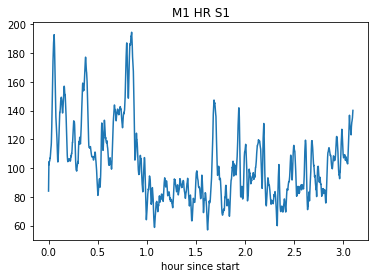

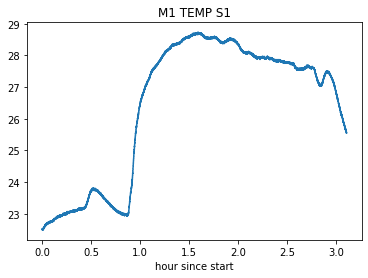

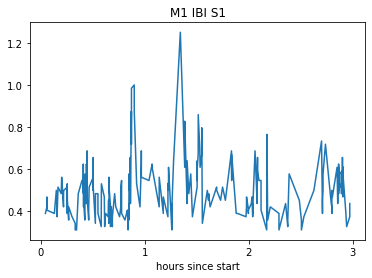

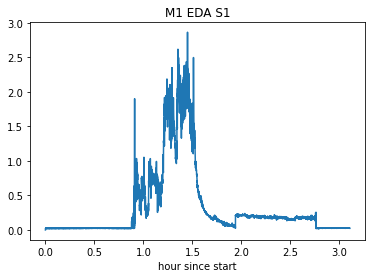

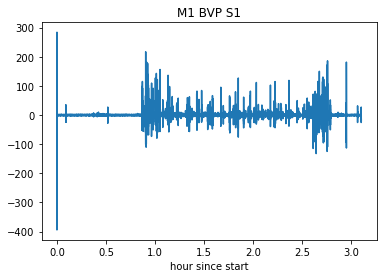

In [37]:
atime = 120 # sec 
M1_HR_ave, t_M1_HR = smooth_data(M1_HR,M1_HR_fr,atime)
x1=[]
for i in range(len(M1_HR[0])):
  x1.append(i/M1_HR_fr[0]/3600)

plt.title('M1 HR S1')
plt.plot(x1,M1_HR[0])
plt.xlabel('hour since start')
plt.show()
x1=[]
for i in range(len(M1_TE[0])):
  x1.append(i/M1_TE_fr[0]/3600)

plt.title('M1 TEMP S1')
plt.plot(x1,M1_TE[0])
plt.xlabel('hour since start')
plt.show()

plt.title('M1 IBI S1')
plt.plot(M1_IB_stime[0],M1_IB[0])
plt.xlabel('hours since start')
x_h1 = [0,3600,7200,10800]
labels1 = [0,1,2,3]
plt.xticks(x_h1, labels1)
plt.show()

x1=[]
for i in range(len(M1_EDA[0])):
  x1.append(i/M1_EDA_fr[0]/3600)

plt.plot(x1,M1_EDA[0])
plt.title('M1 EDA S1')
plt.xlabel('hour since start')
plt.show()

x1=[]
for i in range(len(M1_BVP[0])):
  x1.append(i/M1_BVP_fr[0]/3600)

plt.plot(x1,M1_BVP[0])
plt.title('M1 BVP S1')
plt.xlabel('hour since start')
plt.show()

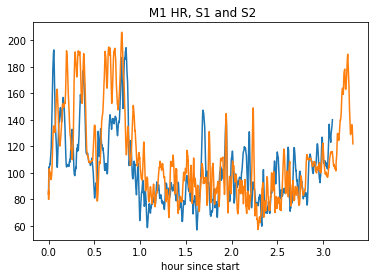

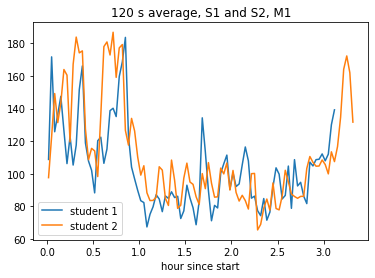

In [26]:
atime = 120 # sec 
M1_HR_ave, t_M1_HR = smooth_data(M1_HR,M1_HR_fr,atime)
#print(F_HR_ave)
x1=[]
for i in range(len(M1_HR[0])):
  x1.append(i/M1_HR_fr[0]/3600)

x2=[]
for i in range(len(M1_HR[1])):
  x2.append(i/M1_HR_fr[1]/3600)

plt.title(' M1 HR, S1 and S2')
plt.plot(x1,M1_HR[0],x2,M1_HR[1])
plt.xlabel('hour since start')
plt.show()
plt.title(str(atime)+' s average, S1 and S2, M1')
plt.plot(t_M1_HR[0],M1_HR_ave[0],t_M1_HR[1],M1_HR_ave[1])
plt.gca().legend(('student 1','student 2'))
plt.xlabel('hour since start')
plt.show()

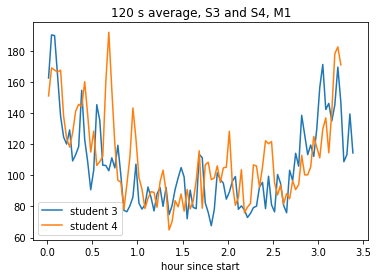

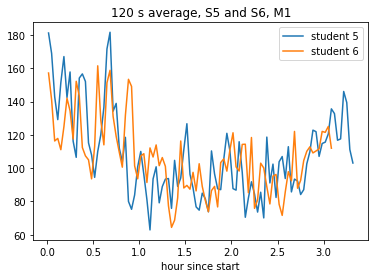

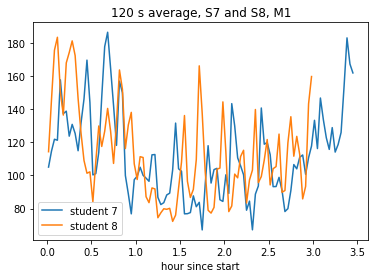

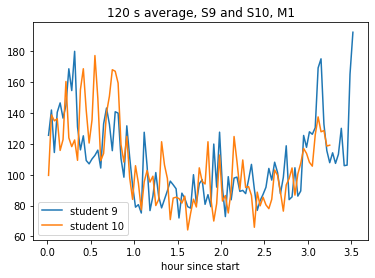

In [27]:
plt.title(str(atime)+' s average, S3 and S4, M1')
plt.plot(t_M1_HR[2],M1_HR_ave[2],t_M1_HR[3],M1_HR_ave[3])
plt.gca().legend(('student 3','student 4'))
plt.xlabel('hour since start')
plt.show()

plt.title(str(atime)+' s average, S5 and S6, M1')
plt.plot(t_M1_HR[4],M1_HR_ave[4],t_M1_HR[5],M1_HR_ave[5])
plt.gca().legend(('student 5','student 6'))
plt.xlabel('hour since start')
plt.show()

plt.title(str(atime)+' s average, S7 and S8, M1')
plt.plot(t_M1_HR[6],M1_HR_ave[6],t_M1_HR[7],M1_HR_ave[7])
plt.gca().legend(('student 7','student 8'))
plt.xlabel('hour since start')
plt.show()

plt.title(str(atime)+' s average, S9 and S10, M1')
plt.plot(t_M1_HR[8],M1_HR_ave[8],t_M1_HR[9],M1_HR_ave[9])
plt.gca().legend(('student 9','student 10'))
plt.xlabel('hour since start')
plt.show()

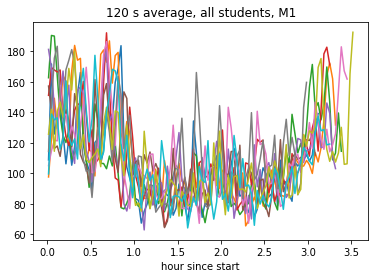

In [28]:
#ja kaikki huvin vuoksi
plt.title(str(atime)+' s average, all students, M1')
plt.plot(t_M1_HR[0],M1_HR_ave[0],t_M1_HR[1],M1_HR_ave[1],t_M1_HR[2],M1_HR_ave[2],t_M1_HR[3],M1_HR_ave[3],t_M1_HR[4],M1_HR_ave[4],
        t_M1_HR[5],M1_HR_ave[5],t_M1_HR[6],M1_HR_ave[6],t_M1_HR[7],M1_HR_ave[7],t_M1_HR[8],M1_HR_ave[8],t_M1_HR[9],M1_HR_ave[9])
plt.xlabel('hour since start')
plt.show()

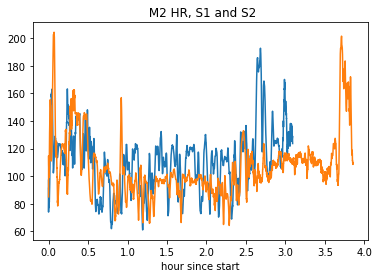

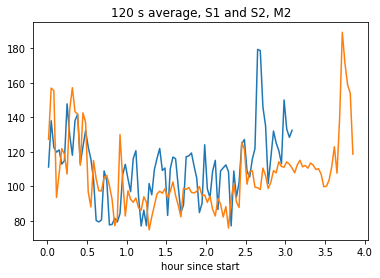

In [29]:
atime = 120 # sec 
M2_HR_ave, t_M2_HR = smooth_data(M2_HR,M2_HR_fr,atime)
#print(F_HR_ave)
x1=[]
for i in range(len(M2_HR[0])):
  x1.append(i/M2_HR_fr[0]/3600)

x2=[]
for i in range(len(M2_HR[1])):
  x2.append(i/M2_HR_fr[1]/3600)

plt.title(' M2 HR, S1 and S2')
plt.plot(x1,M2_HR[0],x2,M2_HR[1])
plt.xlabel('hour since start')
plt.show()
plt.title(str(atime)+' s average, S1 and S2, M2')
plt.plot(t_M2_HR[0],M2_HR_ave[0],t_M2_HR[1],M2_HR_ave[1])
plt.xlabel('hour since start')
plt.show()

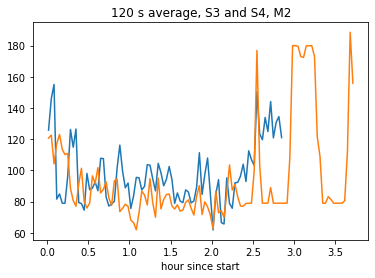

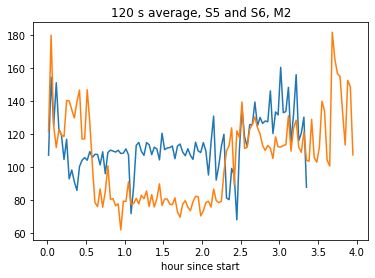

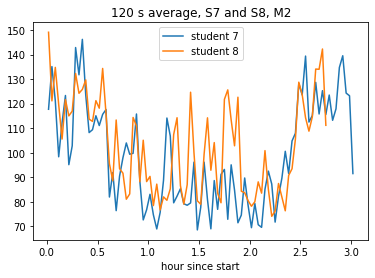

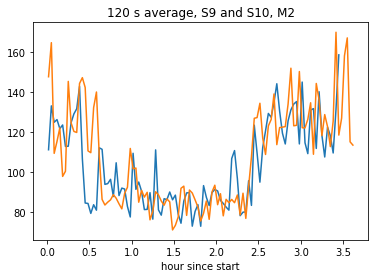

In [30]:
plt.title(str(atime)+' s average, S3 and S4, M2')
plt.plot(t_M2_HR[2],M2_HR_ave[2],t_M2_HR[3],M2_HR_ave[3])
plt.xlabel('hour since start')
plt.show()

plt.title(str(atime)+' s average, S5 and S6, M2')
plt.plot(t_M2_HR[4],M2_HR_ave[4],t_M2_HR[5],M2_HR_ave[5])
plt.xlabel('hour since start')
plt.show()

plt.title(str(atime)+' s average, S7 and S8, M2')
plt.plot(t_M2_HR[6],M2_HR_ave[6],t_M2_HR[7],M2_HR_ave[7])
plt.gca().legend(('student 7','student 8'))
plt.xlabel('hour since start')
plt.show()

plt.title(str(atime)+' s average, S9 and S10, M2')
plt.plot(t_M2_HR[8],M2_HR_ave[8],t_M2_HR[9],M2_HR_ave[9])
plt.xlabel('hour since start')
plt.show()

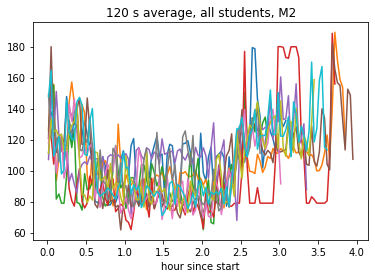

In [31]:
#ja huvin vuoksi kaikki samaan
plt.title(str(atime)+' s average, all students, M2')
plt.plot(t_M2_HR[0],M2_HR_ave[0],t_M2_HR[1],M2_HR_ave[1],t_M2_HR[2],M2_HR_ave[2],t_M2_HR[3],M2_HR_ave[3],t_M2_HR[4],M2_HR_ave[4],
        t_M2_HR[5],M2_HR_ave[5],t_M2_HR[6],M2_HR_ave[6],t_M2_HR[7],M2_HR_ave[7],t_M2_HR[8],M2_HR_ave[8],t_M2_HR[9],M2_HR_ave[9])
plt.xlabel('hour since start')
plt.show()

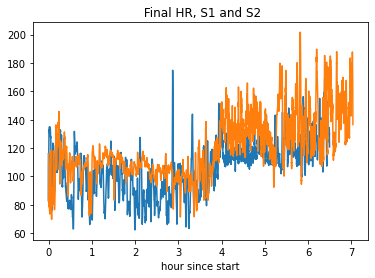

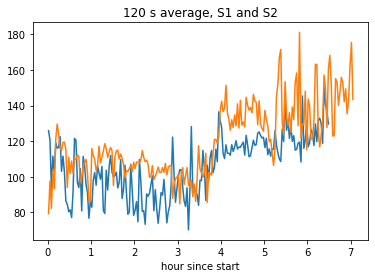

In [32]:
#for n in range(len(HR)):
#   plt.title(HR[n])
#   plt.plot(F_HR[n])
#   plt.show()

atime = 120 # sec 
F_HR_ave, t_F_HR = smooth_data(F_HR,F_HR_fr,atime)
#print(F_HR_ave)
x1=[]
for i in range(len(F_HR[0])):
  x1.append(i/F_HR_fr[0]/3600)

x2=[]
for i in range(len(F_HR[1])):
  x2.append(i/F_HR_fr[1]/3600)

plt.title(' Final HR, S1 and S2')
plt.plot(x1,F_HR[0],x2,F_HR[1])
plt.xlabel('hour since start')
plt.show()
plt.title(str(atime)+' s average, S1 and S2')
plt.plot(t_F_HR[0],F_HR_ave[0],t_F_HR[1],F_HR_ave[1])
plt.xlabel('hour since start')
plt.show()

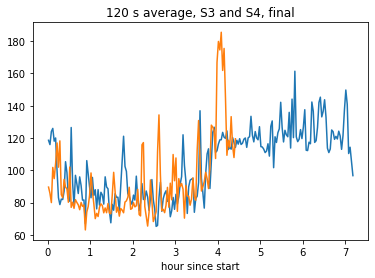

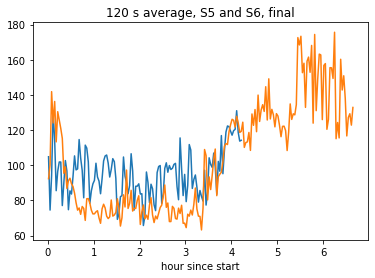

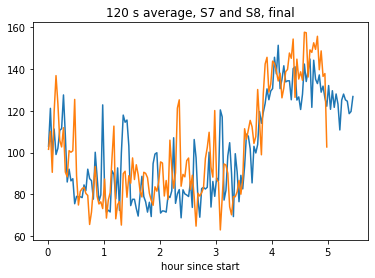

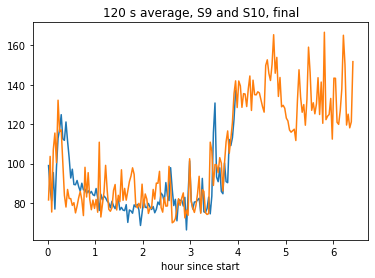

In [33]:
atime = 120 # sec 
F_HR_ave, t_F_HR = smooth_data(F_HR,F_HR_fr,atime)
#print(F_HR_ave)
x1=[]
for i in range(len(F_HR[0])):
  x1.append(i/F_HR_fr[0]/3600)

x2=[]
for i in range(len(F_HR[1])):
  x2.append(i/F_HR_fr[1]/3600)

plt.title(str(atime)+' s average, S3 and S4, final')
plt.plot(t_F_HR[2],F_HR_ave[2],t_F_HR[3],F_HR_ave[3])
plt.xlabel('hour since start')
plt.show()

plt.title(str(atime)+' s average, S5 and S6, final')
plt.plot(t_F_HR[4],F_HR_ave[4],t_F_HR[5],F_HR_ave[5])
plt.xlabel('hour since start')
plt.show()

plt.title(str(atime)+' s average, S7 and S8, final')
plt.plot(t_F_HR[6],F_HR_ave[6],t_F_HR[7],F_HR_ave[7])
plt.xlabel('hour since start')
plt.show()

plt.title(str(atime)+' s average, S9 and S10, final')
plt.plot(t_F_HR[8],F_HR_ave[8],t_F_HR[9],F_HR_ave[9])
plt.xlabel('hour since start')
plt.show()

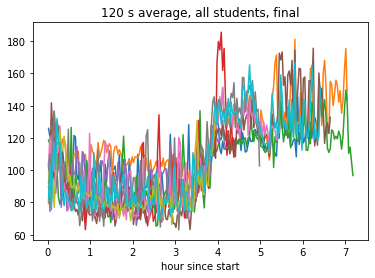

In [34]:
#ja huvin vuoksi kaikki samaan
plt.title(str(atime)+' s average, all students, final')
plt.plot(t_F_HR[0],F_HR_ave[0],t_F_HR[1],F_HR_ave[1],t_F_HR[2],F_HR_ave[2],t_F_HR[3],F_HR_ave[3],t_F_HR[4],F_HR_ave[4],
        t_F_HR[5],F_HR_ave[5],t_F_HR[6],F_HR_ave[6],t_F_HR[7],F_HR_ave[7],t_F_HR[8],F_HR_ave[8],t_F_HR[9],F_HR_ave[9])
plt.xlabel('hour since start')
plt.show()

In [35]:
M1_HR_smo_bf=[]
M1_HR_smo_ex=[]
M1_HR_smo_af=[]
M1_HR_frs = []
M1_HR_vars_ex = []
for i in range(10):
    M1_HR_frs.append(M1_HR_fr[i]/atime)
for i in range(10):
    t0 = 0
    t1 = unix_M1-M1_HR_time[i]
    M1_HR_smo_bf, M1_HR_stds_bf, M1_HR_vars_bf = aver_data(M1_HR_ave,M1_HR_frs,t0,t1) # HR before M1 exam
    t2 = t1 + 5400
    M1_HR_smo_ex, M1_HR_stds_ex, M1_HR_vars_ex = aver_data(M1_HR_ave,M1_HR_frs,t1,t2) # HR during M1 exam
    t3 = int(len(M1_HR[i]))
    M1_HR_smo_af, M1_HR_stds_af, M1_HR_vars_af = aver_data(M1_HR_ave,M1_HR_frs,t2,t3) # HR after M1 exam
for i in range(10):
    M1_HR_vars_ex.append(M1_HR_stds_ex[i]**2)
print('Heart rate aver BEFORE ',EX,' exam \n', M1_HR_smo_bf, np.mean(M1_HR_smo_bf))
print('Heart rate aver std BEFORE ',EX,' exam \n', M1_HR_stds_bf, np.mean(M1_HR_stds_bf))
print()
print('Heart rate BEFORE ',EX,' exam \n', M1_HR_mean_bf, np.mean(M1_HR_mean_bf))
print('Heart rate std BEFORE ',EX,' exam \n', M1_HR_std_bf, np.mean(M1_HR_std_bf))
print()
print('Heart rate DURING ',EX,' exam \n', M1_HR_smo_ex, np.mean(M1_HR_smo_ex))
print('Heart rate std DURING ',EX,' exam \n', M1_HR_stds_ex, np.mean(M1_HR_stds_ex))
print('Heart rate var DURING ',EX,' exam \n', M1_HR_vars_ex, np.mean(M1_HR_vars_ex))
print()
print('Heart rate AFTER ',EX,' exam \n', M1_HR_smo_af, np.mean(M1_HR_smo_af))
print('Heart rate std AFTER ',EX,' exam \n', M1_HR_stds_af, np.mean(M1_HR_stds_af))

Heart rate aver BEFORE  FINAL/  exam 
 [124.14326041666665, 141.91738281250002, 117.55420833333332, 131.0045390625, 128.67876562499998, 125.29771614583333, 128.39256770833333, 133.567984375, 124.8774765625, 130.49510677083333] 128.59290078125
Heart rate aver std BEFORE  FINAL/  exam 
 [26.241657264430394, 29.145447960639203, 29.82206915965996, 27.532687417238403, 29.422451113012084, 20.06458243586095, 26.492161959278928, 26.6385366336108, 22.597487617016853, 24.027556857356963] 26.19846384181045

Heart rate BEFORE  FINAL/  exam 
 [123.79797930142301, 141.58795601552393, 117.34501681759379, 130.69219922380336, 128.37610866752908, 125.10043984476066, 128.28904527813714, 133.3928486416559, 124.50694178525227, 130.1360698576973] 128.32246054333763
Heart rate std BEFORE  FINAL/  exam 
 [28.33082122139217, 31.91733325376198, 31.04596315228048, 30.52754884570547, 31.368519109432807, 22.974491370350936, 28.47040563086149, 28.24970730153903, 25.192955297030228, 26.68286802528222] 28.47606132076

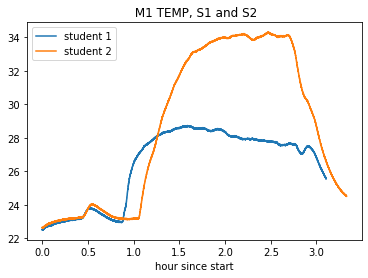

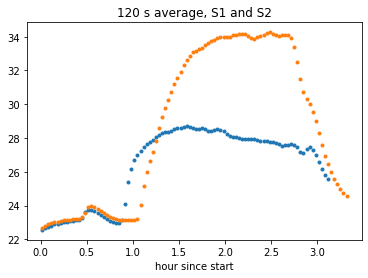

In [36]:
atime = 120 # sec 
M1_TE_ave, t_M1_TE = smooth_data(M1_TE,M1_TE_fr,atime)
#print(F_HR_ave)
x1=[]
for i in range(len(M1_TE[0])):
  x1.append(i/M1_TE_fr[0]/3600)

x2=[]
for i in range(len(M1_TE[1])):
  x2.append(i/M1_TE_fr[1]/3600)

plt.title(' M1 TEMP, S1 and S2')
plt.plot(x1,M1_TE[0],x2,M1_TE[1])
plt.gca().legend(('student 1','student 2'))
plt.xlabel('hour since start')
plt.show()
plt.title(str(atime)+' s average, S1 and S2')
plt.plot(t_M1_TE[0],M1_TE_ave[0],'.',t_M1_TE[1],M1_TE_ave[1],'.')
plt.xlabel('hour since start')
plt.show()

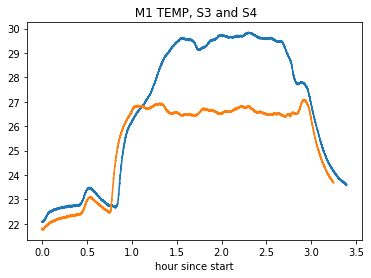

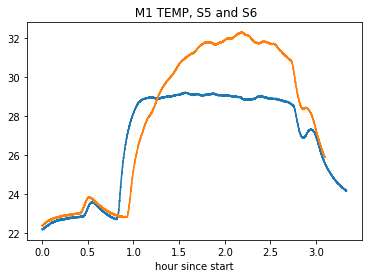

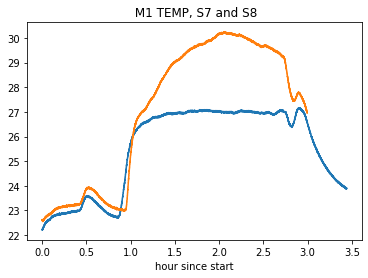

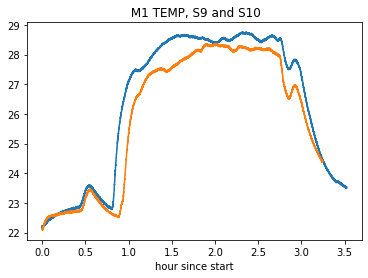

In [37]:
x1=[]
for i in range(len(M1_TE[2])):
  x1.append(i/M1_TE_fr[2]/3600)

x2=[]
for i in range(len(M1_TE[3])):
  x2.append(i/M1_TE_fr[3]/3600)

plt.title(' M1 TEMP, S3 and S4')
plt.plot(x1,M1_TE[2],x2,M1_TE[3])
plt.xlabel('hour since start')
plt.show()

x1=[]
for i in range(len(M1_TE[4])):
  x1.append(i/M1_TE_fr[4]/3600)

x2=[]
for i in range(len(M1_TE[5])):
  x2.append(i/M1_TE_fr[5]/3600)

plt.title(' M1 TEMP, S5 and S6')
plt.plot(x1,M1_TE[4],x2,M1_TE[5])
plt.xlabel('hour since start')
plt.show()

x1=[]
for i in range(len(M1_TE[6])):
  x1.append(i/M1_TE_fr[6]/3600)

x2=[]
for i in range(len(M1_TE[7])):
  x2.append(i/M1_TE_fr[7]/3600)

plt.title(' M1 TEMP, S7 and S8')
plt.plot(x1,M1_TE[6],x2,M1_TE[7])
plt.xlabel('hour since start')
plt.show()

x1=[]
for i in range(len(M1_TE[8])):
  x1.append(i/M1_TE_fr[8]/3600)

x2=[]
for i in range(len(M1_TE[9])):
  x2.append(i/M1_TE_fr[9]/3600)

plt.title(' M1 TEMP, S9 and S10')
plt.plot(x1,M1_TE[8],x2,M1_TE[9])
plt.xlabel('hour since start')
plt.show()

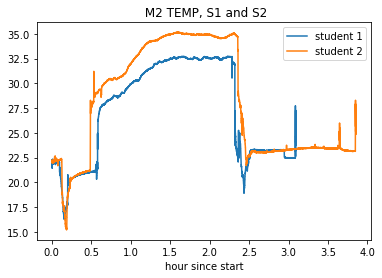

In [38]:
x1=[]
for i in range(len(M2_TE[0])):
  x1.append(i/M2_TE_fr[0]/3600)

x2=[]
for i in range(len(M2_TE[1])):
  x2.append(i/M2_TE_fr[1]/3600)

plt.title(' M2 TEMP, S1 and S2')
plt.plot(x1,M2_TE[0],x2,M2_TE[1])
plt.gca().legend(('student 1','student 2'))
plt.xlabel('hour since start')
plt.show()

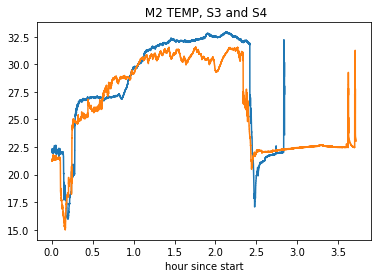

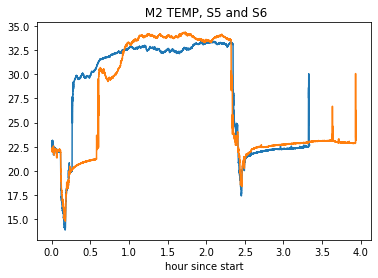

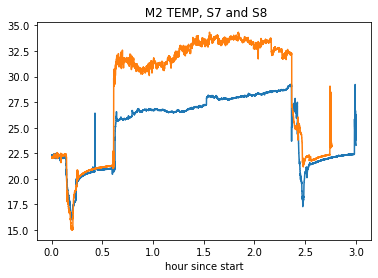

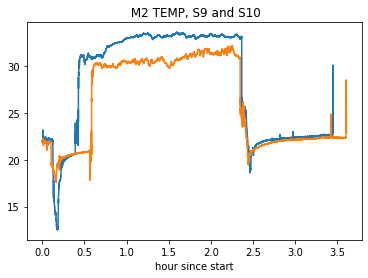

In [39]:
x1=[]
for i in range(len(M2_TE[2])):
  x1.append(i/M2_TE_fr[2]/3600)

x2=[]
for i in range(len(M2_TE[3])):
  x2.append(i/M2_TE_fr[3]/3600)

plt.title(' M2 TEMP, S3 and S4')
plt.plot(x1,M2_TE[2],x2,M2_TE[3])
plt.xlabel('hour since start')
plt.show()

x1=[]
for i in range(len(M2_TE[4])):
  x1.append(i/M2_TE_fr[4]/3600)

x2=[]
for i in range(len(M2_TE[5])):
  x2.append(i/M2_TE_fr[5]/3600)

plt.title(' M2 TEMP, S5 and S6')
plt.plot(x1,M2_TE[4],x2,M2_TE[5])
plt.xlabel('hour since start')
plt.show()

x1=[]
for i in range(len(M2_TE[6])):
  x1.append(i/M2_TE_fr[6]/3600)

x2=[]
for i in range(len(M2_TE[7])):
  x2.append(i/M2_TE_fr[7]/3600)

plt.title(' M2 TEMP, S7 and S8')
plt.plot(x1,M2_TE[6],x2,M2_TE[7])
plt.xlabel('hour since start')
plt.show()

x1=[]
for i in range(len(M2_TE[8])):
  x1.append(i/M2_TE_fr[8]/3600)

x2=[]
for i in range(len(M2_TE[9])):
  x2.append(i/M2_TE_fr[9]/3600)

plt.title(' M2 TEMP, S9 and S10')
plt.plot(x1,M2_TE[8],x2,M2_TE[9])
plt.xlabel('hour since start')
plt.show()

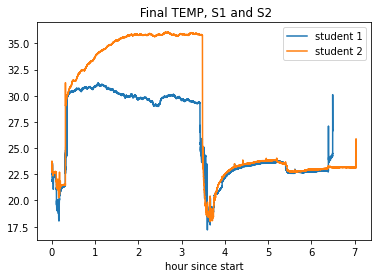

In [40]:
atime = 120 # sec 
F_TE_ave, t_F_TE = smooth_data(F_TE,F_TE_fr,atime)
#print(F_HR_ave)
x1=[]
for i in range(len(F_TE[0])):
  x1.append(i/F_TE_fr[0]/3600)

x2=[]
for i in range(len(F_TE[1])):
  x2.append(i/F_TE_fr[1]/3600)

plt.title(' Final TEMP, S1 and S2')
plt.plot(x1,F_TE[0],x2,F_TE[1])
plt.gca().legend(('student 1','student 2'))
plt.xlabel('hour since start')
plt.show()
#plt.title(str(atime)+' s average, S1 and S2')
#plt.plot(t_F_TE[0],F_TE_ave[0],'.',t_F_TE[1],F_TE_ave[1],'.')
#plt.xlabel('hour since start')
#plt.show()

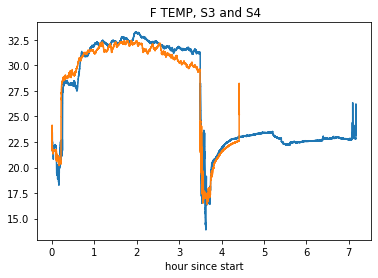

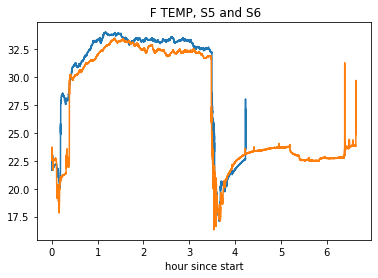

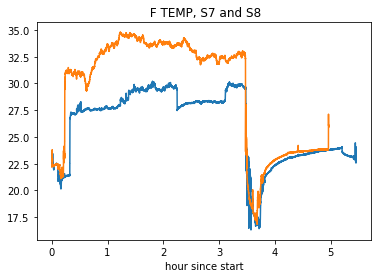

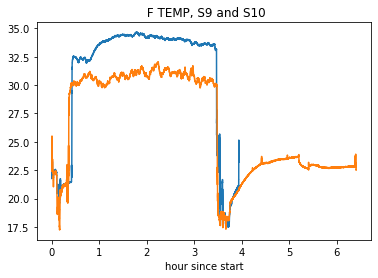

In [41]:
x1=[]
for i in range(len(F_TE[2])):
  x1.append(i/F_TE_fr[2]/3600)

x2=[]
for i in range(len(F_TE[3])):
  x2.append(i/F_TE_fr[3]/3600)

plt.title(' F TEMP, S3 and S4')
plt.plot(x1,F_TE[2],x2,F_TE[3])
plt.xlabel('hour since start')
plt.show()

x1=[]
for i in range(len(F_TE[4])):
  x1.append(i/F_TE_fr[4]/3600)

x2=[]
for i in range(len(F_TE[5])):
  x2.append(i/F_TE_fr[5]/3600)

plt.title(' F TEMP, S5 and S6')
plt.plot(x1,F_TE[4],x2,F_TE[5])
plt.xlabel('hour since start')
plt.show()

x1=[]
for i in range(len(F_TE[6])):
  x1.append(i/F_TE_fr[6]/3600)

x2=[]
for i in range(len(F_TE[7])):
  x2.append(i/F_TE_fr[7]/3600)

plt.title(' F TEMP, S7 and S8')
plt.plot(x1,F_TE[6],x2,F_TE[7])
plt.xlabel('hour since start')
plt.show()

x1=[]
for i in range(len(F_TE[8])):
  x1.append(i/F_TE_fr[8]/3600)

x2=[]
for i in range(len(F_TE[9])):
  x2.append(i/F_TE_fr[9]/3600)

plt.title(' F TEMP, S9 and S10')
plt.plot(x1,F_TE[8],x2,F_TE[9])
plt.xlabel('hour since start')
plt.show()

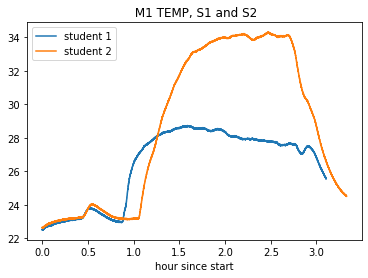

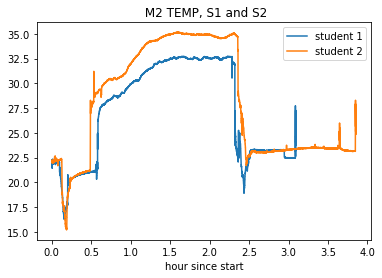

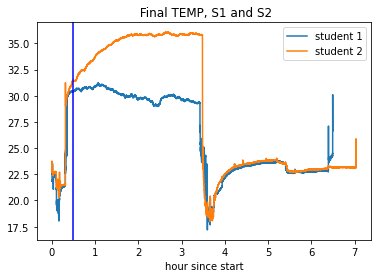

In [42]:
x1=[]
for i in range(len(M1_TE[0])):
  x1.append(i/M1_TE_fr[0]/3600)

x2=[]
for i in range(len(M1_TE[1])):
  x2.append(i/M1_TE_fr[1]/3600)

plt.title(' M1 TEMP, S1 and S2')
plt.plot(x1,M1_TE[0],x2,M1_TE[1])
plt.gca().legend(('student 1','student 2'))
plt.xlabel('hour since start')
plt.show()

x1=[]
for i in range(len(M2_TE[0])):
  x1.append(i/M2_TE_fr[0]/3600)

x2=[]
for i in range(len(M2_TE[1])):
  x2.append(i/M2_TE_fr[1]/3600)
 
plt.title(' M2 TEMP, S1 and S2')
plt.plot(x1,M2_TE[0],x2,M2_TE[1])
plt.gca().legend(('student 1','student 2'))
plt.xlabel('hour since start')
plt.show()

x1=[]
for i in range(len(F_TE[0])):
  x1.append(i/F_TE_fr[0]/3600)

x2=[]
for i in range(len(F_TE[1])):
  x2.append(i/F_TE_fr[1]/3600)

plt.title(' Final TEMP, S1 and S2')
plt.plot(x1,F_TE[0],x2,F_TE[1])
plt.gca().legend(('student 1','student 2'))
plt.axvline(x = 0.5, color = 'b')
plt.xlabel('hour since start')
plt.show()


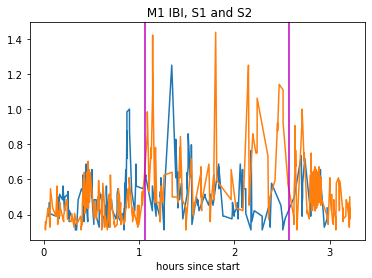

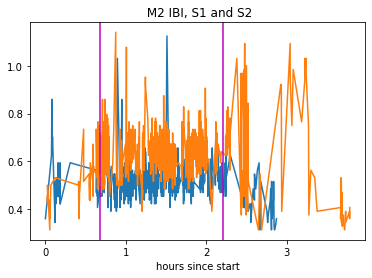

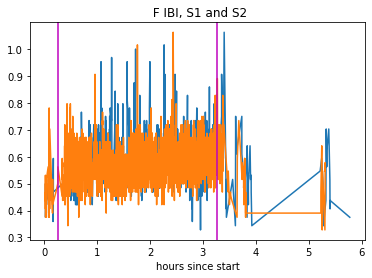

In [50]:
plt.title(' M1 IBI, S1 and S2')
plt.plot(M1_IB_stime[0],M1_IB[0],M1_IB_stime[1],M1_IB[1])
plt.xlabel('hours since start')
x_h1 = [0,3600,7200,10800]
labels1 = [0,1,2,3]
plt.xticks(x_h1, labels1)
plt.axvline(x = 3834.0, color = 'm')
plt.axvline(x = 3855.0+5400, color = 'm')
plt.show()
plt.title(' M2 IBI, S1 and S2')
plt.plot(M2_IB_stime[0],M2_IB[0],M2_IB_stime[1],M2_IB[1])
plt.xlabel('hours since start')
plt.xticks(x_h1,labels1)
plt.axvline(x = 2445.0, color = 'm')
plt.axvline(x = 2551.0+5400, color = 'm')
plt.show()
x_h2 = [0,3600,7200,10800,14400,18000,21600,25200]
labels2 = [0,1,2,3,4,5,6,7]
plt.xlabel('hours since start')
plt.xticks(x_h2,labels2)
plt.title(' F IBI, S1 and S2')
plt.plot(F_IB_stime[0],F_IB[0],F_IB_stime[1],F_IB[1])
plt.axvline(x = 963.0, color = 'm')
plt.axvline(x = 956.0+10800, color = 'm')
plt.show()

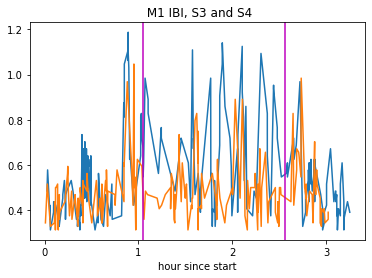

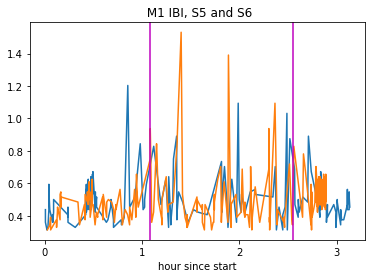

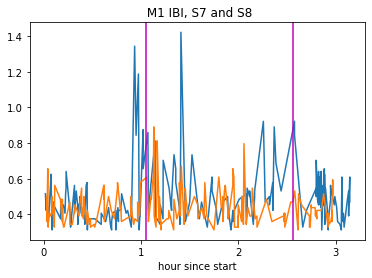

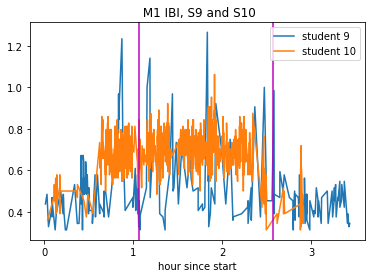

In [51]:
plt.title(' M1 IBI, S3 and S4')
plt.plot(M1_IB_stime[2],M1_IB[2],M1_IB_stime[3],M1_IB[3])
plt.xlabel('hour since start')
x_h1 = [0,3600,7200,10800]
labels1 = [0,1,2,3]
plt.xticks(x_h1, labels1)
plt.axvline(x = 3792.0, color = 'm')
plt.axvline(x = 3821.0+5400, color = 'm')
plt.show()

plt.title(' M1 IBI, S5 and S6')
plt.plot(M1_IB_stime[4],M1_IB[4],M1_IB_stime[5],M1_IB[5])
plt.xlabel('hour since start')
plt.xticks(x_h1, labels1)
plt.axvline(x = 3879.0, color = 'm')
plt.axvline(x = 3767.0+5400, color = 'm')
plt.show()

plt.title(' M1 IBI, S7 and S8')
plt.plot(M1_IB_stime[6],M1_IB[6],M1_IB_stime[7],M1_IB[7])
plt.xlabel('hour since start')
plt.xticks(x_h1, labels1)
plt.axvline(x = 3793.0, color = 'm')
plt.axvline(x = 3820.0+5400, color = 'm')
plt.show()

plt.title(' M1 IBI, S9 and S10')
plt.plot(M1_IB_stime[8],M1_IB[8],M2_IB_stime[9],M2_IB[9])
plt.xlabel('hour since start')
plt.xticks(x_h1, labels1)
plt.axvline(x = 3835.0, color = 'm')
plt.axvline(x = 3875.0+5400, color = 'm')
plt.gca().legend(('student 9','student 10'))
plt.show()

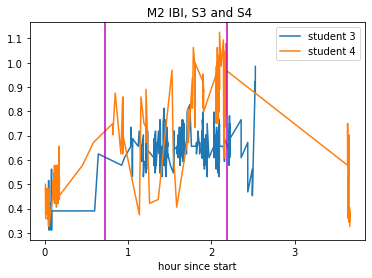

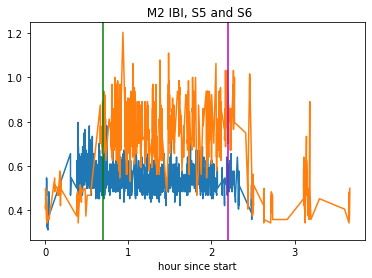

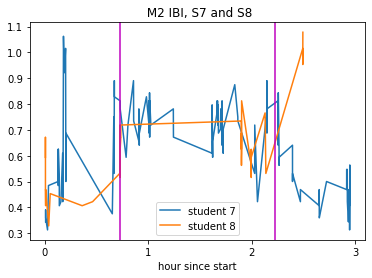

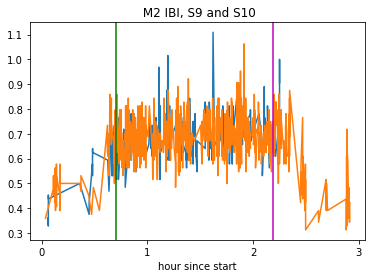

In [52]:
plt.title(' M2 IBI, S3 and S4')
plt.plot(M2_IB_stime[2],M2_IB[2],M2_IB_stime[3],M2_IB[3])
plt.xlabel('hour since start')
x_h1 = [0,3600,7200,10800]
labels1 = [0,1,2,3]
plt.xticks(x_h1, labels1)
plt.axvline(x = 2606.0, color = 'm')
plt.axvline(x = 2467.0+5400, color = 'm')
plt.gca().legend(('student 3','student 4'))
plt.show()

plt.title(' M2 IBI, S5 and S6')
plt.plot(M2_IB_stime[4],M2_IB[4],M2_IB_stime[5],M2_IB[5])
plt.xlabel('hour since start')
plt.xticks(x_h1, labels1)
plt.axvline(x = 2502.0, color = 'g')
plt.axvline(x = 2512.0+5400, color = 'm')
plt.show()

plt.title(' M2 IBI, S7 and S8')
plt.plot(M2_IB_stime[6],M2_IB[6],M2_IB_stime[7],M2_IB[7])
plt.xlabel('hour since start')
plt.xticks(x_h1, labels1)
plt.axvline(x = 2597.0, color = 'm')
plt.axvline(x = 2616.0+5400, color = 'm')
plt.gca().legend(('student 7','student 8'))
plt.show()

plt.title(' M2 IBI, S9 and S10')
plt.plot(M2_IB_stime[8],M2_IB[8],M2_IB_stime[9],M2_IB[9])
plt.xlabel('hour since start')
plt.xticks(x_h1, labels1)
plt.axvline(x = 2545.0, color = 'g')
plt.axvline(x = 2475.0+5400, color = 'm')
plt.show()

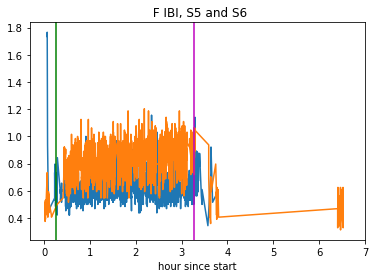

In [56]:
plt.title(' F IBI, S5 and S6')
plt.plot(F_IB_stime[4],F_IB[4],F_IB_stime[5],F_IB[5])
plt.xlabel('hour since start')
x_h2 = [0,3600,7200,10800,14400,18000,21600,25200]
labels2 = [0,1,2,3,4,5,6,7]
plt.xticks(x_h2,labels2)
plt.axvline(x = 966.0, color = 'g')
plt.axvline(x = 953.0+10800, color = 'm')
plt.show()

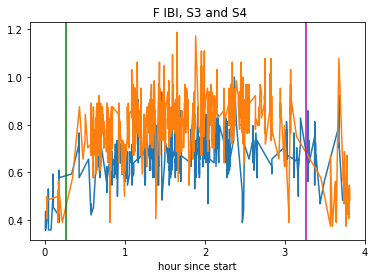

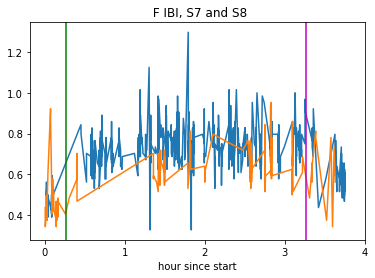

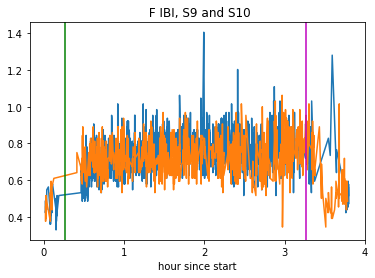

In [55]:
plt.title(' F IBI, S3 and S4')
plt.plot(F_IB_stime[2],F_IB[2],F_IB_stime[3],F_IB[3])
plt.xlabel('hour since start')
x_h2 = [0,3600,7200,10800,14400]
labels2 = [0,1,2,3,4]
plt.xticks(x_h2,labels2)
plt.axvline(x = 966.0, color = 'g')
plt.axvline(x = 958.0+10800, color = 'm')
plt.show()

plt.title(' F IBI, S7 and S8')
plt.plot(F_IB_stime[6],F_IB[6],F_IB_stime[7],F_IB[7])
plt.xlabel('hour since start')
plt.xticks(x_h2,labels2)
plt.axvline(x = 964.0, color = 'g')
plt.axvline(x = 961.0+10800, color = 'm')
plt.show()

plt.title(' F IBI, S9 and S10')
plt.plot(F_IB_stime[8],F_IB[8],F_IB_stime[9],F_IB[9])
plt.xlabel('hour since start')
plt.xticks(x_h2,labels2)
plt.axvline(x = 953.0, color = 'g')
plt.axvline(x = 966.0+10800, color = 'm')
plt.show()

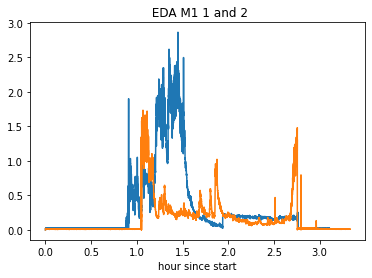

In [47]:
x1=[]
for i in range(len(M1_EDA[0])):
  x1.append(i/M1_EDA_fr[0]/3600)
x2=[]
for i in range(len(M1_EDA[1])):
  x2.append(i/M1_EDA_fr[1]/3600)
#x3=[]
#for i in range(len(M1_EDA[2])):
#  x3.append(i/M1_EDA_fr[2]/3600)

plt.plot(x1,M1_EDA[0],x2,M1_EDA[1]) #,x3,M1_EDA[2]
plt.title(' EDA M1 1 and 2')
plt.xlabel('hour since start')
plt.show()

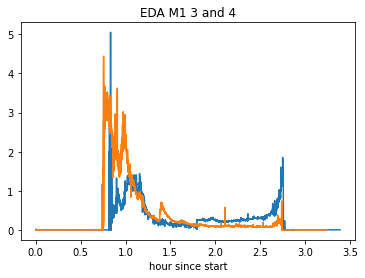

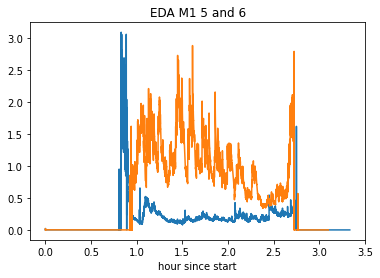

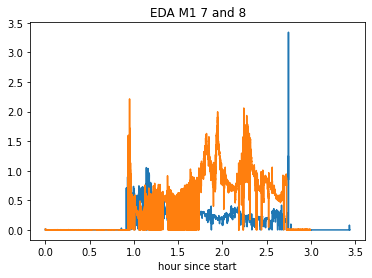

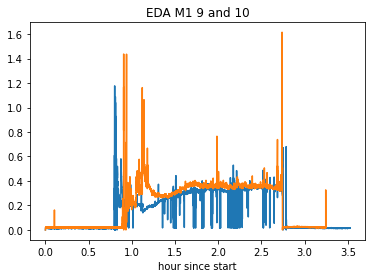

In [48]:
x1=[]
for i in range(len(M1_EDA[2])):
  x1.append(i/M1_EDA_fr[2]/3600)
x2=[]
for i in range(len(M1_EDA[3])):
  x2.append(i/M1_EDA_fr[3]/3600)

plt.plot(x1,M1_EDA[2],x2,M1_EDA[3])
plt.title('EDA M1 3 and 4')
plt.xlabel('hour since start')
plt.show()

x1=[]
for i in range(len(M1_EDA[4])):
  x1.append(i/M1_EDA_fr[4]/3600)
x2=[]
for i in range(len(M1_EDA[5])):
  x2.append(i/M1_EDA_fr[5]/3600)

plt.plot(x1,M1_EDA[4],x2,M1_EDA[5])
plt.title('EDA M1 5 and 6')
plt.xlabel('hour since start')
plt.show()

x1=[]
for i in range(len(M1_EDA[6])):
  x1.append(i/M1_EDA_fr[6]/3600)
x2=[]
for i in range(len(M1_EDA[7])):
  x2.append(i/M1_EDA_fr[7]/3600)

plt.plot(x1,M1_EDA[6],x2,M1_EDA[7])
plt.title('EDA M1 7 and 8')
plt.xlabel('hour since start')
plt.show()

x1=[]
for i in range(len(M1_EDA[8])):
  x1.append(i/M1_EDA_fr[8]/3600)
x2=[]
for i in range(len(M1_EDA[9])):
  x2.append(i/M1_EDA_fr[9]/3600)

plt.plot(x1,M1_EDA[8],x2,M1_EDA[9])
plt.title('EDA M1 9 and 10')
plt.xlabel('hour since start')
plt.show()

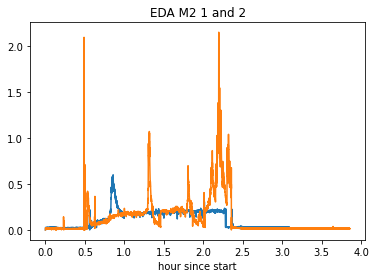

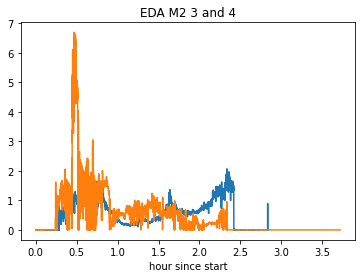

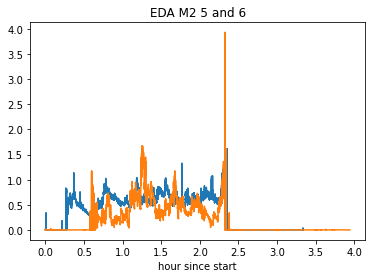

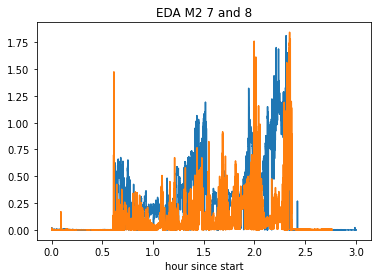

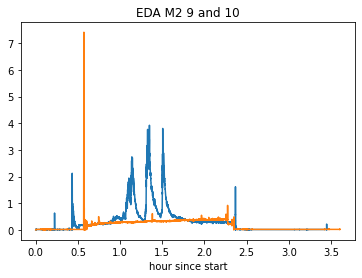

In [49]:
x1=[]
for i in range(len(M2_EDA[0])):
  x1.append(i/M2_EDA_fr[0]/3600)
x2=[]
for i in range(len(M2_EDA[1])):
  x2.append(i/M2_EDA_fr[1]/3600)

plt.plot(x1,M2_EDA[0],x2,M2_EDA[1])
plt.title('EDA M2 1 and 2')
plt.xlabel('hour since start')
plt.show()

x1=[]
for i in range(len(M2_EDA[2])):
  x1.append(i/M2_EDA_fr[2]/3600)
x2=[]
for i in range(len(M2_EDA[3])):
  x2.append(i/M2_EDA_fr[3]/3600)

plt.plot(x1,M2_EDA[2],x2,M2_EDA[3])
plt.title('EDA M2 3 and 4')
plt.xlabel('hour since start')
plt.show()

x1=[]
for i in range(len(M2_EDA[4])):
  x1.append(i/M2_EDA_fr[4]/3600)
x2=[]
for i in range(len(M2_EDA[5])):
  x2.append(i/M2_EDA_fr[5]/3600)

plt.plot(x1,M2_EDA[4],x2,M2_EDA[5])
plt.title('EDA M2 5 and 6')
plt.xlabel('hour since start')
plt.show()

x1=[]
for i in range(len(M2_EDA[6])):
  x1.append(i/M2_EDA_fr[6]/3600)
x2=[]
for i in range(len(M2_EDA[7])):
  x2.append(i/M2_EDA_fr[7]/3600)

plt.plot(x1,M2_EDA[6],x2,M2_EDA[7])
plt.title('EDA M2 7 and 8')
plt.xlabel('hour since start')
plt.show()

x1=[]
for i in range(len(M2_EDA[8])):
  x1.append(i/M2_EDA_fr[8]/3600)
x2=[]
for i in range(len(M2_EDA[9])):
  x2.append(i/M2_EDA_fr[9]/3600)

plt.plot(x1,M2_EDA[8],x2,M2_EDA[9])
plt.title('EDA M2 9 and 10')
plt.xlabel('hour since start')
plt.show()

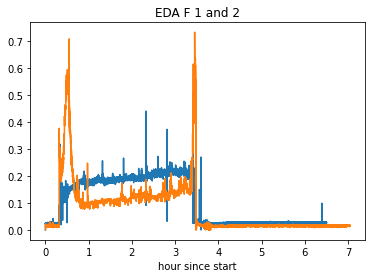

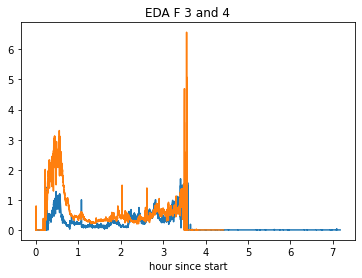

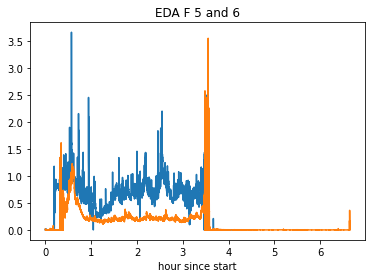

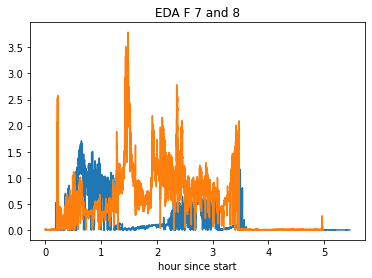

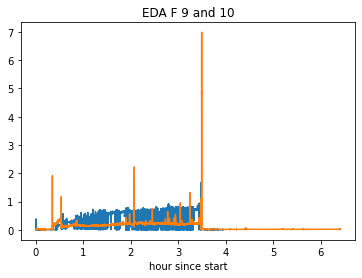

In [50]:
x1=[]
for i in range(len(F_EDA[0])):
  x1.append(i/F_EDA_fr[0]/3600)
x2=[]
for i in range(len(F_EDA[1])):
  x2.append(i/F_EDA_fr[1]/3600)

plt.plot(x1,F_EDA[0],x2,F_EDA[1])
plt.title('EDA F 1 and 2')
plt.xlabel('hour since start')
plt.show()

x1=[]
for i in range(len(F_EDA[2])):
  x1.append(i/F_EDA_fr[2]/3600)
x2=[]
for i in range(len(F_EDA[3])):
  x2.append(i/F_EDA_fr[3]/3600)

plt.plot(x1,F_EDA[2],x2,F_EDA[3])
plt.title('EDA F 3 and 4')
plt.xlabel('hour since start')
plt.show()

x1=[]
for i in range(len(F_EDA[4])):
  x1.append(i/F_EDA_fr[4]/3600)
x2=[]
for i in range(len(F_EDA[5])):
  x2.append(i/F_EDA_fr[5]/3600)

plt.plot(x1,F_EDA[4],x2,F_EDA[5])
plt.title('EDA F 5 and 6')
plt.xlabel('hour since start')
plt.show()

x1=[]
for i in range(len(F_EDA[6])):
  x1.append(i/F_EDA_fr[6]/3600)
x2=[]
for i in range(len(F_EDA[7])):
  x2.append(i/F_EDA_fr[7]/3600)

plt.plot(x1,F_EDA[6],x2,F_EDA[7])
plt.title('EDA F 7 and 8')
plt.xlabel('hour since start')
plt.show()

x1=[]
for i in range(len(F_EDA[8])):
  x1.append(i/F_EDA_fr[8]/3600)
x2=[]
for i in range(len(F_EDA[9])):
  x2.append(i/F_EDA_fr[9]/3600)

plt.plot(x1,F_EDA[8],x2,F_EDA[9])
plt.title('EDA F 9 and 10')
plt.xlabel('hour since start')
plt.show()

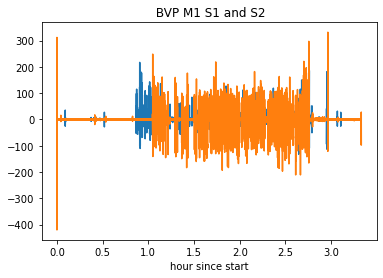

In [51]:
x1=[]
for i in range(len(M1_BVP[0])):
  x1.append(i/M1_BVP_fr[0]/3600)

x2=[]
for i in range(len(M1_BVP[1])):
  x2.append(i/M1_BVP_fr[1]/3600)

plt.plot(x1,M1_BVP[0],x2,M1_BVP[1])
plt.title(' BVP M1 S1 and S2')
plt.xlabel('hour since start')
#plt.xlim((1.35,0.5))
plt.show()
#print(M1_BVP[0][0:90])
#print(M1_BVP[1][0:90])
#print(M1_BVP[2][0:90])

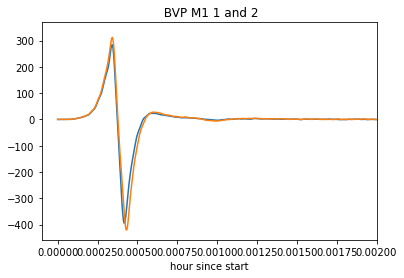

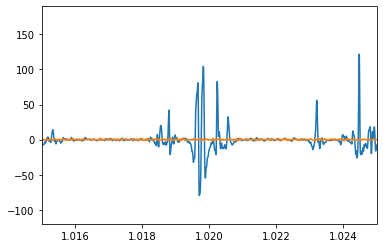

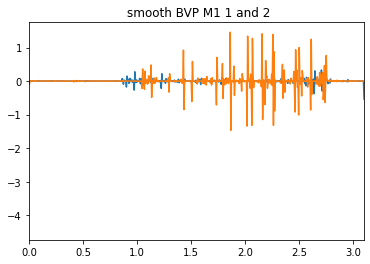

In [52]:
#kopio code_05:sta
M1_BVP_ave=[]
t_M1_BVPa=[]
atime = 20 # sec 
M1_BVP_ave, t_M1_BVP = smooth_data(M1_BVP,M1_BVP_fr,atime)

plt.plot(x1,M1_BVP[0],x2,M1_BVP[1])
plt.title(' BVP M1 1 and 2')
plt.xlabel('hour since start')
plt.xlim((-0.0001,0.002))
plt.show()
plt.plot(x1,M1_BVP[0],x2,M1_BVP[1])
plt.xlim((1.015,1.025))
plt.ylim((-120,190))
plt.show()
plt.plot(t_M1_BVP[0],M1_BVP_ave[0],t_M1_BVP[1],M1_BVP_ave[1])
plt.xlim((.0,3.1))
#plt.ylim((-120,190))
plt.title(' smooth BVP M1 1 and 2')
plt.show()

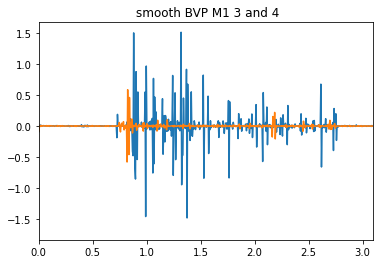

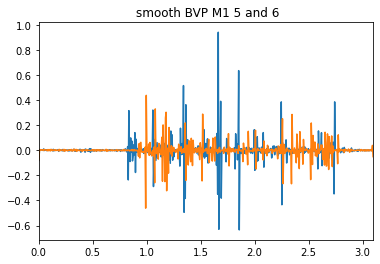

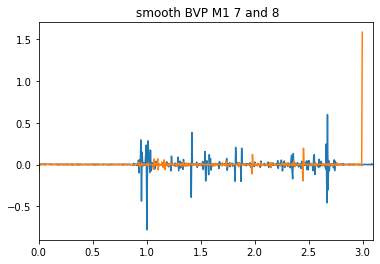

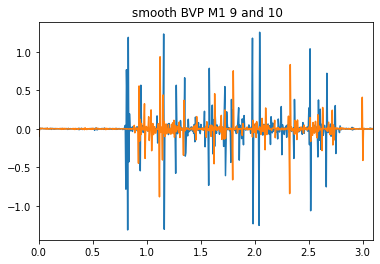

In [53]:
plt.plot(t_M1_BVP[2],M1_BVP_ave[2],t_M1_BVP[3],M1_BVP_ave[3])
plt.xlim((.0,3.1))
#plt.ylim((-120,190))
plt.title(' smooth BVP M1 3 and 4')
plt.show()

plt.plot(t_M1_BVP[4],M1_BVP_ave[4],t_M1_BVP[5],M1_BVP_ave[5])
plt.xlim((.0,3.1))
#plt.ylim((-120,190))
plt.title(' smooth BVP M1 5 and 6')
plt.show()

plt.plot(t_M1_BVP[6],M1_BVP_ave[6],t_M1_BVP[7],M1_BVP_ave[7])
plt.xlim((.0,3.1))
#plt.ylim((-120,190))
plt.title(' smooth BVP M1 7 and 8')
plt.show()

plt.plot(t_M1_BVP[8],M1_BVP_ave[8],t_M1_BVP[9],M1_BVP_ave[9])
plt.xlim((.0,3.1))
#plt.ylim((-120,190))
plt.title(' smooth BVP M1 9 and 10')
plt.show()

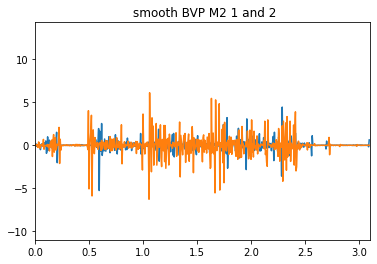

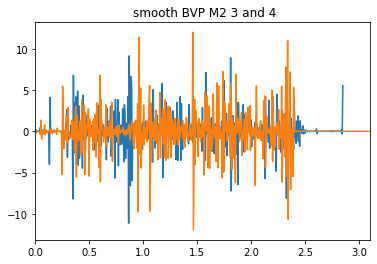

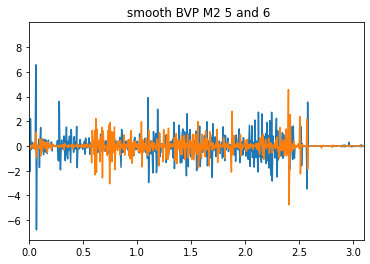

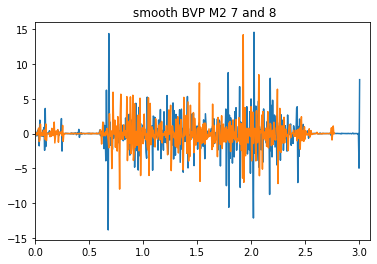

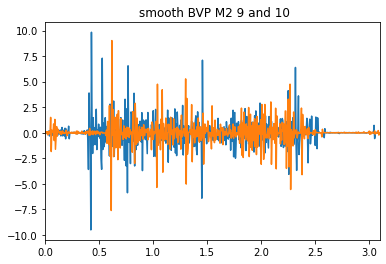

In [54]:
M2_BVP_ave=[]
t_M2_BVP=[]
atime = 20 # sec 
M2_BVP_ave, t_M2_BVP = smooth_data(M2_BVP,M2_BVP_fr,atime)

plt.plot(t_M2_BVP[0],M2_BVP_ave[0],t_M2_BVP[1],M2_BVP_ave[1])
plt.xlim((.0,3.1))
#plt.ylim((-120,190))
plt.title(' smooth BVP M2 1 and 2')
plt.show()

plt.plot(t_M2_BVP[2],M2_BVP_ave[2],t_M2_BVP[3],M2_BVP_ave[3])
plt.xlim((.0,3.1))
#plt.ylim((-120,190))
plt.title(' smooth BVP M2 3 and 4')
plt.show()

plt.plot(t_M2_BVP[4],M2_BVP_ave[4],t_M2_BVP[5],M2_BVP_ave[5])
plt.xlim((.0,3.1))
#plt.ylim((-120,190))
plt.title(' smooth BVP M2 5 and 6')
plt.show()

plt.plot(t_M2_BVP[6],M2_BVP_ave[6],t_M2_BVP[7],M2_BVP_ave[7])
plt.xlim((.0,3.1))
#plt.ylim((-120,190))
plt.title(' smooth BVP M2 7 and 8')
plt.show()

plt.plot(t_M2_BVP[8],M2_BVP_ave[8],t_M2_BVP[9],M2_BVP_ave[9])
plt.xlim((.0,3.1))
#plt.ylim((-120,190))
plt.title(' smooth BVP M2 9 and 10')
plt.show()

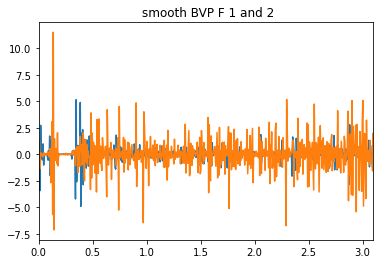

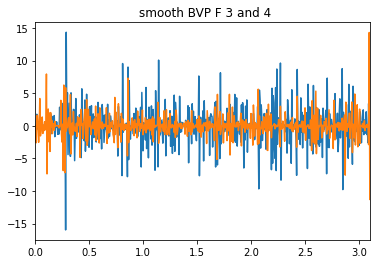

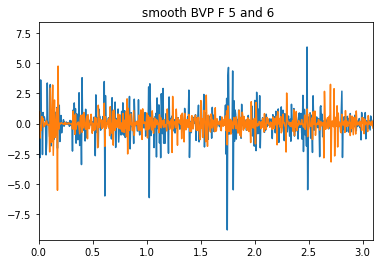

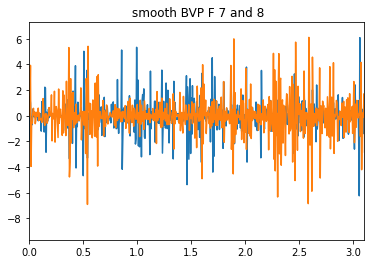

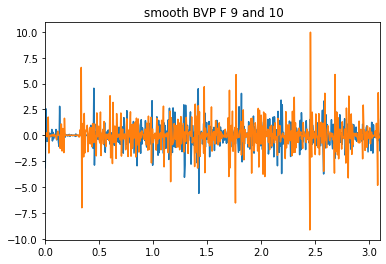

In [55]:
F_BVP_ave=[]
t_F_BVP=[]
atime = 20 # sec 
F_BVP_ave, t_F_BVP = smooth_data(F_BVP,F_BVP_fr,atime)

plt.plot(t_F_BVP[0],F_BVP_ave[0],t_F_BVP[1],F_BVP_ave[1])
plt.xlim((.0,3.1))
#plt.ylim((-120,190))
plt.title(' smooth BVP F 1 and 2')
plt.show()

plt.plot(t_F_BVP[2],F_BVP_ave[2],t_F_BVP[3],F_BVP_ave[3])
plt.xlim((.0,3.1))
#plt.ylim((-120,190))
plt.title(' smooth BVP F 3 and 4')
plt.show()

plt.plot(t_F_BVP[4],F_BVP_ave[4],t_F_BVP[5],F_BVP_ave[5])
plt.xlim((.0,3.1))
#plt.ylim((-120,190))
plt.title(' smooth BVP F 5 and 6')
plt.show()

plt.plot(t_F_BVP[6],F_BVP_ave[6],t_F_BVP[7],F_BVP_ave[7])
plt.xlim((.0,3.1))
#plt.ylim((-120,190))
plt.title(' smooth BVP F 7 and 8')
plt.show()

plt.plot(t_F_BVP[8],F_BVP_ave[8],t_F_BVP[9],F_BVP_ave[9])
plt.xlim((.0,3.1))
#plt.ylim((-120,190))
plt.title(' smooth BVP F 9 and 10')
plt.show()

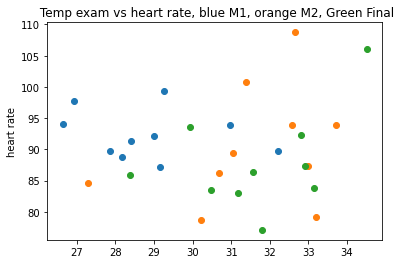

M1 Temp vs HR  R^2: 0.04562075970701146
M2 Temp vs HR  R^2: 0.10144963218437739
F  Temp vs HR  R^2: 0.17311933701396048


In [56]:
plt.plot(M1_TE_mean_ex,M1_HR_mean_ex,'o',M2_TE_mean_ex,M2_HR_mean_ex,'o',F_TE_mean_ex,F_HR_mean_ex,'o')
plt.title(' Temp exam vs heart rate, blue M1, orange M2, Green Final')
plt.ylabel('heart rate')
plt.show()
linfit = linregress(M1_TE_mean_ex, M1_HR_mean_ex)
r=linfit.rvalue
print('M1 Temp vs HR  R^2:', r*r)
linfit = linregress(M2_TE_mean_ex, M2_HR_mean_ex)
r=linfit.rvalue
print('M2 Temp vs HR  R^2:', r*r)
linfit = linregress(F_TE_mean_ex, F_HR_mean_ex)
r=linfit.rvalue
print('F  Temp vs HR  R^2:', r*r)

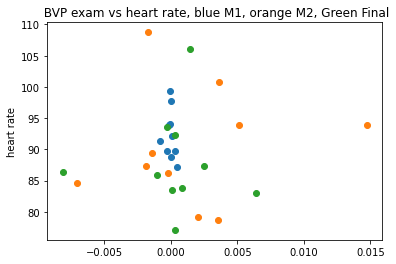

M1 BVP vs HR  R^2: 0.024507613426396863
M2 BVP vs HR  R^2: 0.016225622288873198
F  BVP vs HR  R^2: 3.862891738802286e-06


In [57]:
plt.plot(M1_BVP_mean_ex,M1_HR_mean_ex,'o',M2_BVP_mean_ex,M2_HR_mean_ex,'o',F_BVP_mean_ex,F_HR_mean_ex,'o')
plt.title(' BVP exam vs heart rate, blue M1, orange M2, Green Final')
plt.ylabel('heart rate')
plt.show()
linfit = linregress(M1_BVP_mean_ex, M1_HR_mean_ex)
r=linfit.rvalue
print('M1 BVP vs HR  R^2:', r*r)
linfit = linregress(M2_BVP_mean_ex, M2_HR_mean_ex)
r=linfit.rvalue
print('M2 BVP vs HR  R^2:', r*r)
linfit = linregress(F_BVP_mean_ex, F_HR_mean_ex)
r=linfit.rvalue
print('F  BVP vs HR  R^2:', r*r)

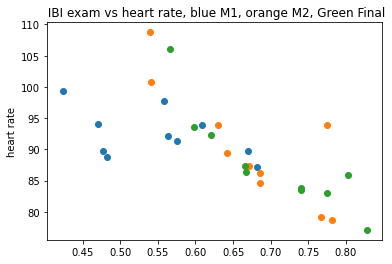

M1 IBI vs HR  R^2: 0.22977842714517105
M2 IBI vs HR  R^2: 0.6597035544873895
F  IBI vs HR  R^2: 0.7558980340100653


In [58]:
plt.plot(M1_IB_mean_ex,M1_HR_mean_ex,'o',M2_IB_mean_ex,M2_HR_mean_ex,'o',F_IB_mean_ex,F_HR_mean_ex,'o')
plt.title(' IBI exam vs heart rate, blue M1, orange M2, Green Final')
plt.ylabel('heart rate')
plt.show()
linfit = linregress(M1_IB_mean_ex, M1_HR_mean_ex)
r=linfit.rvalue
print('M1 IBI vs HR  R^2:', r*r)
linfit = linregress(M2_IB_mean_ex, M2_HR_mean_ex)
r=linfit.rvalue
print('M2 IBI vs HR  R^2:', r*r)
linfit = linregress(F_IB_mean_ex, F_HR_mean_ex)
r=linfit.rvalue
print('F  IBI vs HR  R^2:', r*r)

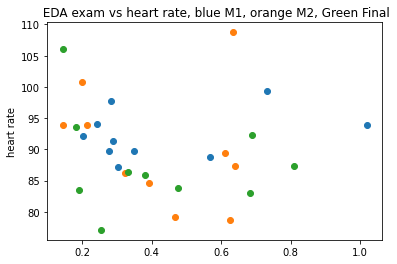

M1 EDA vs HR  R^2: 0.09589076419696546
M2 EDA vs HR  R^2: 0.03964370051306366
F  EDA vs HR  R^2: 0.052325121945819605


In [59]:
plt.plot(M1_EDA_mean_ex,M1_HR_mean_ex,'o',M2_EDA_mean_ex,M2_HR_mean_ex,'o',F_EDA_mean_ex,F_HR_mean_ex,'o')
plt.title(' EDA exam vs heart rate, blue M1, orange M2, Green Final')
plt.ylabel('heart rate')
plt.show()
linfit = linregress(M1_EDA_mean_ex, M1_HR_mean_ex)
r=linfit.rvalue
print('M1 EDA vs HR  R^2:', r*r)
linfit = linregress(M2_EDA_mean_ex, M2_HR_mean_ex)
r=linfit.rvalue
print('M2 EDA vs HR  R^2:', r*r)
linfit = linregress(F_EDA_mean_ex, F_HR_mean_ex)
r=linfit.rvalue
print('F  EDA vs HR  R^2:', r*r)

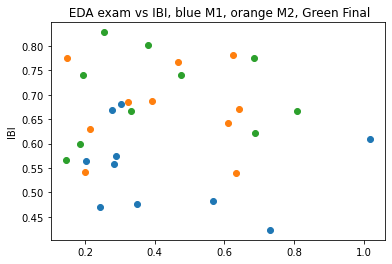

M1 EDA vs IBI  R^2: 0.028793003838670214
M2 EDA vs IBI  R^2: 1.0271948381739704e-05
F  EDA vs IBI  R^2: 0.007649558881931432


In [60]:
plt.plot(M1_EDA_mean_ex,M1_IB_mean_ex,'o',M2_EDA_mean_ex,M2_IB_mean_ex,'o',F_EDA_mean_ex,F_IB_mean_ex,'o')
plt.title(' EDA exam vs IBI, blue M1, orange M2, Green Final')
plt.ylabel('IBI')
plt.show()
linfit = linregress(M1_EDA_mean_ex, M1_IB_mean_ex)
r=linfit.rvalue
print('M1 EDA vs IBI  R^2:', r*r)
linfit = linregress(M2_EDA_mean_ex, M2_IB_mean_ex)
r=linfit.rvalue
print('M2 EDA vs IBI  R^2:', r*r)
linfit = linregress(F_EDA_mean_ex, F_IB_mean_ex)
r=linfit.rvalue
print('F  EDA vs IBI  R^2:', r*r)

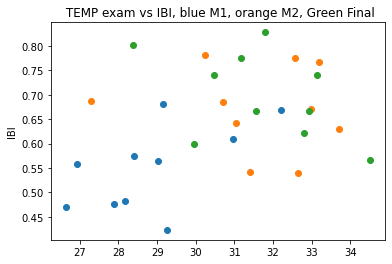

M1 TEMP vs IBI  R^2: 0.3421528241062657
M2 TEMP vs IBI  R^2: 0.010918512611015278
F  TEMP vs IBI  R^2: 0.22316398211803412


In [61]:
plt.plot(M1_TE_mean_ex,M1_IB_mean_ex,'o',M2_TE_mean_ex,M2_IB_mean_ex,'o',F_TE_mean_ex,F_IB_mean_ex,'o')
plt.title(' TEMP exam vs IBI, blue M1, orange M2, Green Final')
plt.ylabel('IBI')
plt.show()
linfit = linregress(M1_TE_mean_ex, M1_IB_mean_ex)
r=linfit.rvalue
print('M1 TEMP vs IBI  R^2:', r*r)
linfit = linregress(M2_TE_mean_ex, M2_IB_mean_ex)
r=linfit.rvalue
print('M2 TEMP vs IBI  R^2:', r*r)
linfit = linregress(F_TE_mean_ex, F_IB_mean_ex)
r=linfit.rvalue
print('F  TEMP vs IBI  R^2:', r*r)

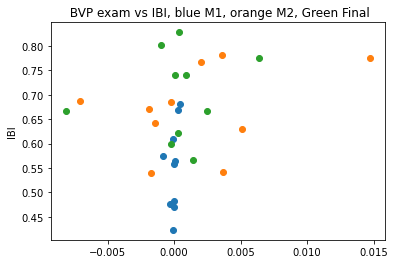

M1 BVP vs IBI  R^2: 0.12841902202824362
M2 BVP vs IBI  R^2: 0.118740822076451
F  BVP vs IBI  R^2: 0.023944866204525576


In [62]:
plt.plot(M1_BVP_mean_ex,M1_IB_mean_ex,'o',M2_BVP_mean_ex,M2_IB_mean_ex,'o',F_BVP_mean_ex,F_IB_mean_ex,'o')
plt.title(' BVP exam vs IBI, blue M1, orange M2, Green Final')
plt.ylabel('IBI')
plt.show()
linfit = linregress(M1_BVP_mean_ex, M1_IB_mean_ex)
r=linfit.rvalue
print('M1 BVP vs IBI  R^2:', r*r)
linfit = linregress(M2_BVP_mean_ex, M2_IB_mean_ex)
r=linfit.rvalue
print('M2 BVP vs IBI  R^2:', r*r)
linfit = linregress(F_BVP_mean_ex, F_IB_mean_ex)
r=linfit.rvalue
print('F  BVP vs IBI  R^2:', r*r)

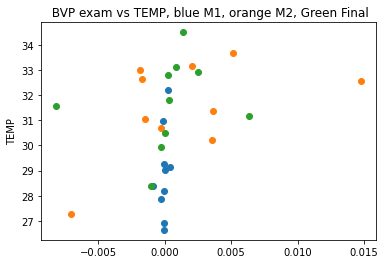

M1 BVP vs TEMP  R^2: 0.09839225430449587
M2 BVP vs TEMP  R^2: 0.2547211142926868
F  BVP vs TEMP  R^2: 0.03090893264025019


In [63]:
plt.plot(M1_BVP_mean_ex,M1_TE_mean_ex,'o',M2_BVP_mean_ex,M2_TE_mean_ex,'o',F_BVP_mean_ex,F_TE_mean_ex,'o')
plt.title(' BVP exam vs TEMP, blue M1, orange M2, Green Final')
plt.ylabel('TEMP')
plt.show()
linfit = linregress(M1_BVP_mean_ex, M1_TE_mean_ex)
r=linfit.rvalue
print('M1 BVP vs TEMP  R^2:', r*r)
linfit = linregress(M2_BVP_mean_ex, M2_TE_mean_ex)
r=linfit.rvalue
print('M2 BVP vs TEMP  R^2:', r*r)
linfit = linregress(F_BVP_mean_ex, F_TE_mean_ex)
r=linfit.rvalue
print('F  BVP vs TEMP  R^2:', r*r)

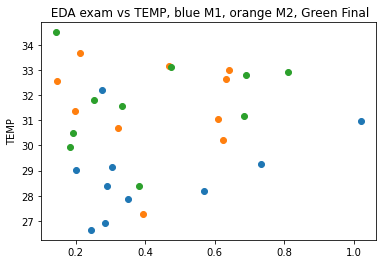

M1 EDA vs TEMP  R^2: 0.13887868559061867
M2 EDA vs TEMP  R^2: 0.004648693610899225
F  EDA vs TEMP  R^2: 0.03755691419843578


In [64]:
plt.plot(M1_EDA_mean_ex,M1_TE_mean_ex,'o',M2_EDA_mean_ex,M2_TE_mean_ex,'o',F_EDA_mean_ex,F_TE_mean_ex,'o')
plt.title(' EDA exam vs TEMP, blue M1, orange M2, Green Final')
plt.ylabel('TEMP')
plt.show()
linfit = linregress(M1_EDA_mean_ex, M1_TE_mean_ex)
r=linfit.rvalue
print('M1 EDA vs TEMP  R^2:', r*r)
linfit = linregress(M2_EDA_mean_ex, M2_TE_mean_ex)
r=linfit.rvalue
print('M2 EDA vs TEMP  R^2:', r*r)
linfit = linregress(F_EDA_mean_ex, F_TE_mean_ex)
r=linfit.rvalue
print('F  EDA vs TEMP  R^2:', r*r)

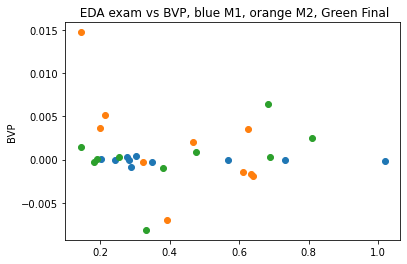

M1 EDA vs BVP  R^2: 0.00389743094038445
M2 EDA vs BVP  R^2: 0.33690461551636774
F  EDA vs BVP  R^2: 0.16357599634468267


In [65]:
plt.plot(M1_EDA_mean_ex,M1_BVP_mean_ex,'o',M2_EDA_mean_ex,M2_BVP_mean_ex,'o',F_EDA_mean_ex,F_BVP_mean_ex,'o')
plt.title(' EDA exam vs BVP, blue M1, orange M2, Green Final')
plt.ylabel('BVP')
plt.show()
linfit = linregress(M1_EDA_mean_ex, M1_BVP_mean_ex)
r=linfit.rvalue
print('M1 EDA vs BVP  R^2:', r*r)
linfit = linregress(M2_EDA_mean_ex, M2_BVP_mean_ex)
r=linfit.rvalue
print('M2 EDA vs BVP  R^2:', r*r)
linfit = linregress(F_EDA_mean_ex, F_BVP_mean_ex)
r=linfit.rvalue
print('F  EDA vs BVP  R^2:', r*r)

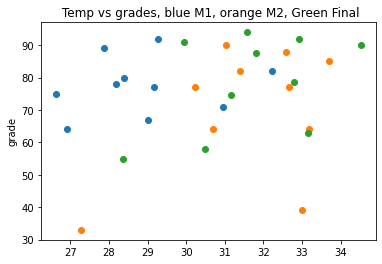

General accuracy of M1 TE Grade data:

y = 0.9268617684489999X + 50.749390569860765
R^2: 0.03175594696746054


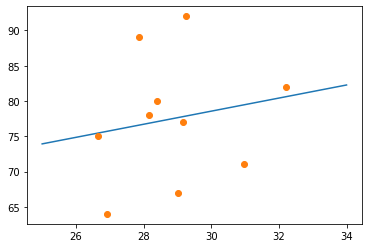

General accuracy of M2 TE Grade data:

y = 4.466101485811992X + -71.11387679225655
R^2: 0.18094956693250744


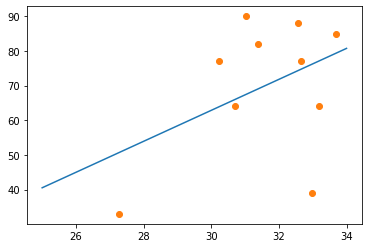

In [66]:
plt.plot(M1_TE_mean_ex,Grades[:,0],'o',M2_TE_mean_ex,Grades[:,1],'o',F_TE_mean_ex,Grade2[:,2],'o')
#plt.plot(M1_TE_mean,Grades[:,0],'+',M2_TE_mean,Grades[:,1],'+')
plt.title(' Temp vs grades, blue M1, orange M2, Green Final')
plt.ylabel('grade')
plt.show()

Y=range(25,35)
linfit = linregress(M1_TE_mean_ex, Grades[:,0])
print('General accuracy of M1 TE Grade data:\n')
a=linfit.slope
b=linfit.intercept
r=linfit.rvalue
print('y = {}X + {}'.format(a, b))
print('R^2:', r*r)
fit=a*Y+b
plt.plot(Y,fit,M1_TE_mean_ex,Grades[:,0],'o')
plt.show()
linfit = linregress(M2_TE_mean_ex, Grades[:,1])
print('General accuracy of M2 TE Grade data:\n')
a=linfit.slope
b=linfit.intercept
r=linfit.rvalue
print('y = {}X + {}'.format(linfit.slope, linfit.intercept))
print('R^2:', r*r)
fit=a*Y+b
plt.plot(Y,fit,M2_TE_mean_ex,Grades[:,1],'o')
plt.show()

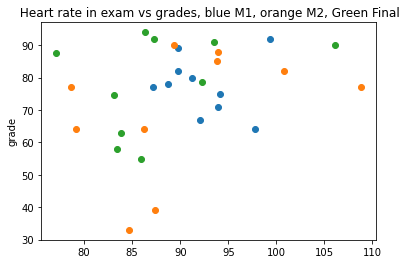

General accuracy of M1 HR Grade data:

y = -0.19872623308000223X + 95.85904504717662
R^2: 0.007728240843671547


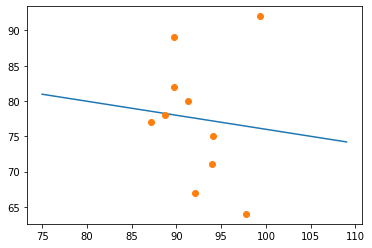

General accuracy of M2 HR Grade data:

y = 0.837394567044563X + -5.698981446567814
R^2: 0.15529181517430268


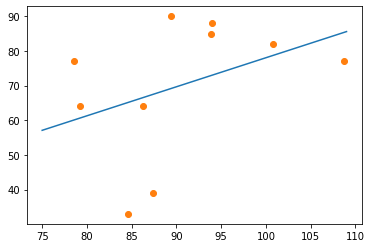

General accuracy of F HR Grade data:

y = 0.6534465820687595X + 20.92637757684745
R^2: 0.11918329988528269


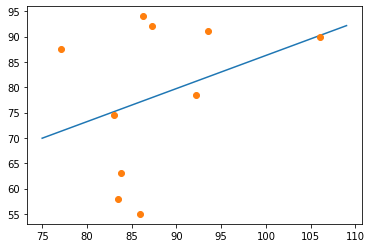

In [67]:
plt.plot(M1_HR_mean_ex,Grades[:,0],'o',M2_HR_mean_ex,Grades[:,1],'o',F_HR_mean_ex,Grade2[:,2],'o')
plt.title(' Heart rate in exam vs grades, blue M1, orange M2, Green Final')
plt.ylabel('grade')
plt.show()
Y=range(75,110)
linfit = linregress(M1_HR_mean_ex, Grades[:,0])
print('General accuracy of M1 HR Grade data:\n')
a=linfit.slope
b=linfit.intercept
r=linfit.rvalue
print('y = {}X + {}'.format(linfit.slope, linfit.intercept))
print('R^2:', r*r)
fit=a*Y+b
plt.plot(Y,fit,M1_HR_mean_ex,Grades[:,0],'o')
plt.show()
linfit = linregress(M2_HR_mean_ex, Grades[:,1])
print('General accuracy of M2 HR Grade data:\n')
a=linfit.slope
b=linfit.intercept
r=linfit.rvalue
print('y = {}X + {}'.format(linfit.slope, linfit.intercept))
print('R^2:', r*r)
fit=a*Y+b
plt.plot(Y,fit,M2_HR_mean_ex,Grades[:,1],'o')
plt.show()
linfit = linregress(F_HR_mean_ex, Grade2[:,2])
print('General accuracy of F HR Grade data:\n')
a=linfit.slope
b=linfit.intercept
r=linfit.rvalue
print('y = {}X + {}'.format(a, b))
print('R^2:', r*r)
fit=a*Y+b
plt.plot(Y,fit,F_HR_mean_ex,Grade2[:,2],'o')
plt.show()

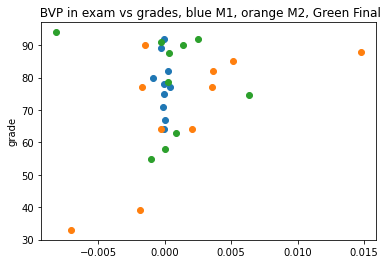

General accuracy of M1 BVP Grade data:

R^2: 0.4486835514690701
General accuracy of M2 BVP Grade data:

R^2: 0.42257617019675053
General accuracy of F BVP Grade data:

R^2: 0.03620587244833002


In [68]:
plt.plot(M1_BVP_mean_ex,Grades[:,0],'o',M2_BVP_mean_ex,Grades[:,1],'o',F_BVP_mean_ex,Grade2[:,2],'o')
plt.title(' BVP in exam vs grades, blue M1, orange M2, Green Final')
plt.ylabel('grade')
plt.show()

linfit = linregress(M1_BVP_mean_ex, Grades[:,1])
print('General accuracy of M1 BVP Grade data:\n')
r=linfit.rvalue
print('R^2:', r*r)
linfit = linregress(M2_BVP_mean_ex, Grades[:,1])
print('General accuracy of M2 BVP Grade data:\n')
r=linfit.rvalue
print('R^2:', r*r)
linfit = linregress(F_BVP_mean_ex, Grade2[:,2])
print('General accuracy of F BVP Grade data:\n')
r=linfit.rvalue
print('R^2:', r*r)

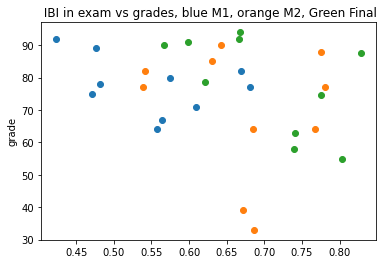

General accuracy of M1 IBI Grade data:

R^2: 4.868029031042283e-05
General accuracy of M2 IBI Grade data:

R^2: 0.020887915820142246
General accuracy of F IBI Grade data:

R^2: 0.31328885745362284


In [69]:
plt.plot(M1_IB_mean_ex,Grades[:,0],'o',M2_IB_mean_ex,Grades[:,1],'o',F_IB_mean_ex,Grade2[:,2],'o')
plt.title(' IBI in exam vs grades, blue M1, orange M2, Green Final')
plt.ylabel('grade')
plt.show()

linfit = linregress(M1_IB_mean_ex, Grades[:,1])
print('General accuracy of M1 IBI Grade data:\n')
r=linfit.rvalue
print('R^2:', r*r)
linfit = linregress(M2_IB_mean_ex, Grades[:,1])
print('General accuracy of M2 IBI Grade data:\n')
r=linfit.rvalue
print('R^2:', r*r)
linfit = linregress(F_IB_mean_ex, Grade2[:,2])
print('General accuracy of F IBI Grade data:\n')
r=linfit.rvalue
print('R^2:', r*r)

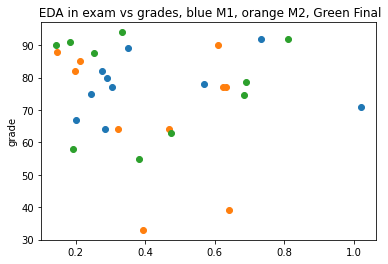

General accuracy of M1 EDA Grade data:

R^2: 0.016305585090275188
General accuracy of M2 EDA Grade data:

R^2: 0.07135859439565677
General accuracy of F EDA Grade data:

R^2: 2.9885971029376963e-06


In [70]:
plt.plot(M1_EDA_mean_ex,Grades[:,0],'o',M2_EDA_mean_ex,Grades[:,1],'o',F_EDA_mean_ex,Grade2[:,2],'o')
plt.title(' EDA in exam vs grades, blue M1, orange M2, Green Final')
plt.ylabel('grade')
plt.show()

linfit = linregress(M1_EDA_mean_ex, Grades[:,1])
print('General accuracy of M1 EDA Grade data:\n')
r=linfit.rvalue
print('R^2:', r*r)
linfit = linregress(M2_EDA_mean_ex, Grades[:,1])
print('General accuracy of M2 EDA Grade data:\n')
r=linfit.rvalue
print('R^2:', r*r)
linfit = linregress(F_EDA_mean_ex, Grade2[:,2])
print('General accuracy of F EDA Grade data:\n')
r=linfit.rvalue
print('R^2:', r*r)

In [71]:
linfit = linregress(M2_HR_mean_af, Grades[:,1])
r=linfit.rvalue
print('M2 HR after R^2:', r*r)
linfit = linregress(M2_HR_mean, Grades[:,1])
r=linfit.rvalue
print('M2 HR all R^2:', r*r)
linfit = linregress(M2_HR_mean_ex, Grades[:,1])
r=linfit.rvalue
print('M2 HR exam R^2:', r*r)

M2 HR after R^2: 0.07094768270092584
M2 HR all R^2: 0.02279361879805396
M2 HR exam R^2: 0.15529181517430268


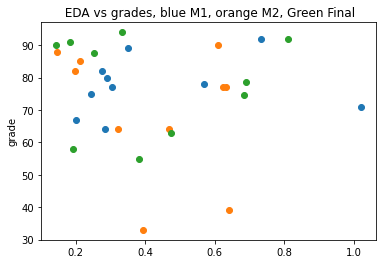

M1 EDA vs Grade  R^2: 0.028282787324456524
M2 EDA vs grade  R^2: 0.07135859439565677
F  EDA vs grade  R^2: 2.9885971029376963e-06


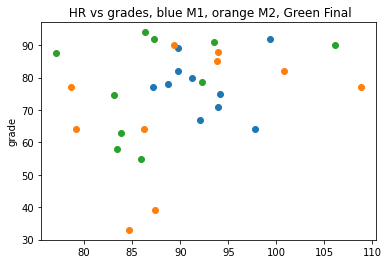

M1 HR vs Grade  R^2: 0.007728240843671547
M2 HR vs grade  R^2: 0.15529181517430268
F  HR vs grade  R^2: 0.11918329988528269


In [72]:
plt.plot(M1_EDA_mean_ex,Grades[:,0],'o',M2_EDA_mean_ex,Grades[:,1],'o',F_EDA_mean_ex,Grade2[:,2],'o')
plt.title(' EDA vs grades, blue M1, orange M2, Green Final')
plt.ylabel('grade')
plt.show()
linfit = linregress(M1_EDA_mean_ex, Grades[:,0])
r=linfit.rvalue
print('M1 EDA vs Grade  R^2:', r*r)
linfit = linregress(M2_EDA_mean_ex, Grades[:,1])
r=linfit.rvalue
print('M2 EDA vs grade  R^2:', r*r)
linfit = linregress(F_EDA_mean_ex, Grade2[:,2])
r=linfit.rvalue
print('F  EDA vs grade  R^2:', r*r)
plt.plot(M1_HR_mean_ex,Grades[:,0],'o',M2_HR_mean_ex,Grades[:,1],'o',F_HR_mean_ex,Grade2[:,2],'o')
plt.title(' HR vs grades, blue M1, orange M2, Green Final')
plt.ylabel('grade')
plt.show()
linfit = linregress(M1_HR_mean_ex, Grades[:,0])
r=linfit.rvalue
print('M1 HR vs Grade  R^2:', r*r)
linfit = linregress(M2_HR_mean_ex, Grades[:,1])
r=linfit.rvalue
print('M2 HR vs grade  R^2:', r*r)
linfit = linregress(F_HR_mean_ex, Grade2[:,2])
r=linfit.rvalue
print('F  HR vs grade  R^2:', r*r)

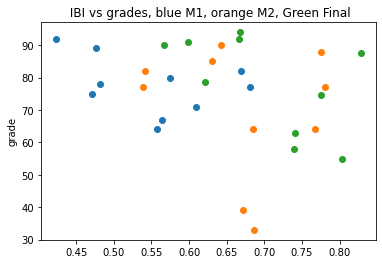

M1 IBI vs Grade  R^2: 0.14040161236844081
M2 IBI vs grade  R^2: 0.020887915820142246
F  IBI vs grade  R^2: 0.31328885745362284


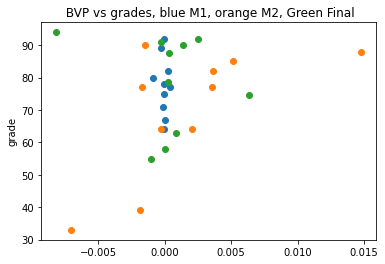

M1 BVP vs Grade  R^2: 0.02782214178057506
M2 BVP vs grade  R^2: 0.42257617019675053
F  BVP vs grade  R^2: 0.03620587244833002


In [73]:
plt.plot(M1_IB_mean_ex,Grades[:,0],'o',M2_IB_mean_ex,Grades[:,1],'o',F_IB_mean_ex,Grade2[:,2],'o')
plt.title(' IBI vs grades, blue M1, orange M2, Green Final')
plt.ylabel('grade')
plt.show()
linfit = linregress(M1_IB_mean_ex, Grades[:,0])
r=linfit.rvalue
print('M1 IBI vs Grade  R^2:', r*r)
linfit = linregress(M2_IB_mean_ex, Grades[:,1])
r=linfit.rvalue
print('M2 IBI vs grade  R^2:', r*r)
linfit = linregress(F_IB_mean_ex, Grade2[:,2])
r=linfit.rvalue
print('F  IBI vs grade  R^2:', r*r)

plt.plot(M1_BVP_mean_ex,Grades[:,0],'o',M2_BVP_mean_ex,Grades[:,1],'o',F_BVP_mean_ex,Grade2[:,2],'o')
plt.title(' BVP vs grades, blue M1, orange M2, Green Final')
plt.ylabel('grade')
plt.show()
linfit = linregress(M1_BVP_mean_ex, Grades[:,0])
r=linfit.rvalue
print('M1 BVP vs Grade  R^2:', r*r)
linfit = linregress(M2_BVP_mean_ex, Grades[:,1])
r=linfit.rvalue
print('M2 BVP vs grade  R^2:', r*r)
linfit = linregress(F_BVP_mean_ex, Grade2[:,2])
r=linfit.rvalue
print('F  BVP vs grade  R^2:', r*r)

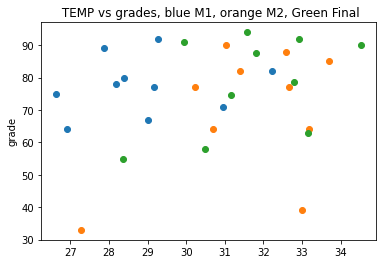

M1 TEMP vs Grade  R^2: 0.03175594696746054
M2 TEMP vs grade  R^2: 0.18094956693250744
F  TEMP vs grade  R^2: 0.20395733303246472


In [74]:
plt.plot(M1_TE_mean_ex,Grades[:,0],'o',M2_TE_mean_ex,Grades[:,1],'o',F_TE_mean_ex,Grade2[:,2],'o')
plt.title(' TEMP vs grades, blue M1, orange M2, Green Final')
plt.ylabel('grade')
plt.show()
linfit = linregress(M1_TE_mean_ex, Grades[:,0])
r=linfit.rvalue
print('M1 TEMP vs Grade  R^2:', r*r)
linfit = linregress(M2_TE_mean_ex, Grades[:,1])
r=linfit.rvalue
print('M2 TEMP vs grade  R^2:', r*r)
linfit = linregress(F_TE_mean_ex, Grade2[:,2])
r=linfit.rvalue
print('F  TEMP vs grade  R^2:', r*r)

In [75]:
for i in range(len(M1_EDA)):
  print('studet',i,'points',len(M1_EDA[i]),' freq',M1_EDA_fr[i],'HZ, total time',len(M1_EDA[i])/M1_EDA_fr[i],
        's, start time ',datetime.datetime.fromtimestamp(M1_EDA_time[i]))

for i in range(len(M1_BVP)):
  print('student',i,'points',len(M1_BVP[i]),' freq',M1_BVP_fr[i],'HZ, total time',len(M1_BVP[i])/M1_BVP_fr[i],
        's,  start time ',datetime.datetime.fromtimestamp(M1_BVP_time[i]))

studet 0 points 44712  freq 4.0 HZ, total time 11178.0 s, start time  2018-10-13 15:56:06
studet 1 points 47934  freq 4.0 HZ, total time 11983.5 s, start time  2018-10-13 15:55:45
studet 2 points 48852  freq 4.0 HZ, total time 12213.0 s, start time  2018-10-13 15:56:48
studet 3 points 46776  freq 4.0 HZ, total time 11694.0 s, start time  2018-10-13 15:56:19
studet 4 points 48006  freq 4.0 HZ, total time 12001.5 s, start time  2018-10-13 15:55:21
studet 5 points 44610  freq 4.0 HZ, total time 11152.5 s, start time  2018-10-13 15:57:13
studet 6 points 49536  freq 4.0 HZ, total time 12384.0 s, start time  2018-10-13 15:56:47
studet 7 points 43122  freq 4.0 HZ, total time 10780.5 s, start time  2018-10-13 15:56:20
studet 8 points 50724  freq 4.0 HZ, total time 12681.0 s, start time  2018-10-13 15:56:05
studet 9 points 46746  freq 4.0 HZ, total time 11686.5 s, start time  2018-10-13 15:55:25
student 0 points 715407  freq 64.0 HZ, total time 11178.234375 s,  start time  2018-10-13 15:56:06
s

In [76]:
M1_EDA_long=[]
M2_EDA_long=[]
F_EDA_long=[]
for exam in ['M1','M2','F']:
    if exam == 'M1':
        bvp_name = M1_BVP
        eda_name = M1_EDA
        long_name = M1_EDA_long
    if exam == 'M2':
        bvp_name = M2_BVP
        eda_name = M2_EDA
        long_name = M2_EDA_long
    if exam == 'F':
        bvp_name = F_BVP
        eda_name = F_EDA
        long_name = F_EDA_long
    for i in range(len(bvp_name)):
      arr_long=[]
      for k in range(len(bvp_name[i])):
        kslow=min(int(M1_EDA_fr[i]*k/64),len(eda_name[i])-1)  # goes 16 times slower, if k/16 goes over take the last point
        arr_long.append(eda_name[i][kslow])
      print(len(arr_long), 'EDA should be same as BVP len, student',i,exam)
      long_name.append(arr_long)

    
M1_HR_long=[]
M2_HR_long=[]
F_HR_long=[]
for exam in ['M1','M2','F']:
    if exam == 'M1':
        bvp_name = M1_BVP
        hr_name = M1_HR
        long_name =M1_HR_long
    if exam == 'M2':
        bvp_name = M2_BVP
        hr_name = M2_HR
        long_name = M2_HR_long
    if exam == 'F':
        bvp_name = F_BVP
        hr_name = F_HR
        long_name = F_HR_long
    for i in range(len(bvp_name)):
        arr_long=[]
        for k in range(len(bvp_name[i])):
            kslow=min(int(M1_HR_fr[i]*k/64),len(hr_name[i])-1)  # goes 64 times slower, if k/16 goes over take the last point
            arr_long.append(hr_name[i][kslow])
        print(len(arr_long), 'HR should be same as BVP len, student',i,exam)
        long_name.append(arr_long)
    
    
M1_TE_long=[]
M2_TE_long=[]
F_TE_long=[]
for exam in ['M1','M2','F']:
    if exam == 'M1':
        bvp_name = M1_BVP
        te_name = M1_TE
        long_name = M1_TE_long
    if exam == 'M2':
        bvp_name = M2_BVP
        te_name = M2_TE
        long_name = M2_TE_long
    if exam == 'F':
        bvp_name = F_BVP
        te_name = F_TE
        long_name = F_TE_long
    for i in range(len(bvp_name)):
        arr_long=[]
        for k in range(len(bvp_name[i])):
            kslow=min(int(M1_TE_fr[i]*k/64),len(te_name[i])-1)  # goes 16 times slower, if k/16 goes over take the last point
            arr_long.append(te_name[i][kslow])
        print(len(arr_long), 'TE should be same as BVP len, student',i,exam)
        long_name.append(arr_long)

715407 EDA should be same as BVP len, student 0 M1
766997 EDA should be same as BVP len, student 1 M1
781627 EDA should be same as BVP len, student 2 M1
748396 EDA should be same as BVP len, student 3 M1
768075 EDA should be same as BVP len, student 4 M1
713823 EDA should be same as BVP len, student 5 M1
792550 EDA should be same as BVP len, student 6 M1
689942 EDA should be same as BVP len, student 7 M1
811624 EDA should be same as BVP len, student 8 M1
747978 EDA should be same as BVP len, student 9 M1
712745 EDA should be same as BVP len, student 0 M2
888635 EDA should be same as BVP len, student 1 M2
655677 EDA should be same as BVP len, student 2 M2
857142 EDA should be same as BVP len, student 3 M2
769043 EDA should be same as BVP len, student 4 M2
908160 EDA should be same as BVP len, student 5 M2
692087 EDA should be same as BVP len, student 6 M2
637538 EDA should be same as BVP len, student 7 M2
795619 EDA should be same as BVP len, student 8 M2
831490 EDA should be same as BV

In [77]:
M1_IBI_long=[]
M2_IBI_long=[]
F_IBI_long=[]
for exam in ['M1','M2','F']:
    if exam == 'M1':
        bvp_name = M1_BVP
        ibi_name = M1_IB
        ibi_stime = M1_IB_stime
    if exam == 'M2':
        bvp_name = M2_BVP
        ibi_name = M2_IB
        ibi_stime = M2_IB_stime
    if exam == 'F':
        bvp_name = F_BVP
        ibi_name = F_IB
        ibi_stime = F_IB_stime
    for i in range(10):
        arr_long=[]
        it=0
        for k in range(len(bvp_name[i])):     # k on bvp pituus
            bvp_time=k/64
            if it == 0:
                if bvp_time < ibi_stime[i][it]:
                    arr_long.append(0)
                elif bvp_time >= ibi_stime[i][it]:
                    arr_long.append(ibi_name[i][it])
                    it=it+1
            else:
                if bvp_time < ibi_stime[i][it]:
                    arr_long.append(arr_long[-1])
                elif bvp_time >= ibi_stime[i][it]:
                    if it < len(ibi_name[i])-1:
                        arr_long.append(ibi_name[i][it])
                        it=it+1
                        #print(it,bvp_time)
                    else:
                        arr_long.append(0)
                
        print(len(arr_long), 'IBI should be same as BVP len, student',i,exam)
        #print('arr long 25563',arr_long[25563:25566],ibi_stime[0][155])
        if exam == 'M1':
            M1_IBI_long.append(arr_long)
            #print('M1',len(M1_IBI_long))
        if exam == 'M2':
            M2_IBI_long.append(arr_long)
            #print('M2',len(M2_IBI_long))
        if exam == 'F':
            F_IBI_long.append(arr_long)
            #print('F',len(F_IBI_long))


715407 IBI should be same as BVP len, student 0 M1
766997 IBI should be same as BVP len, student 1 M1
781627 IBI should be same as BVP len, student 2 M1
748396 IBI should be same as BVP len, student 3 M1
768075 IBI should be same as BVP len, student 4 M1
713823 IBI should be same as BVP len, student 5 M1
792550 IBI should be same as BVP len, student 6 M1
689942 IBI should be same as BVP len, student 7 M1
811624 IBI should be same as BVP len, student 8 M1
747978 IBI should be same as BVP len, student 9 M1
712745 IBI should be same as BVP len, student 0 M2
888635 IBI should be same as BVP len, student 1 M2
655677 IBI should be same as BVP len, student 2 M2
857142 IBI should be same as BVP len, student 3 M2
769043 IBI should be same as BVP len, student 4 M2
908160 IBI should be same as BVP len, student 5 M2
692087 IBI should be same as BVP len, student 6 M2
637538 IBI should be same as BVP len, student 7 M2
795619 IBI should be same as BVP len, student 8 M2
831490 IBI should be same as BV

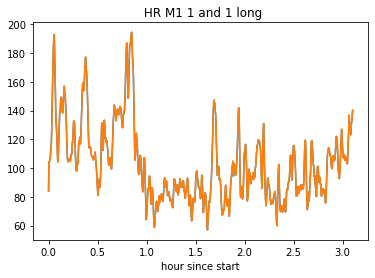

In [78]:
#testi, että välikokeen 1 HR ja HR long ovat samanlaiset
x1=[]
for i in range(len(M1_HR[0])):
  x1.append(i/M1_HR_fr[0]/3600)

x2=[]
for i in range(len(M1_HR_long[0])):
  x2.append(i/M1_BVP_fr[0]/3600)

plt.plot(x1,M1_HR[0],x2,M1_HR_long[0])
plt.title(' HR M1 1 and 1 long')
plt.xlabel('hour since start')
plt.show()

In [79]:
import csv

for stud in range(10):
    x2=[]
    for i in range(len(M1_EDA_long[stud])):
      x2.append(i/M1_BVP_fr[stud])

    with open('S'+str(stud)+'_M1_2.csv', 'w', newline='') as csvfile:
        dataw = csv.writer(csvfile)
        dataw.writerow(['time in s', 'BVP', 'EDA', 'HR', 'TE', 'IBI' ])
        for i in range(len(M1_BVP[stud])):
           dataw.writerow([x2[i],M1_BVP[stud][i],M1_EDA_long[stud][i],M1_HR_long[stud][i],M1_TE_long[stud][i],M1_IBI_long[stud][i]])
    print(len(M1_BVP[stud]),' lines written to file S'+str(stud)+'_M1_2.csv')
    
    x2=[]
    for i in range(len(M2_EDA_long[stud])):
      x2.append(i/M2_BVP_fr[stud])

    with open('S'+str(stud)+'_M2_2.csv', 'w', newline='') as csvfile:
        dataw = csv.writer(csvfile)
        dataw.writerow(['time in s', 'BVP', 'EDA', 'HR', 'TE', 'IBI' ])
        for i in range(len(M2_BVP[stud])):
           dataw.writerow([x2[i],M2_BVP[stud][i],M2_EDA_long[stud][i],M2_HR_long[stud][i],M2_TE_long[stud][i],M2_IBI_long[stud][i]])
    print(len(M2_BVP[stud]),' lines written to file S'+str(stud)+'_M2_2.csv')
    
    x2=[]
    for i in range(len(F_EDA_long[stud])):
      x2.append(i/F_BVP_fr[stud])

    with open('S'+str(stud)+'_F_2.csv', 'w', newline='') as csvfile:
        dataw = csv.writer(csvfile)
        dataw.writerow(['time in s', 'BVP', 'EDA', 'HR', 'TE', 'IBI' ])
        for i in range(len(F_BVP[stud])):
           dataw.writerow([x2[i],F_BVP[stud][i],F_EDA_long[stud][i],F_HR_long[stud][i],F_TE_long[stud][i],F_IBI_long[stud][i]])
    print(len(F_BVP[stud]),' lines written to file S'+str(stud)+'_F_2.csv')
    

715407  lines written to file S0_M1_2.csv
712745  lines written to file S0_M2_2.csv
1497375  lines written to file S0_F_2.csv
766997  lines written to file S1_M1_2.csv
888635  lines written to file S1_M2_2.csv
1621554  lines written to file S1_F_2.csv
781627  lines written to file S2_M1_2.csv
655677  lines written to file S2_M2_2.csv
1652607  lines written to file S2_F_2.csv
748396  lines written to file S3_M1_2.csv
857142  lines written to file S3_M2_2.csv
1018666  lines written to file S3_F_2.csv
768075  lines written to file S4_M1_2.csv
769043  lines written to file S4_M2_2.csv
975964  lines written to file S4_F_2.csv
713823  lines written to file S5_M1_2.csv
908160  lines written to file S5_M2_2.csv
1530969  lines written to file S5_F_2.csv
792550  lines written to file S6_M1_2.csv
692087  lines written to file S6_M2_2.csv
1257531  lines written to file S6_F_2.csv
689942  lines written to file S7_M1_2.csv
637538  lines written to file S7_M2_2.csv
1145397  lines written to file S7_F

In [80]:
ex_start_s_M1=[]
for i in range(10):
    start_sec = unix_M1-M1_TE_time[i]
    ex_start_s_M1.append(start_sec)
print('exam start time in seconds for M1',ex_start_s_M1)

ex_start_s_M2=[]
for i in range(10):
    start_sec = unix_M2-M2_TE_time[i]
    ex_start_s_M2.append(start_sec)
print('exam start time in seconds for M2',ex_start_s_M2)

ex_start_s_F=[]
for i in range(10):
    start_sec = unix_F-F_TE_time[i]
    ex_start_s_F.append(start_sec)
print('exam start time in seconds for F',ex_start_s_F)

exam start time in seconds for M1 [3834.0, 3855.0, 3792.0, 3821.0, 3879.0, 3767.0, 3793.0, 3820.0, 3835.0, 3875.0]
exam start time in seconds for M2 [2445.0, 2551.0, 2606.0, 2467.0, 2502.0, 2512.0, 2597.0, 2616.0, 2545.0, 2475.0]
exam start time in seconds for F [963.0, 956.0, 966.0, 958.0, 966.0, 953.0, 964.0, 961.0, 953.0, 966.0]


In [81]:
ex_end_s_M1=[]
for i in range(10):
    end_sec = ex_start_s_M1[i] + 5400
    ex_end_s_M1.append(end_sec)
print('exam end time in seconds for M1', ex_end_s_M1)

ex_end_s_M2=[]
for i in range(10):
    end_sec = ex_start_s_M2[i] + 5400
    ex_end_s_M2.append(end_sec)
print('exam end time in seconds for M2', ex_end_s_M2)

ex_end_s_F=[]
for i in range(10):
    end_sec = ex_start_s_F[i] + 5400*2
    ex_end_s_F.append(end_sec)
print('exam end time in seconds for F', ex_end_s_F)

exam end time in seconds for M1 [9234.0, 9255.0, 9192.0, 9221.0, 9279.0, 9167.0, 9193.0, 9220.0, 9235.0, 9275.0]
exam end time in seconds for M2 [7845.0, 7951.0, 8006.0, 7867.0, 7902.0, 7912.0, 7997.0, 8016.0, 7945.0, 7875.0]
exam end time in seconds for F [11763.0, 11756.0, 11766.0, 11758.0, 11766.0, 11753.0, 11764.0, 11761.0, 11753.0, 11766.0]


In [82]:
import csv
for exam in ['M1','M2','F']:
    for stud in range(10):
        lines = list()
        with open('S'+str(stud)+'_'+str(exam)+'_2.csv', 'r', newline='') as file:
            reader = csv.reader(file, delimiter=',')
            next(reader) #hyppää ensimmäisen rivin yli
            for row in reader:
                if exam == 'M1':
                    if (float(row[0])>=ex_start_s_M1[stud]) and (float(row[0])<=ex_end_s_M1[stud]):
                        lines.append(row)
                if exam == 'M2':
                    if (float(row[0])>=ex_start_s_M2[stud]) and (float(row[0])<=ex_end_s_M2[stud]):
                        lines.append(row)
                if exam == 'F':
                    if (float(row[0])>=ex_start_s_F[stud]) and (float(row[0])<=ex_end_s_F[stud]):
                        lines.append(row)


        with open('exam_S'+str(stud)+'_'+str(exam)+'.csv', 'w', newline='') as write_file:
            writer = csv.writer(write_file)
            writer.writerow(['time in s', 'BVP', 'EDA', 'HR', 'TE', 'IBI' ])
            writer.writerows(lines)
        print('new file written exam_S'+str(stud)+'_'+str(exam)+'.csv')

new file written exam_S0_M1.csv
new file written exam_S1_M1.csv
new file written exam_S2_M1.csv
new file written exam_S3_M1.csv
new file written exam_S4_M1.csv
new file written exam_S5_M1.csv
new file written exam_S6_M1.csv
new file written exam_S7_M1.csv
new file written exam_S8_M1.csv
new file written exam_S9_M1.csv
new file written exam_S0_M2.csv
new file written exam_S1_M2.csv
new file written exam_S2_M2.csv
new file written exam_S3_M2.csv
new file written exam_S4_M2.csv
new file written exam_S5_M2.csv
new file written exam_S6_M2.csv
new file written exam_S7_M2.csv
new file written exam_S8_M2.csv
new file written exam_S9_M2.csv
new file written exam_S0_F.csv
new file written exam_S1_F.csv
new file written exam_S2_F.csv
new file written exam_S3_F.csv
new file written exam_S4_F.csv
new file written exam_S5_F.csv
new file written exam_S6_F.csv
new file written exam_S7_F.csv
new file written exam_S8_F.csv
new file written exam_S9_F.csv


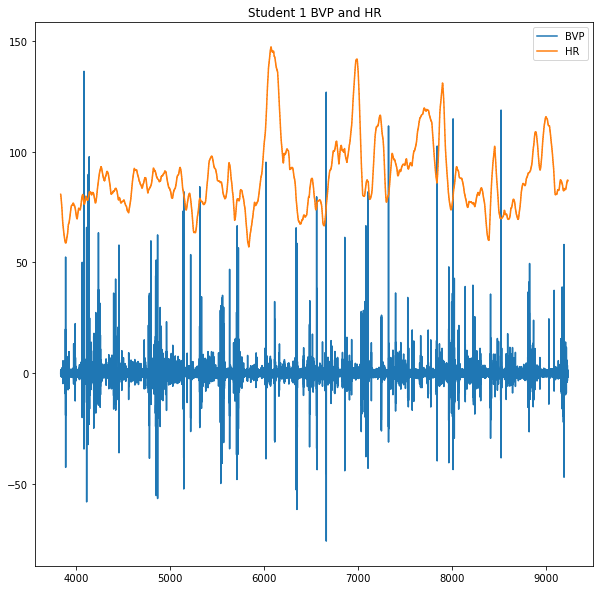

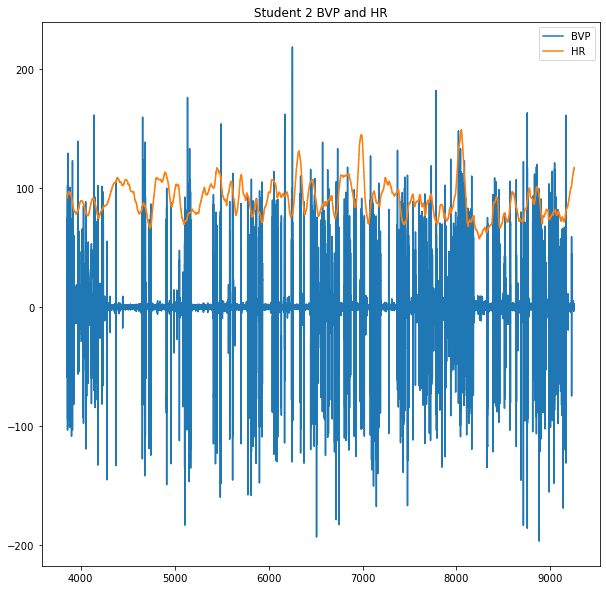

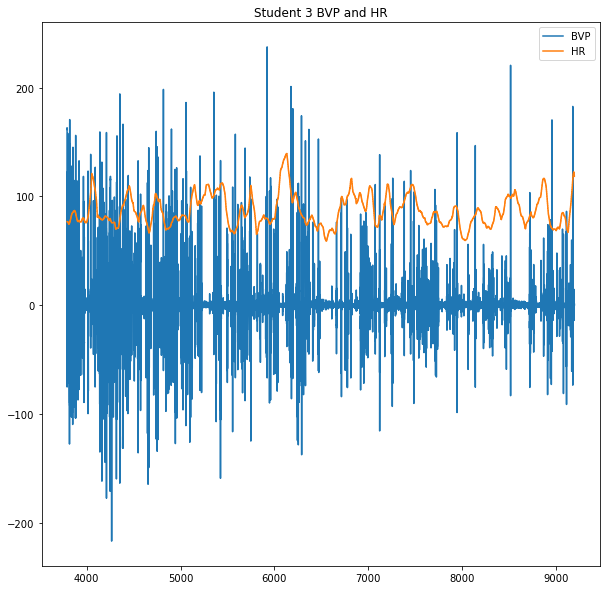

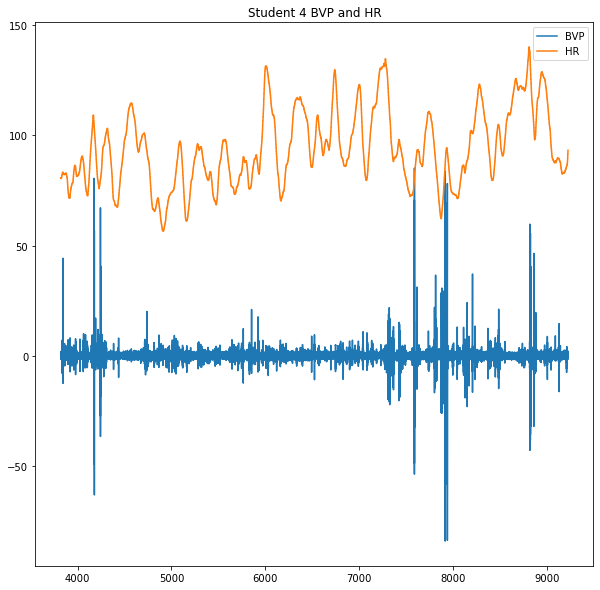

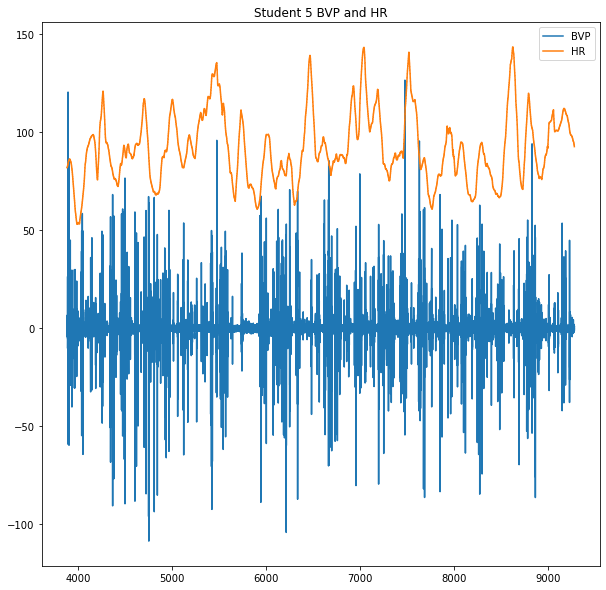

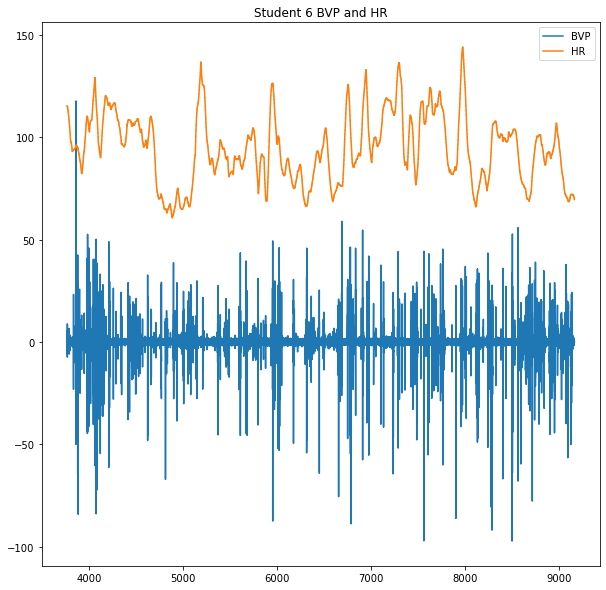

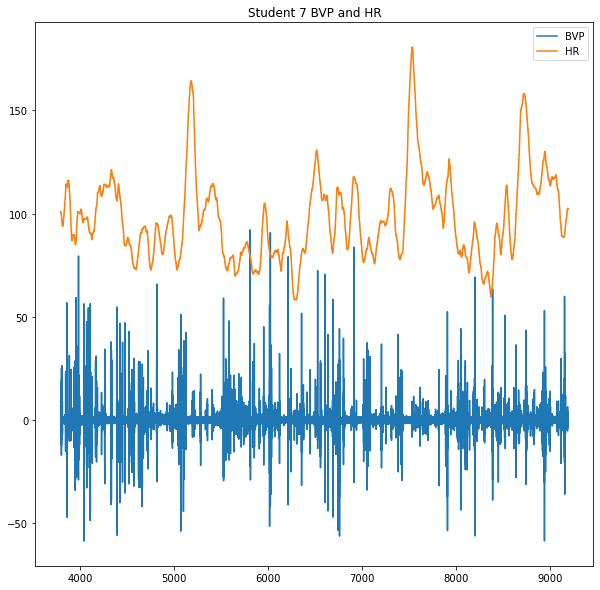

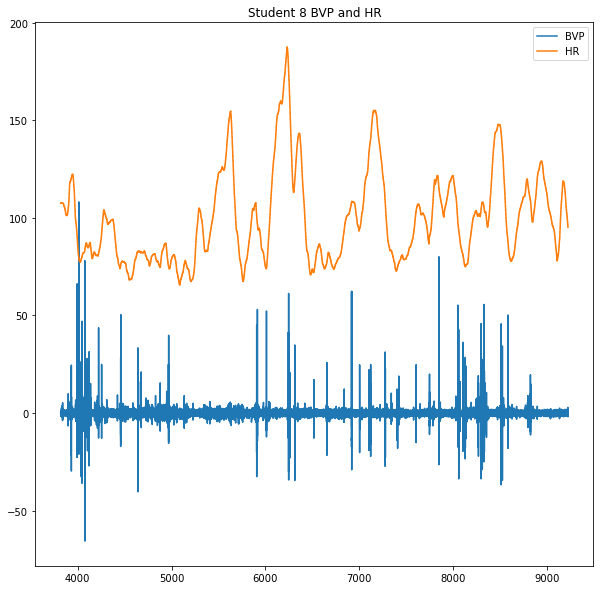

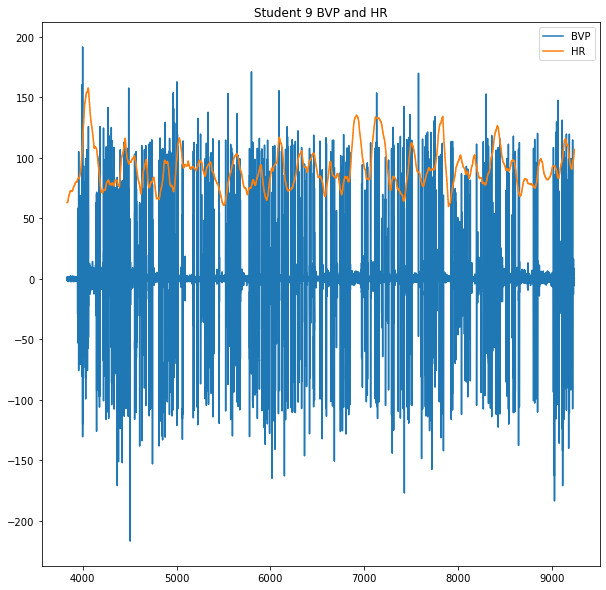

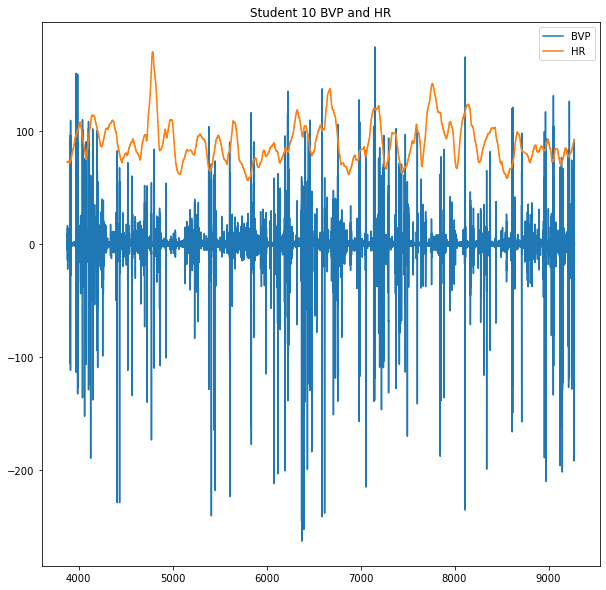

In [83]:
for stud in range(10):
    data = np.loadtxt('exam_S'+str(stud)+'_M1.csv', delimiter=',', skiprows=1)
    time = data[:,0]
    BVP = data[:,1]
    HR = data[:,3]

    fig, ax = plt.subplots(figsize=(10,10))

    ax.plot(time, BVP, label='BVP')
    ax.plot(time, HR, label='HR')
    plt.title('Student '+str(stud+1)+' BVP and HR')
    plt.legend()

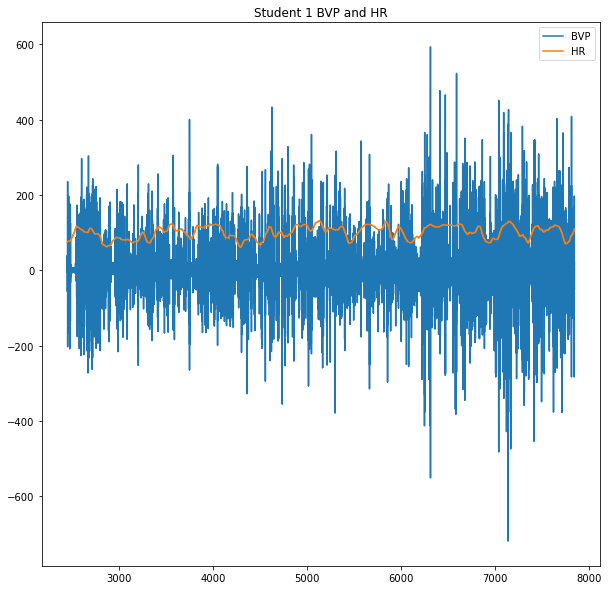

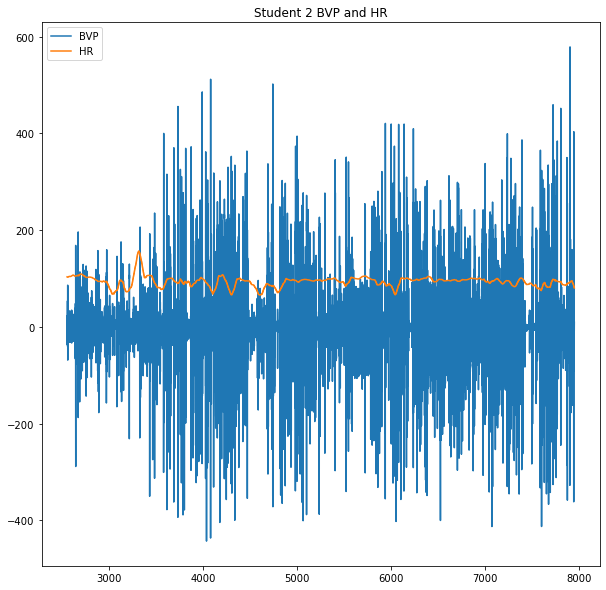

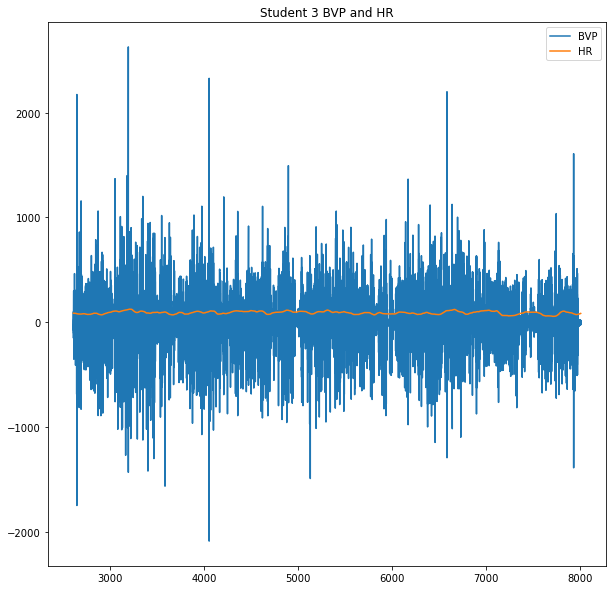

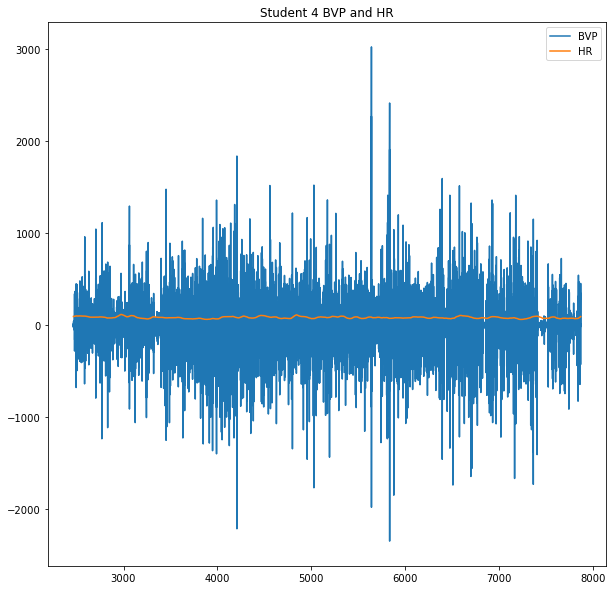

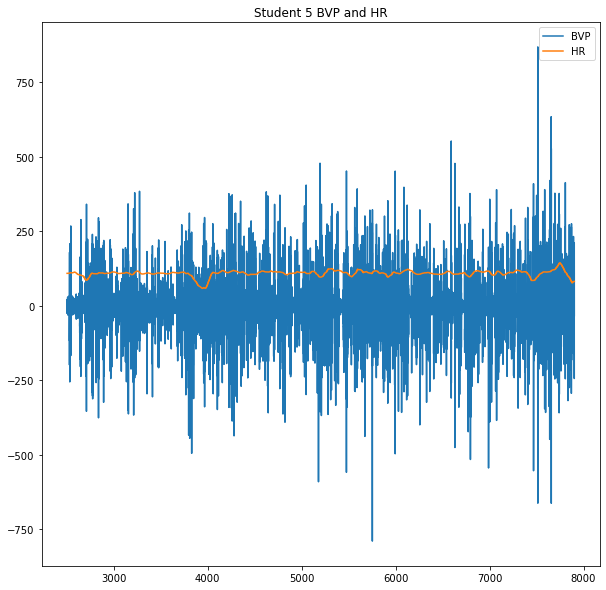

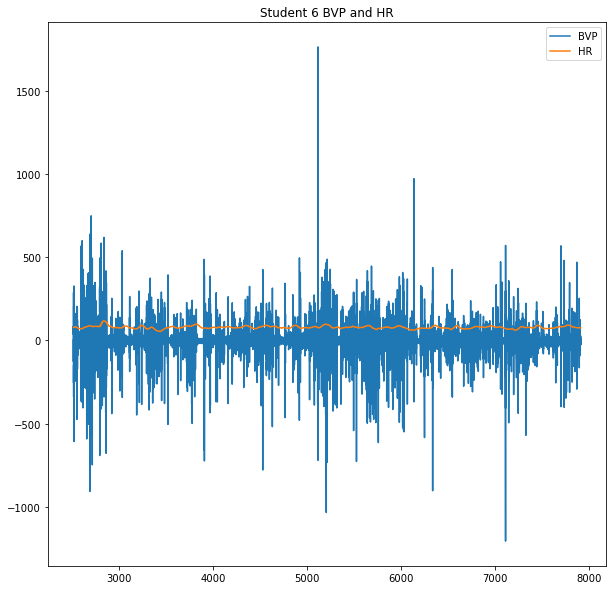

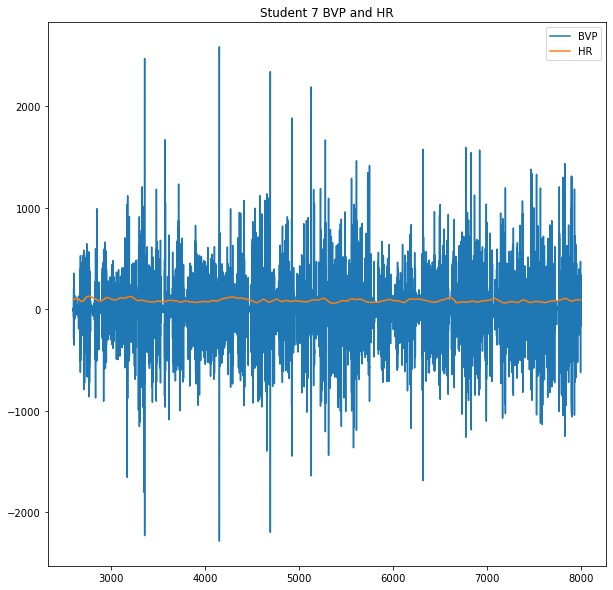

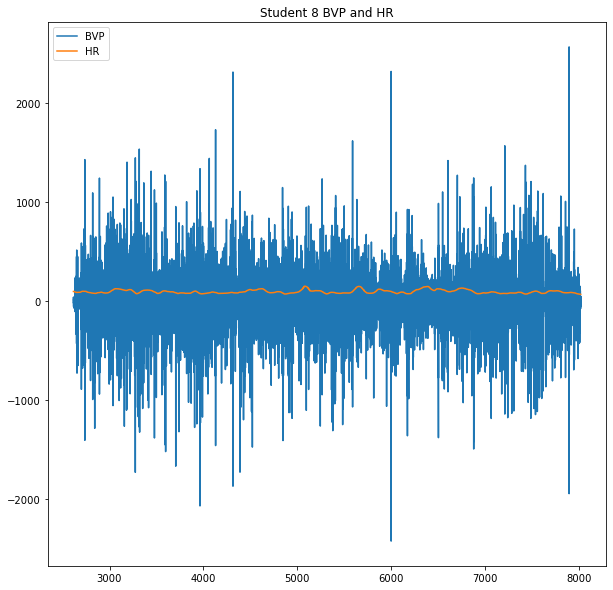

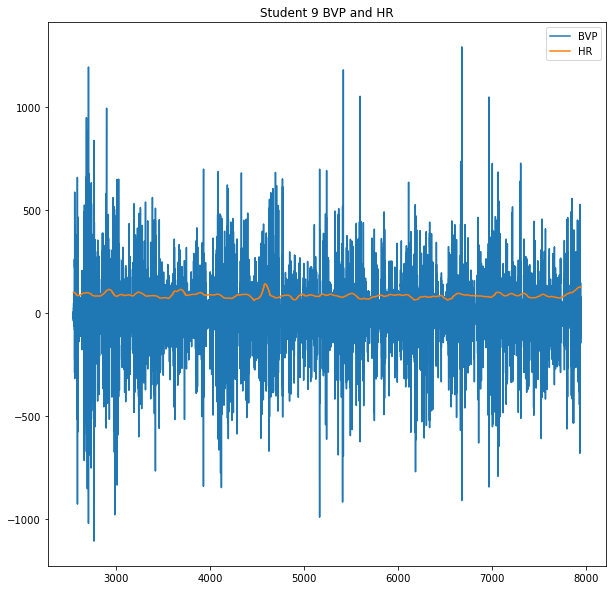

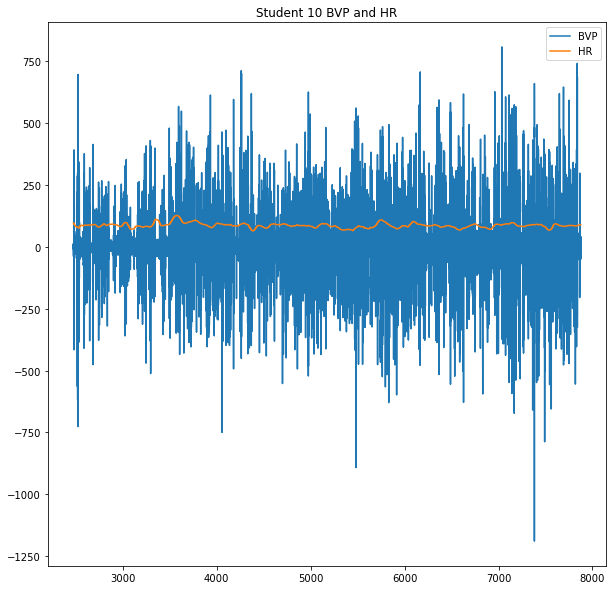

In [84]:
for stud in range(10):
    data = np.loadtxt('exam_S'+str(stud)+'_M2.csv', delimiter=',', skiprows=1)
    time = data[:,0]
    BVP = data[:,1]
    HR = data[:,3]

    fig, ax = plt.subplots(figsize=(10,10))

    ax.plot(time, BVP, label='BVP')
    ax.plot(time, HR, label='HR')
    plt.title('Student '+str(stud+1)+' BVP and HR')
    plt.legend()

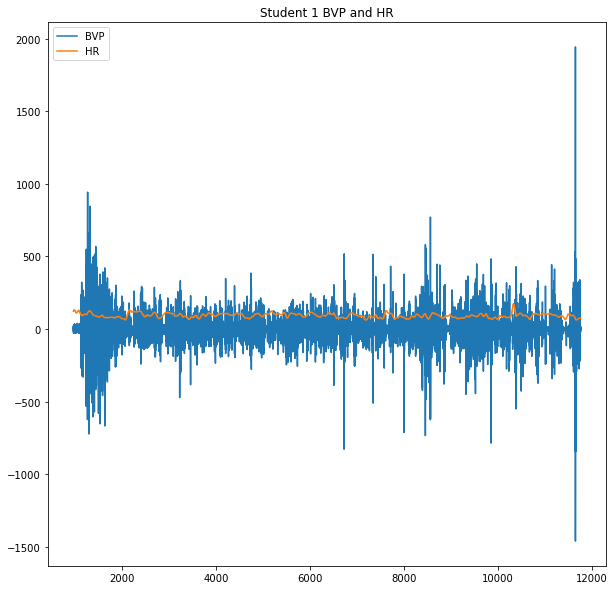

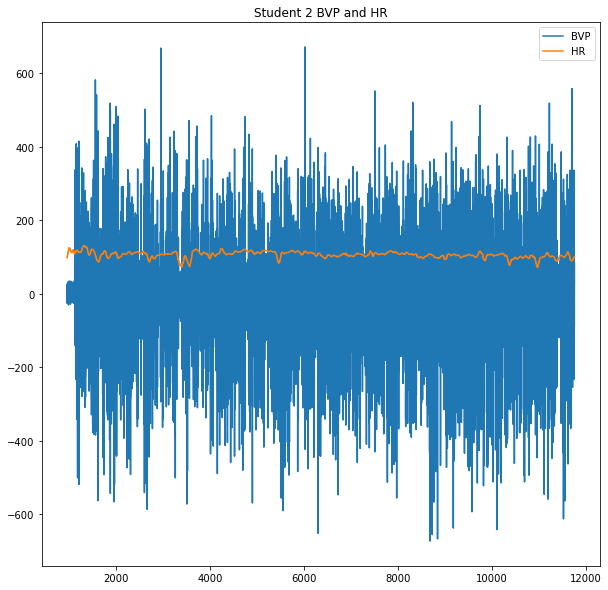

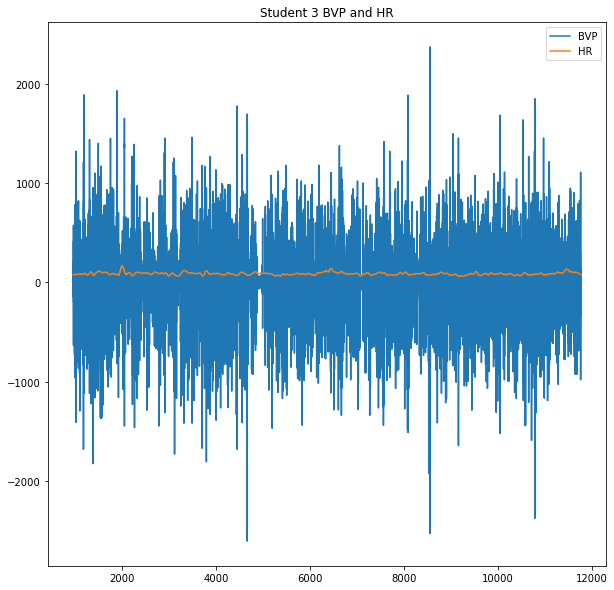

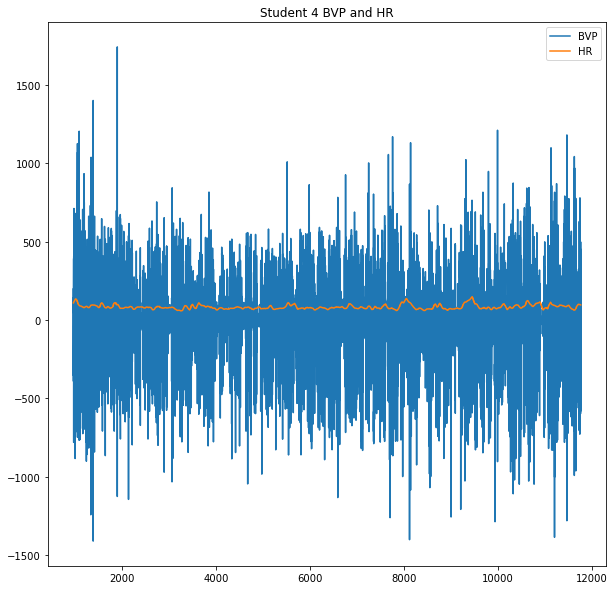

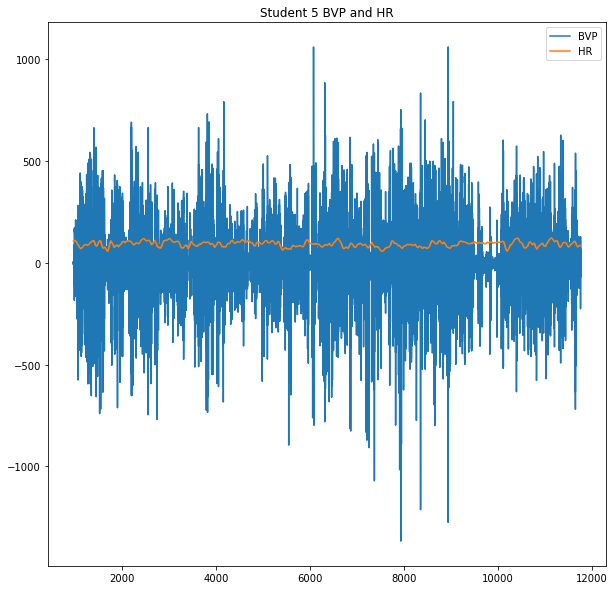

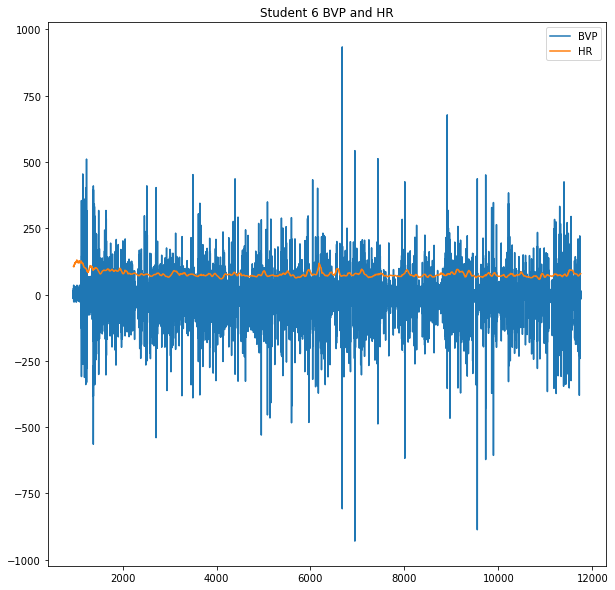

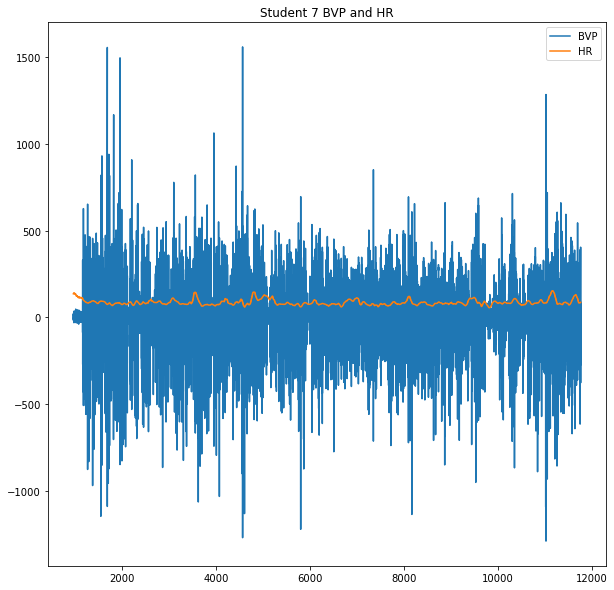

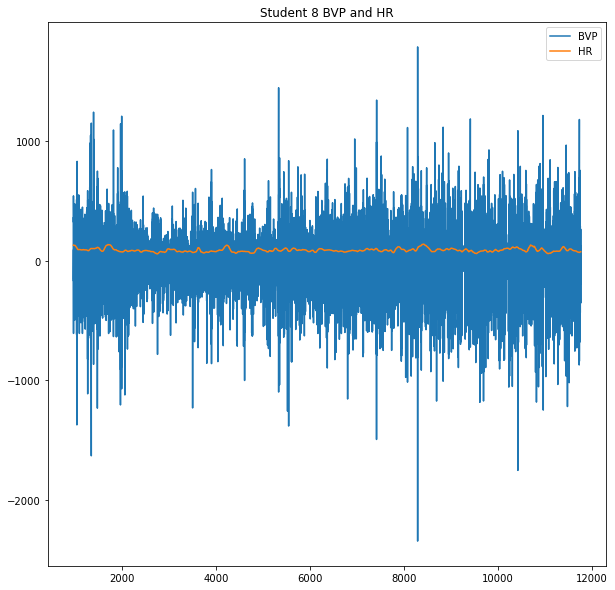

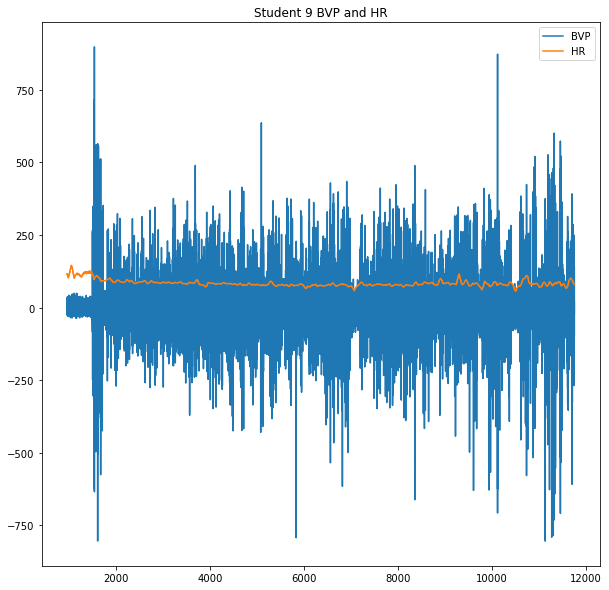

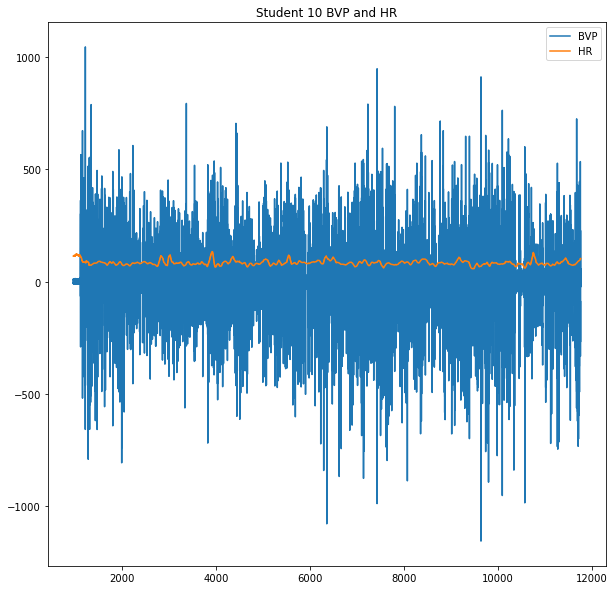

In [85]:
for stud in range(10):
    data = np.loadtxt('exam_S'+str(stud)+'_F.csv', delimiter=',', skiprows=1)
    time = data[:,0]
    BVP = data[:,1]
    HR = data[:,3]

    fig, ax = plt.subplots(figsize=(10,10))

    ax.plot(time, BVP, label='BVP')
    ax.plot(time, HR, label='HR')
    plt.title('Student '+str(stud+1)+' BVP and HR')
    plt.legend()

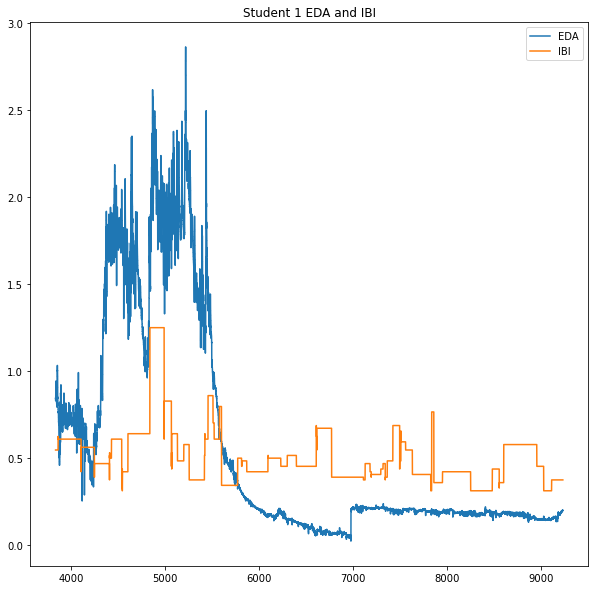

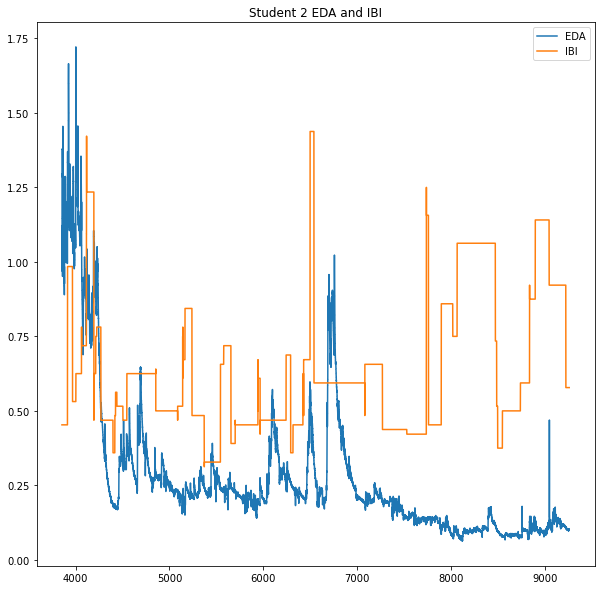

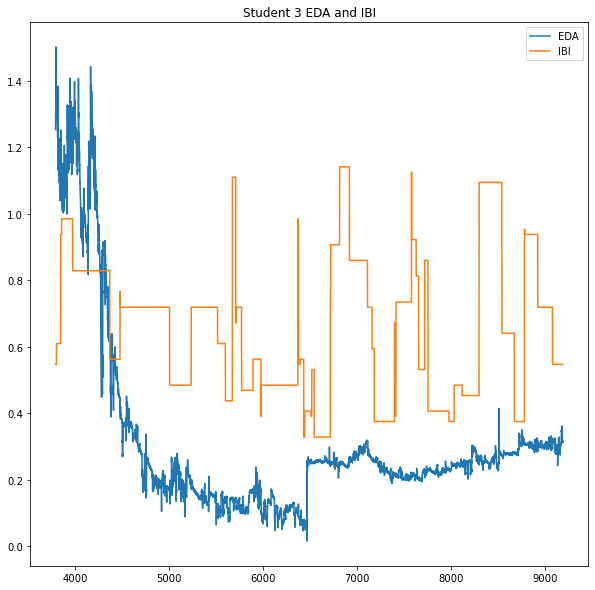

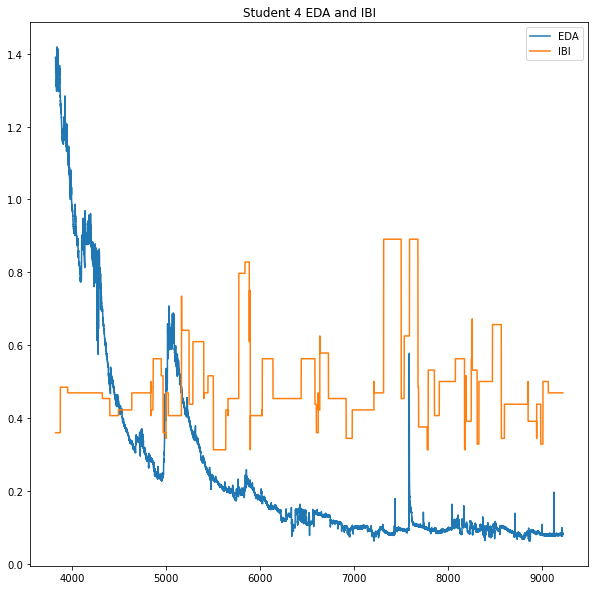

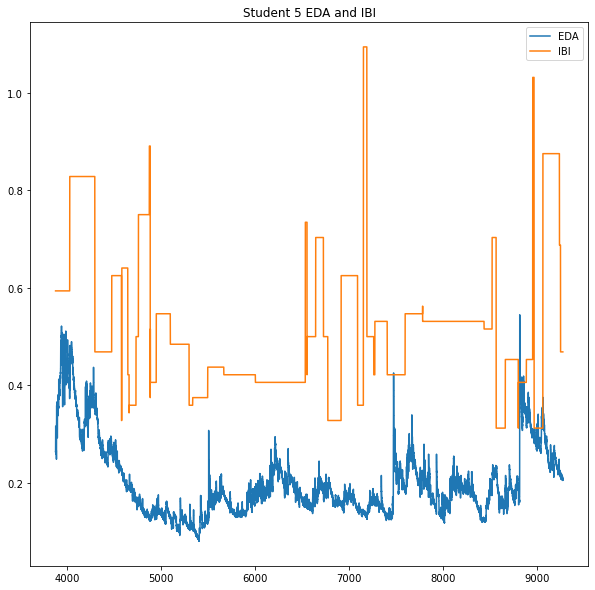

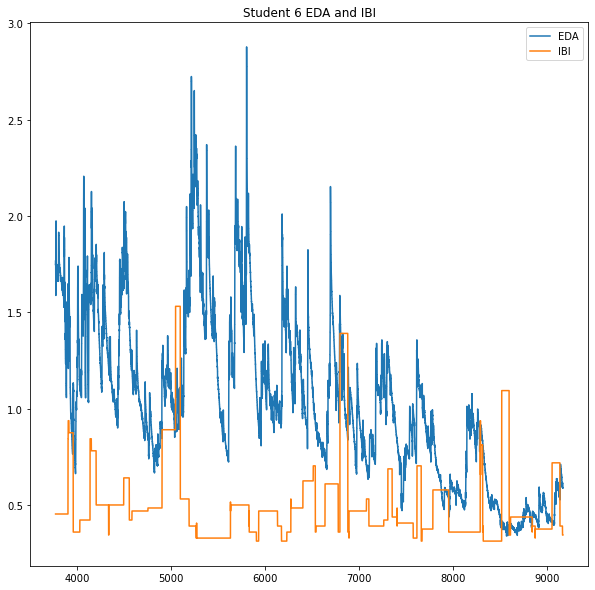

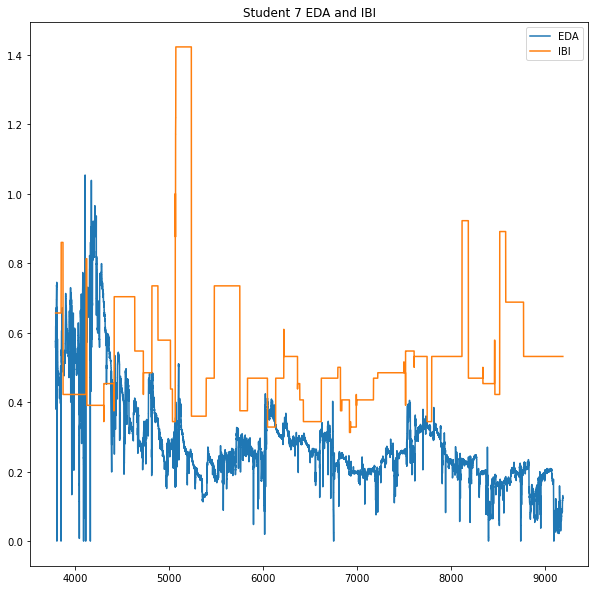

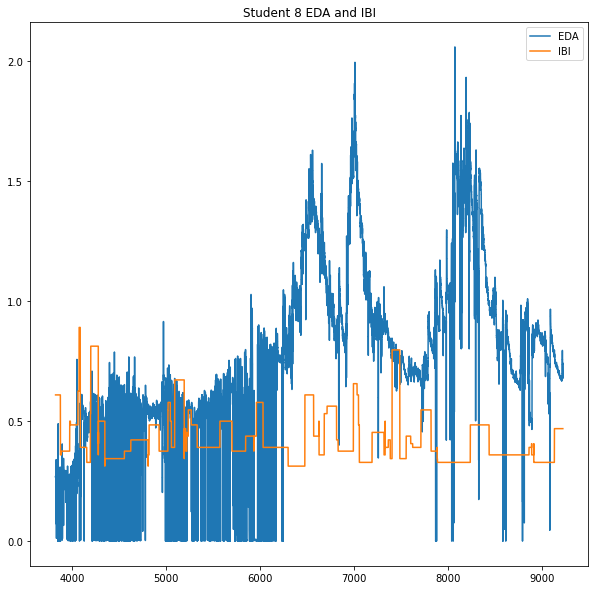

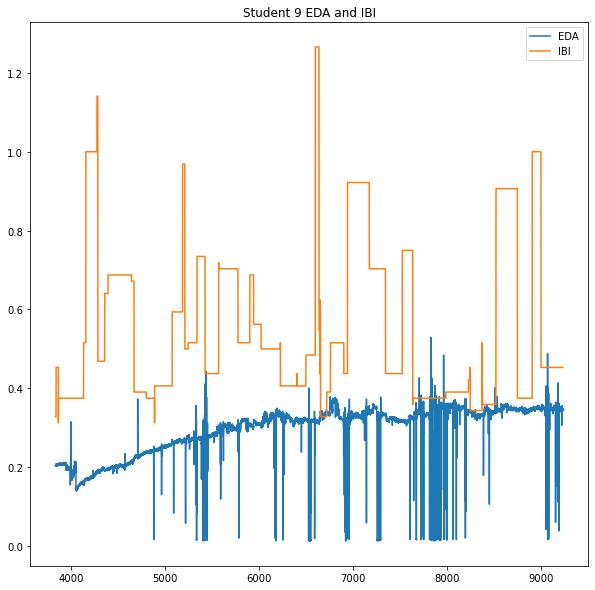

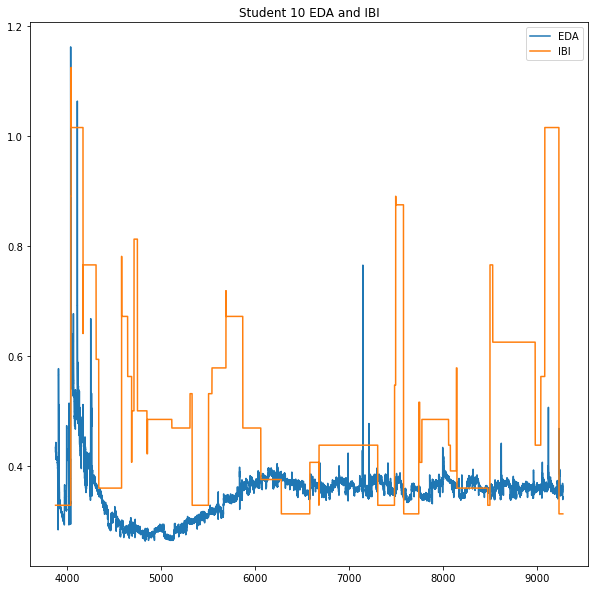

In [86]:
import numpy as np
import matplotlib.pyplot as plt

for stud in range(10):
    data = np.loadtxt('exam_S'+str(stud)+'_M1.csv', delimiter=',', skiprows=1) #+str(stud)+
    time = data[:,0]
    EDA = data[:,2] 
    IBI = data[:,5]

    fig, ax = plt.subplots(figsize=(10,10))

    ax.plot(time, EDA, label='EDA')
    ax.plot(time, IBI, label='IBI')
    plt.title('Student '+str(stud+1)+' EDA and IBI') 
    plt.legend()

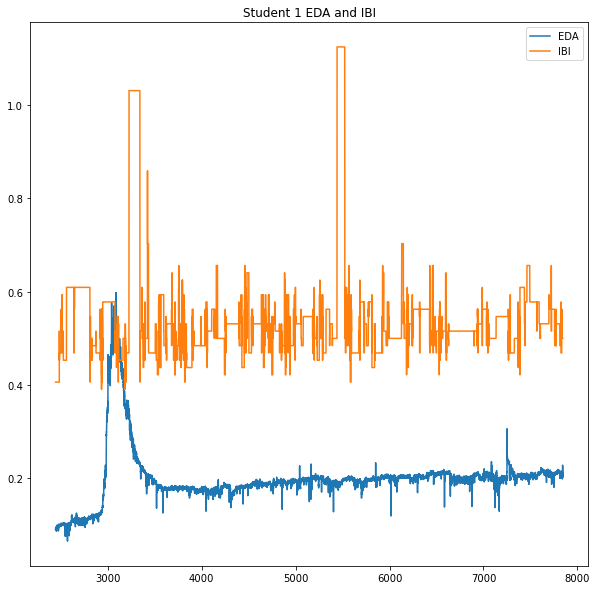

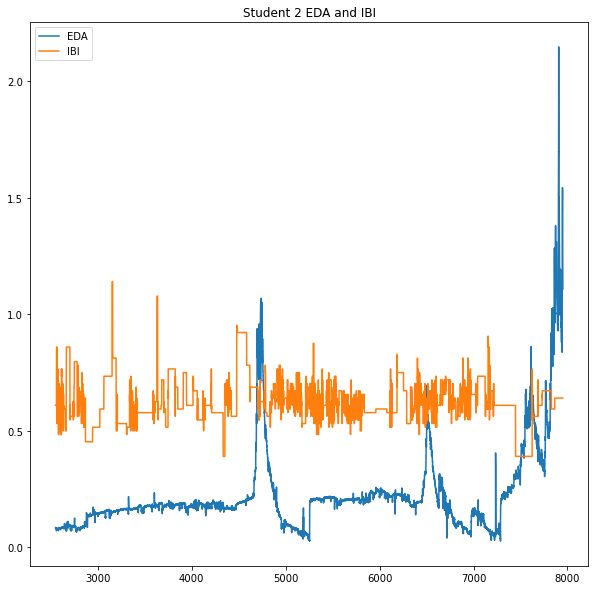

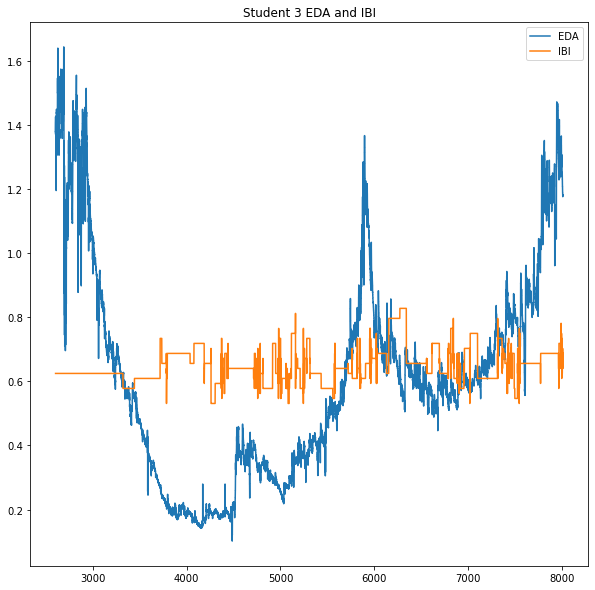

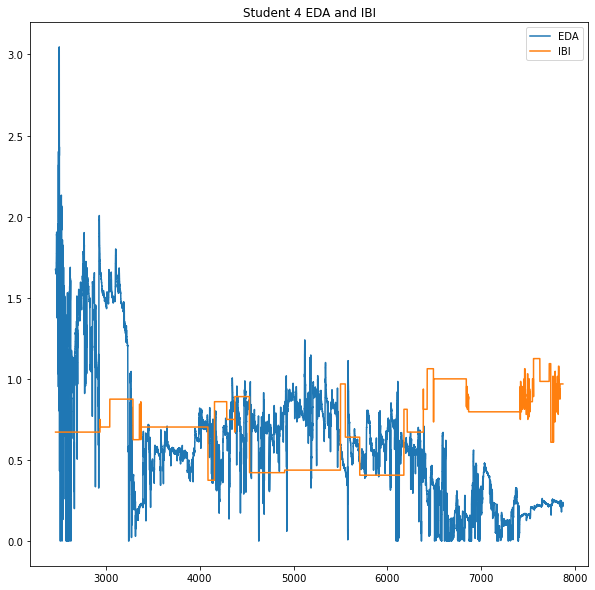

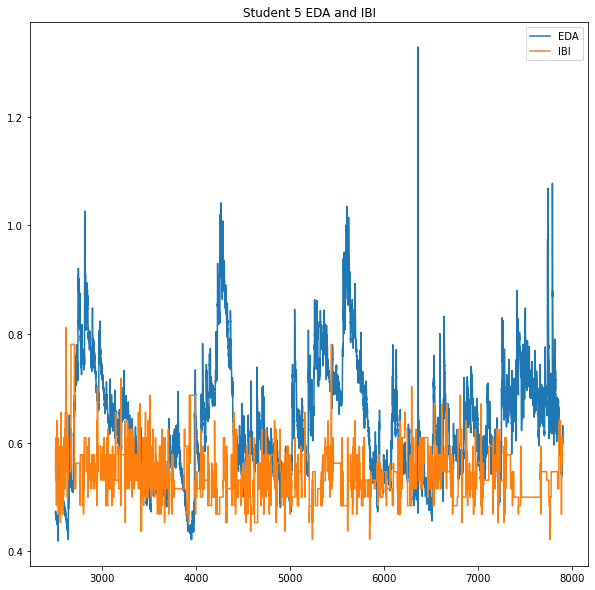

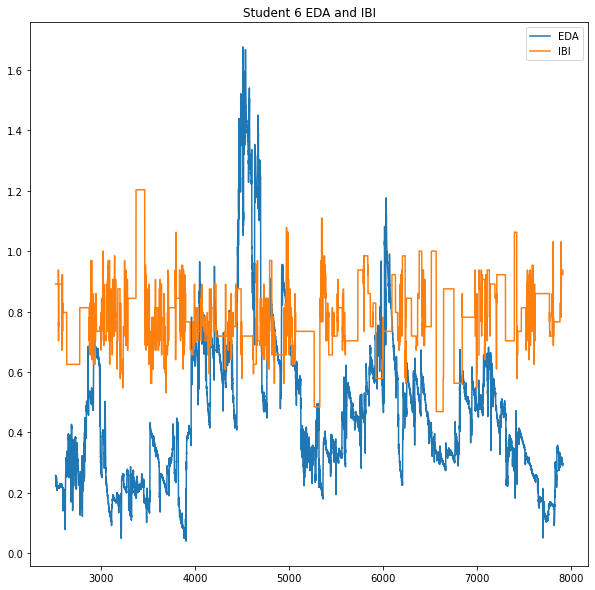

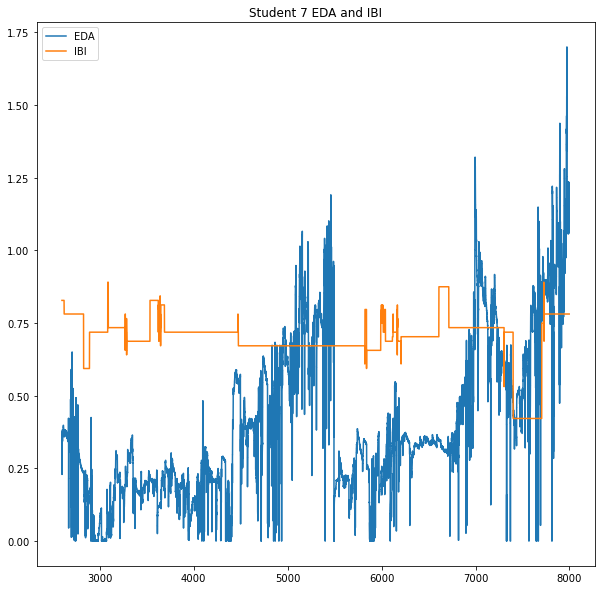

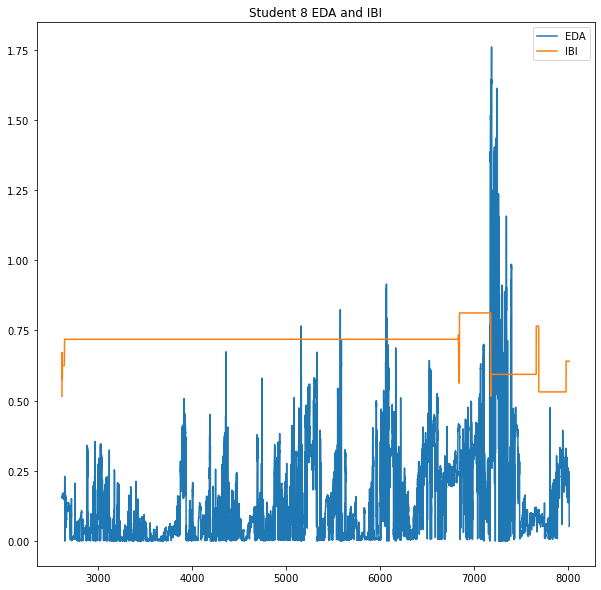

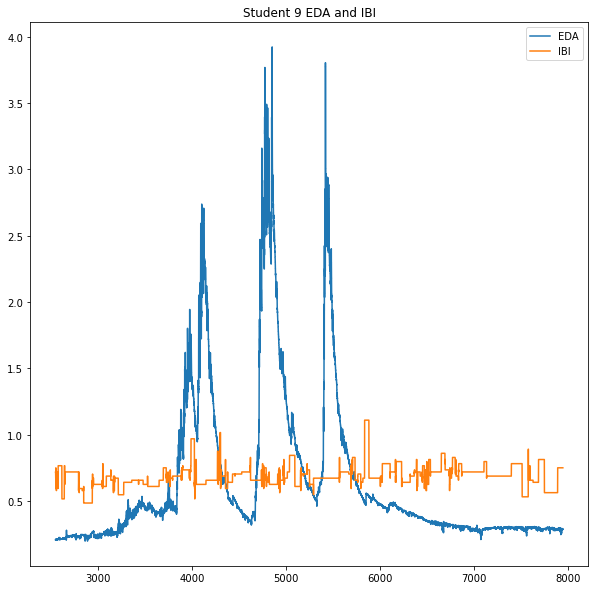

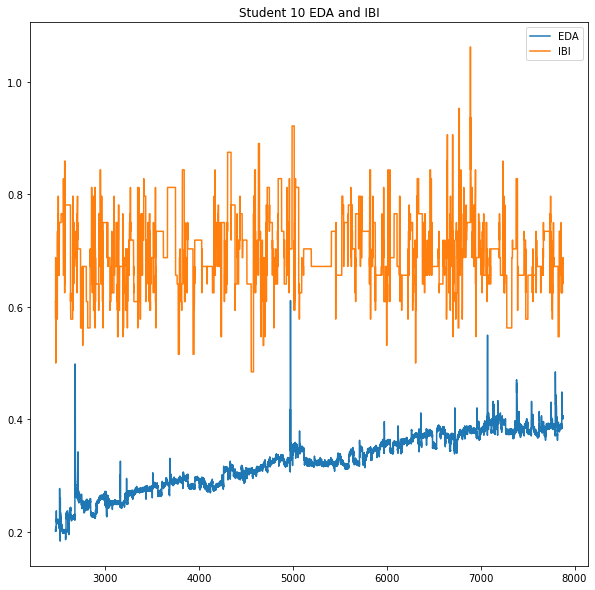

In [87]:
for stud in range(10):
    data = np.loadtxt('exam_S'+str(stud)+'_M2.csv', delimiter=',', skiprows=1)
    time = data[:,0]
    EDA = data[:,2] 
    IBI = data[:,5]

    fig, ax = plt.subplots(figsize=(10,10))

    ax.plot(time, EDA, label='EDA')
    ax.plot(time, IBI, label='IBI')
    plt.title('Student '+str(stud+1)+' EDA and IBI')
    plt.legend()

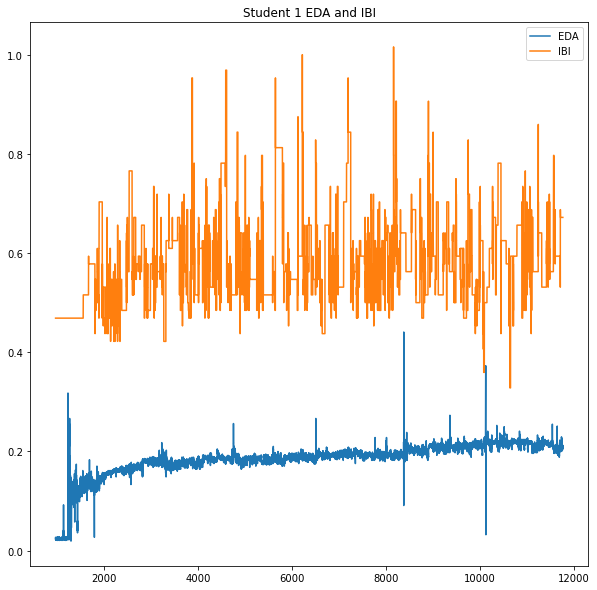

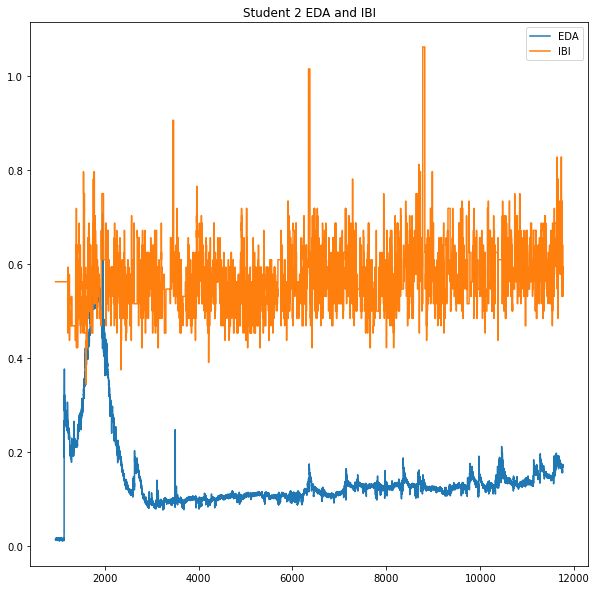

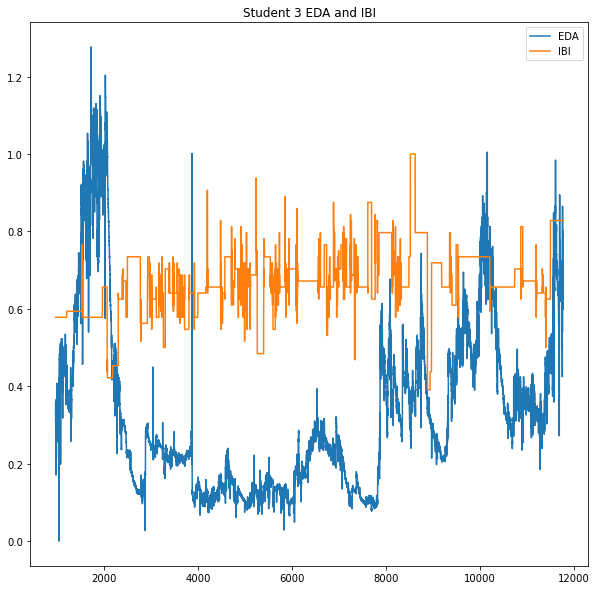

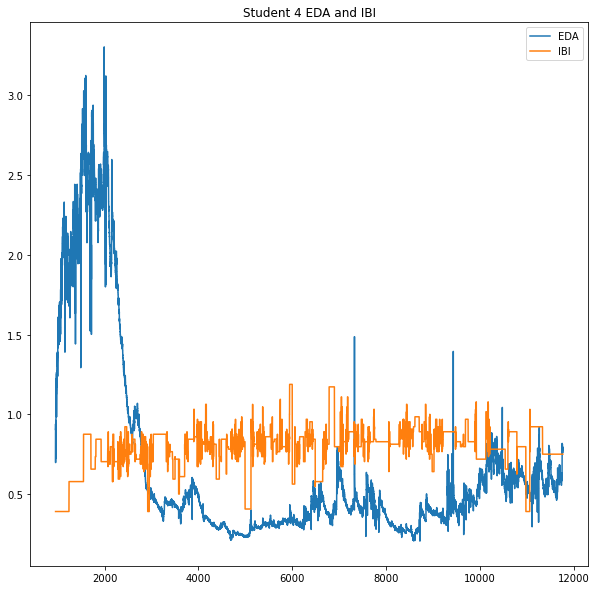

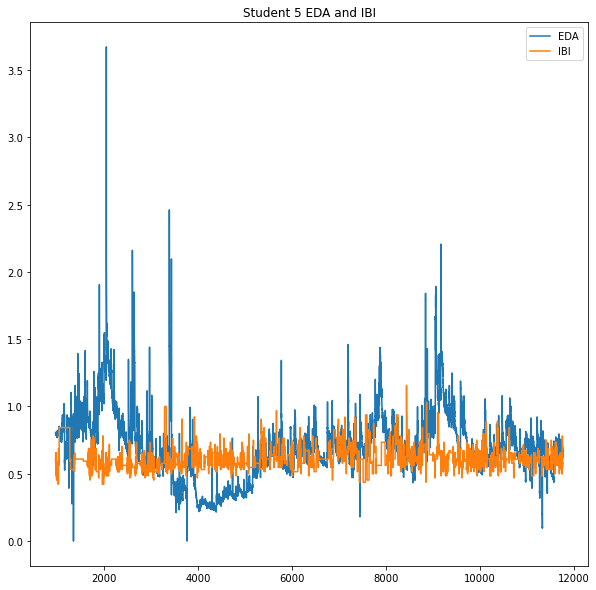

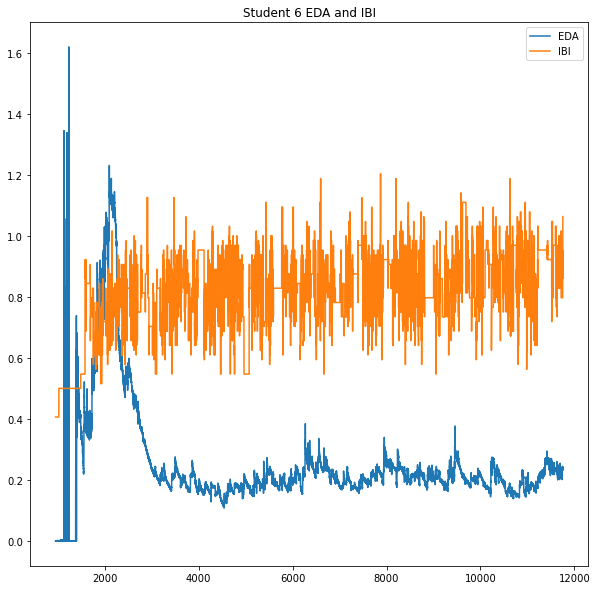

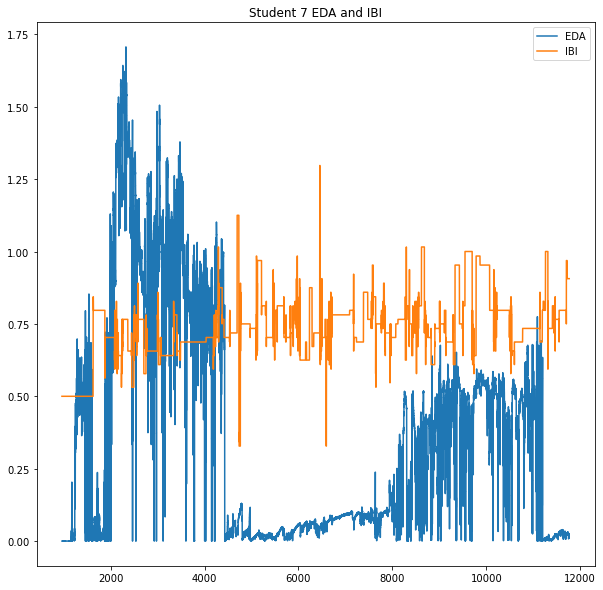

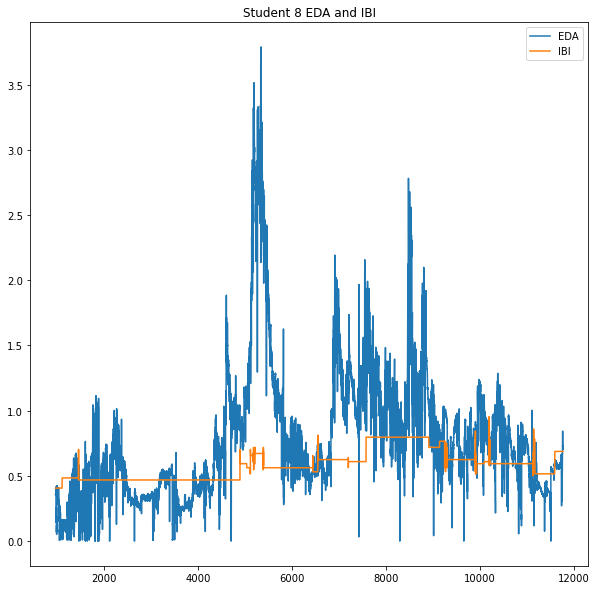

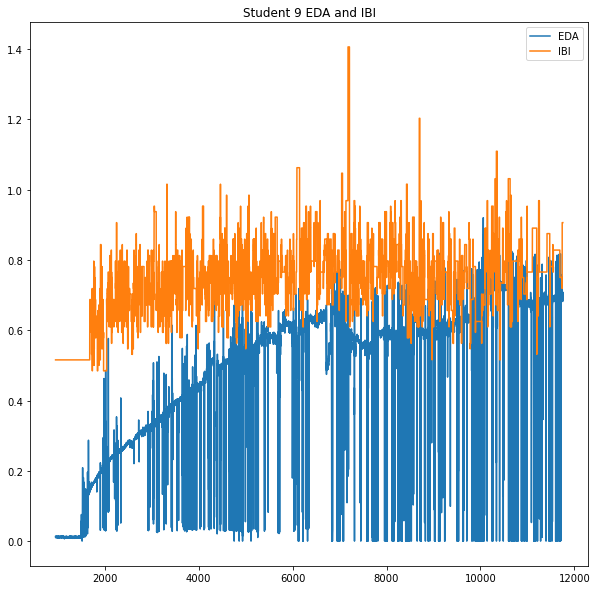

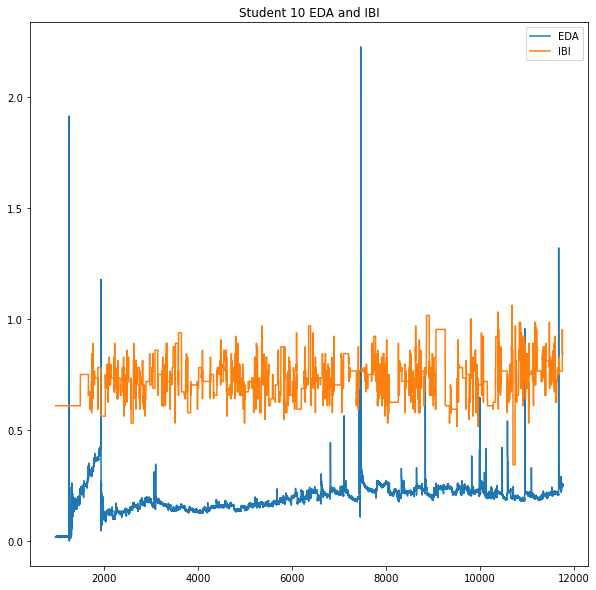

In [88]:
for stud in range(10):
    data = np.loadtxt('exam_S'+str(stud)+'_F.csv', delimiter=',', skiprows=1)
    time = data[:,0]
    EDA = data[:,2] 
    IBI = data[:,5]

    fig, ax = plt.subplots(figsize=(10,10))

    ax.plot(time, EDA, label='EDA')
    ax.plot(time, IBI, label='IBI')
    plt.title('Student '+str(stud+1)+' EDA and IBI')
    plt.legend()

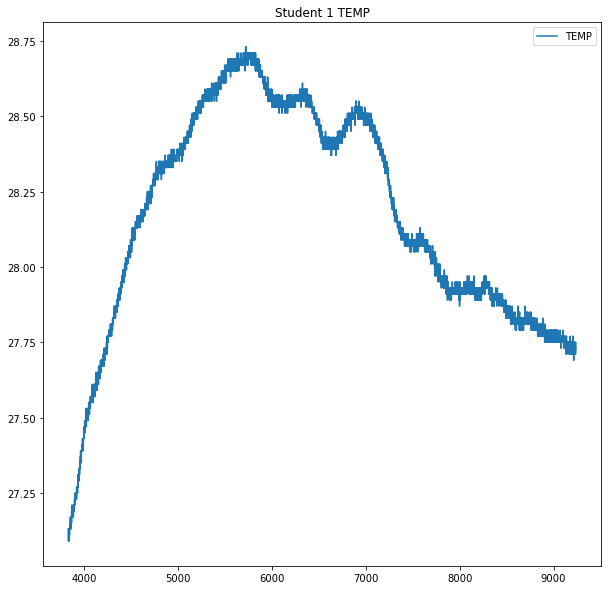

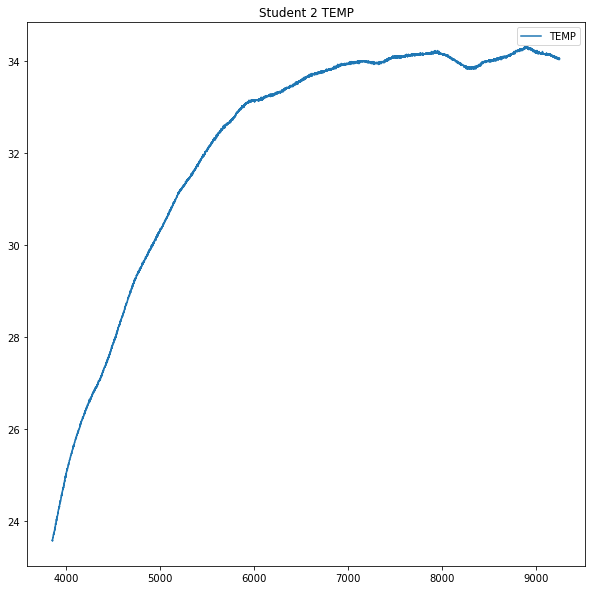

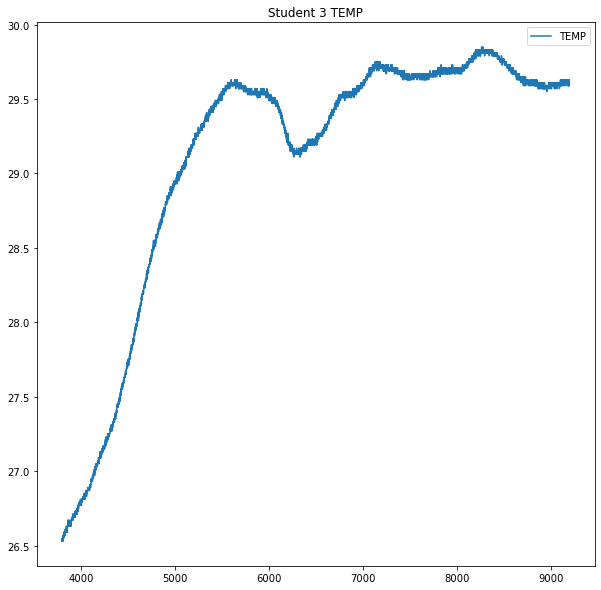

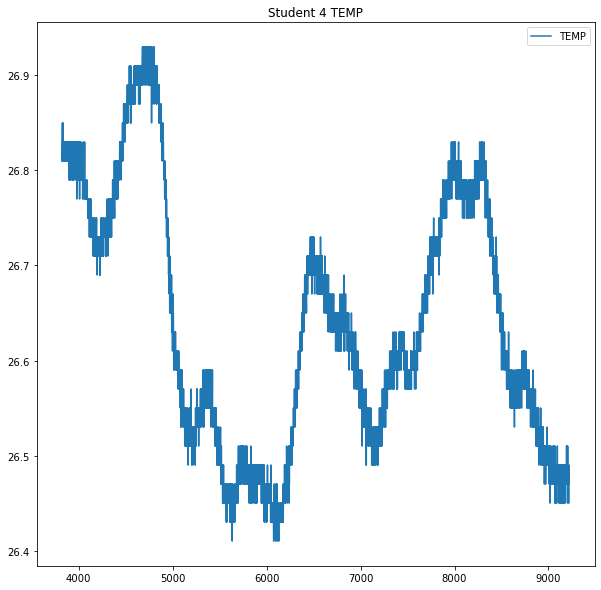

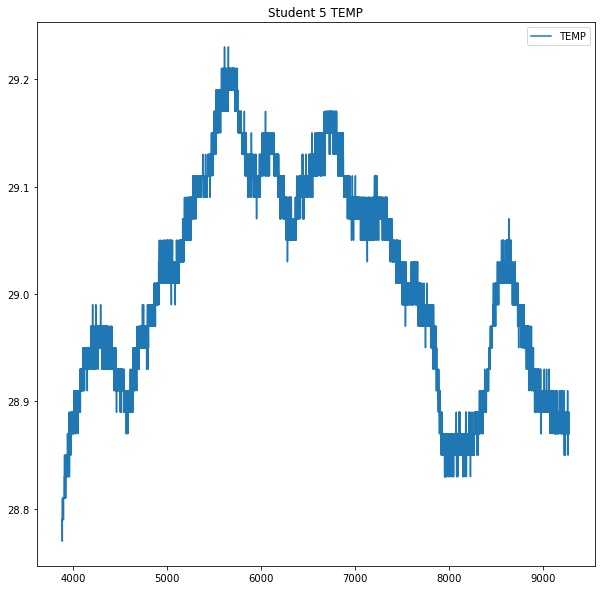

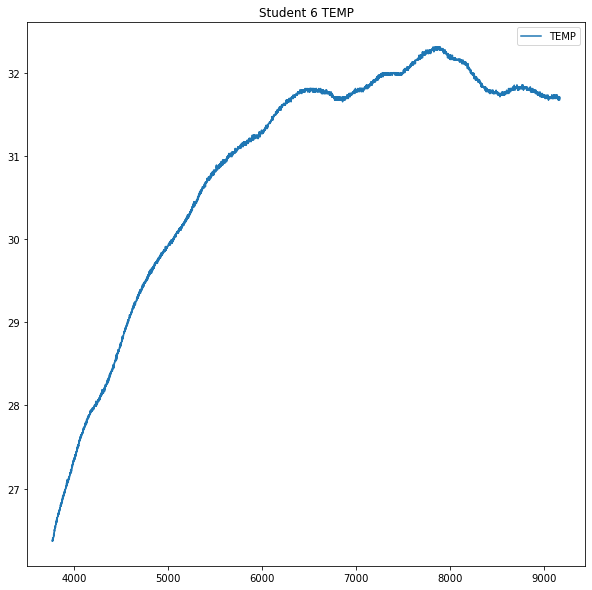

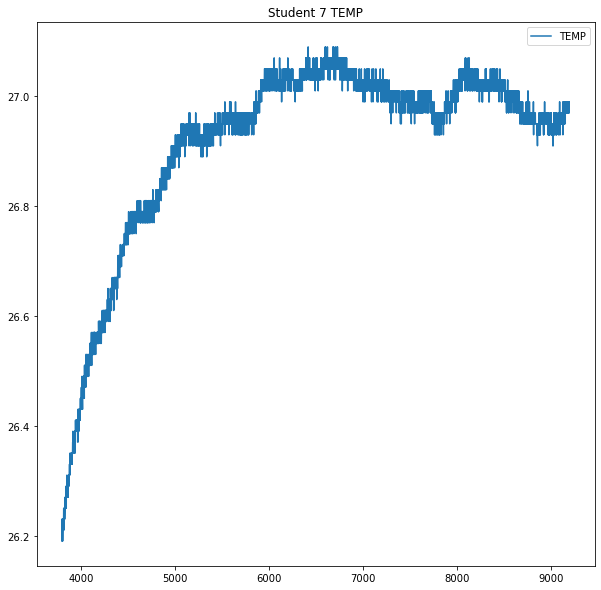

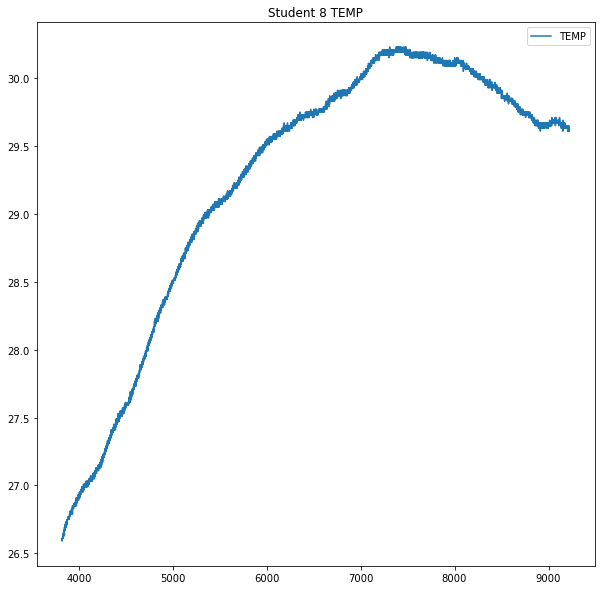

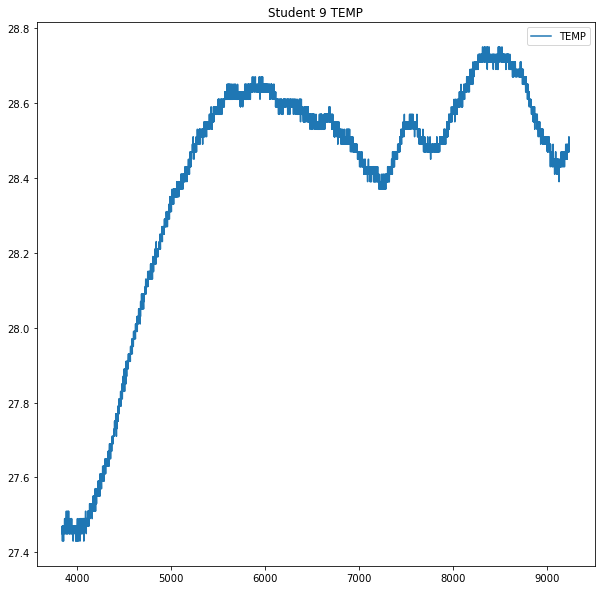

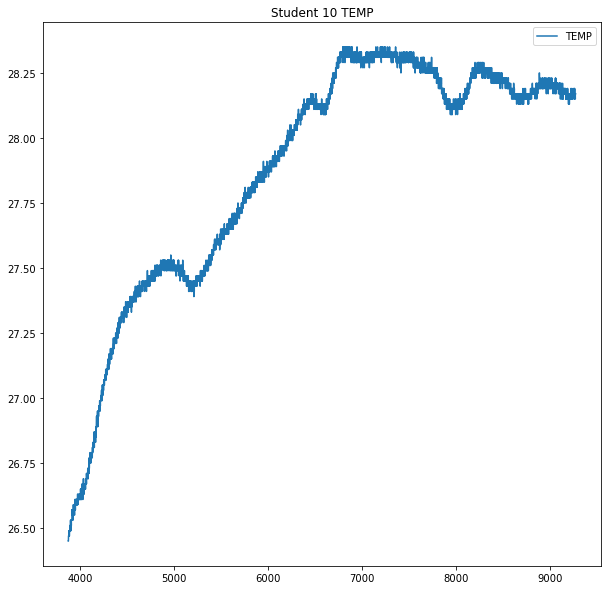

In [89]:
import numpy as np
import matplotlib.pyplot as plt

for stud in range(10):
    data = np.loadtxt('exam_S'+str(stud)+'_M1.csv', delimiter=',', skiprows=1)
    time = data[:,0]
    TEMP = data[:,4] 

    fig, ax = plt.subplots(figsize=(10,10))

    ax.plot(time, TEMP, label='TEMP')
    plt.title('Student '+str(stud+1)+' TEMP')
    plt.legend()

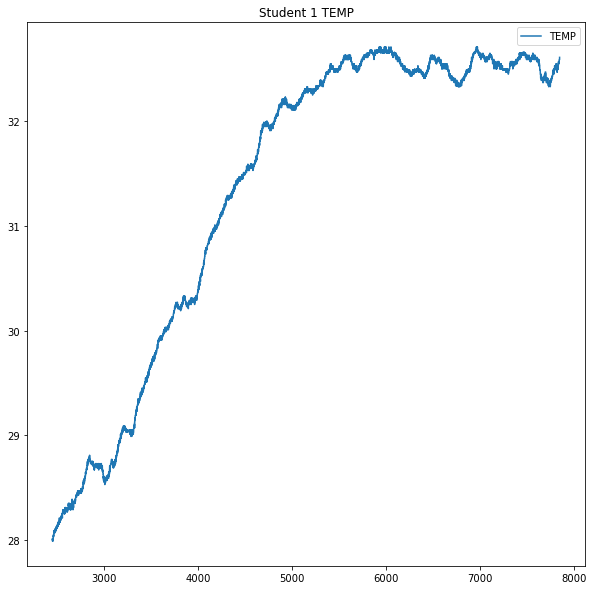

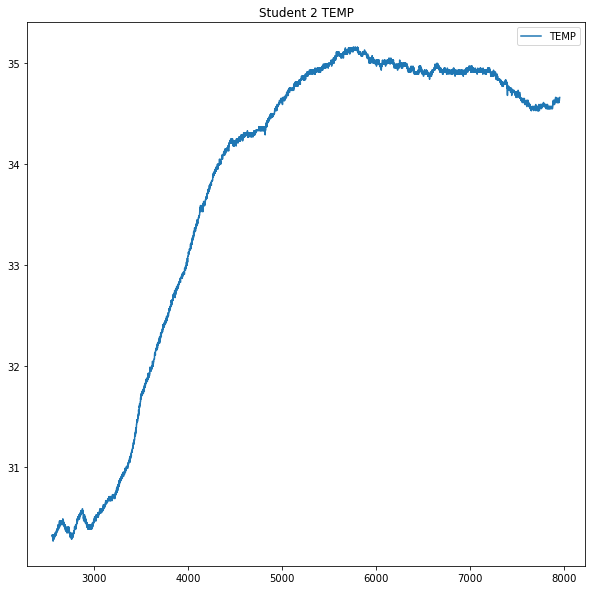

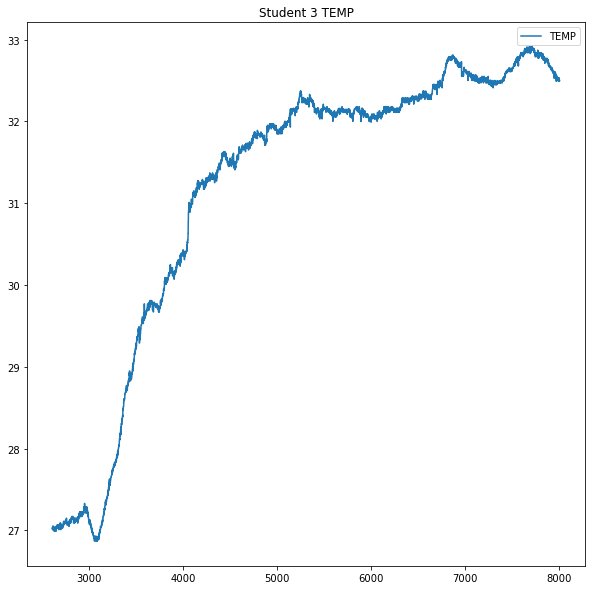

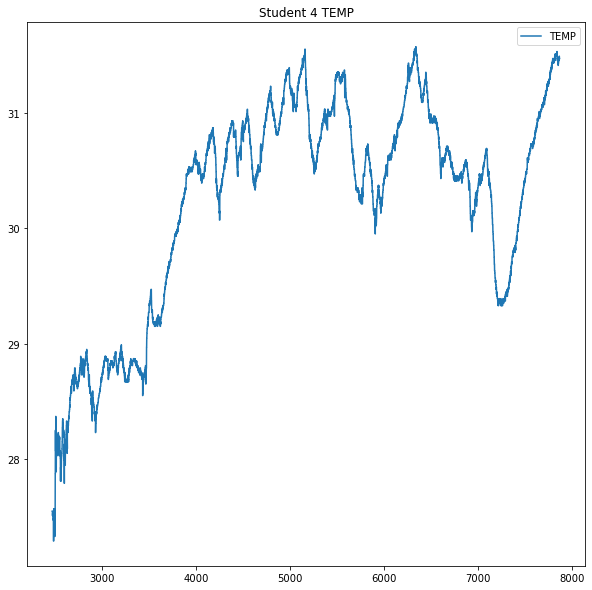

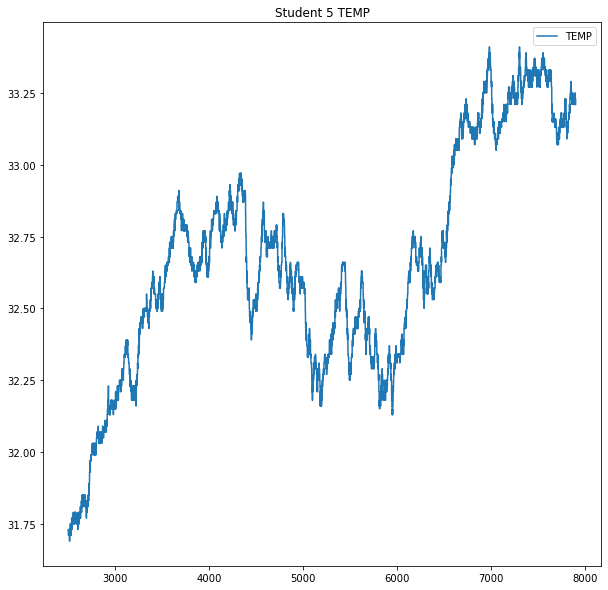

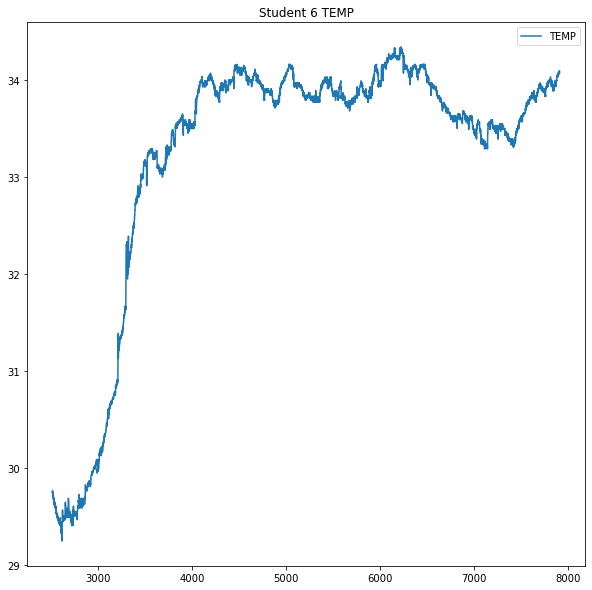

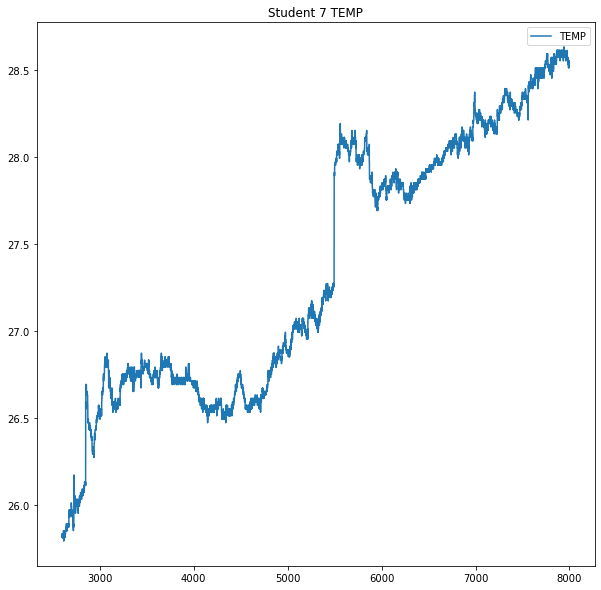

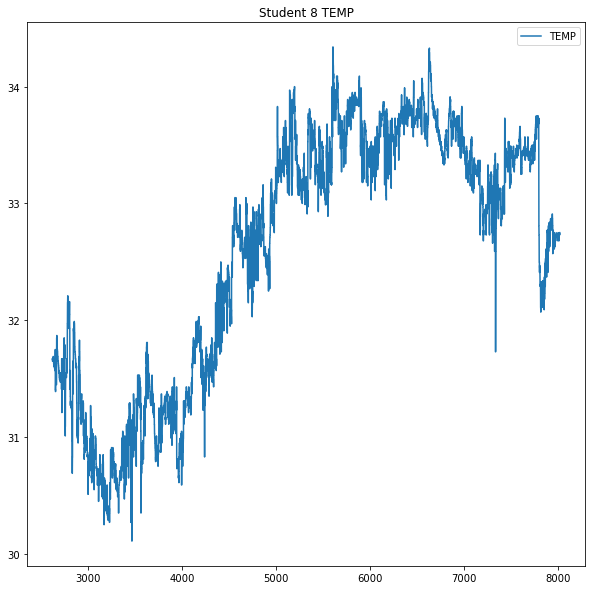

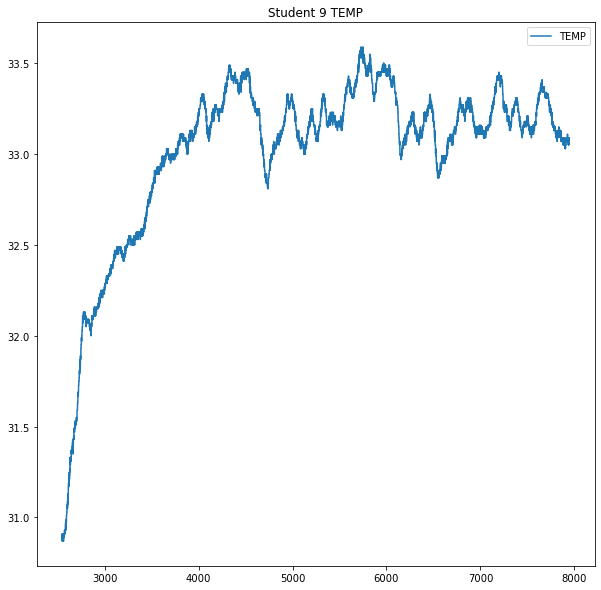

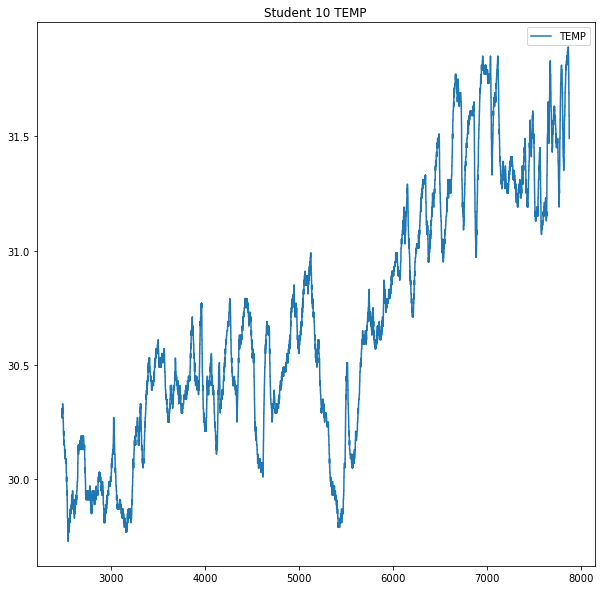

In [90]:
for stud in range(10):
    data = np.loadtxt('exam_S'+str(stud)+'_M2.csv', delimiter=',', skiprows=1)
    time = data[:,0]
    TEMP = data[:,4] 

    fig, ax = plt.subplots(figsize=(10,10))

    ax.plot(time, TEMP, label='TEMP')
    plt.title('Student '+str(stud+1)+' TEMP')
    plt.legend()

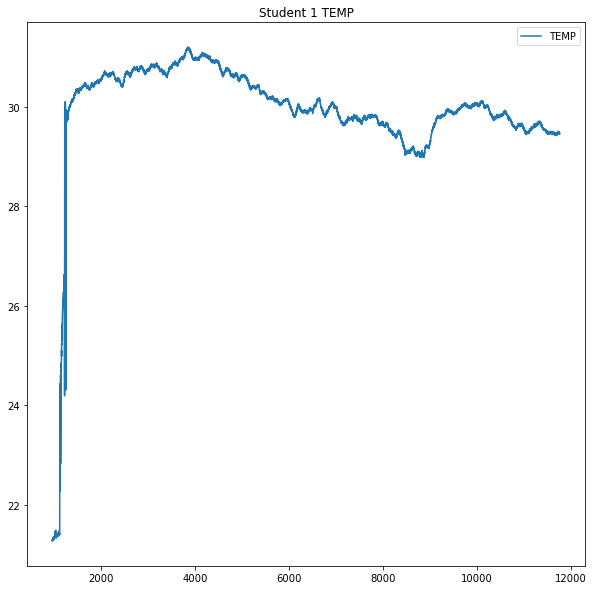

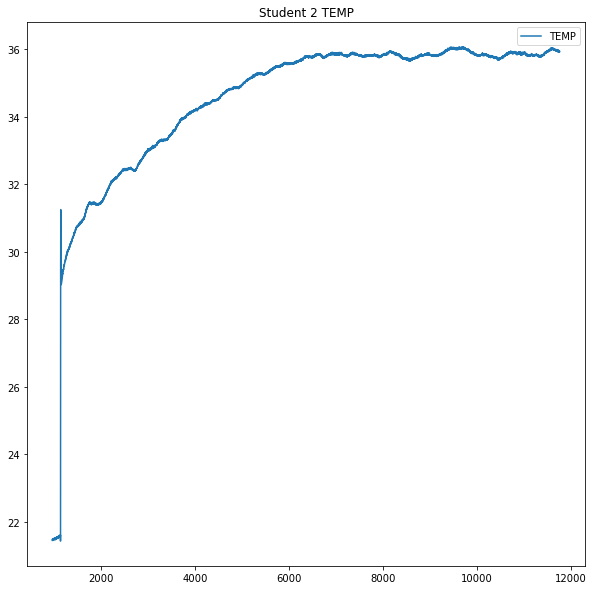

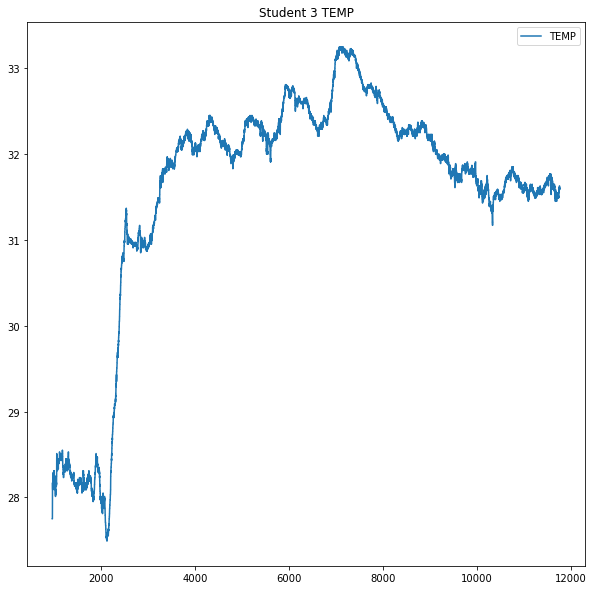

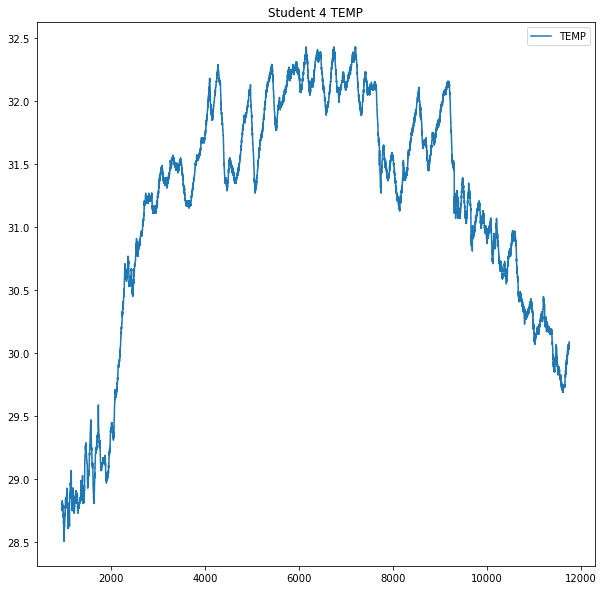

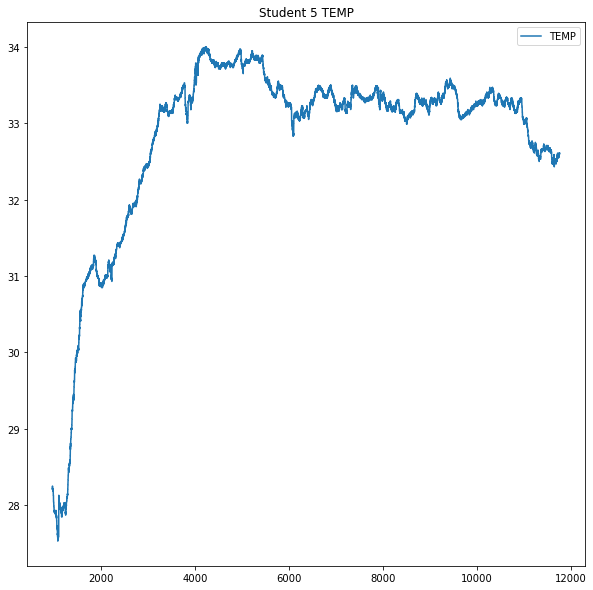

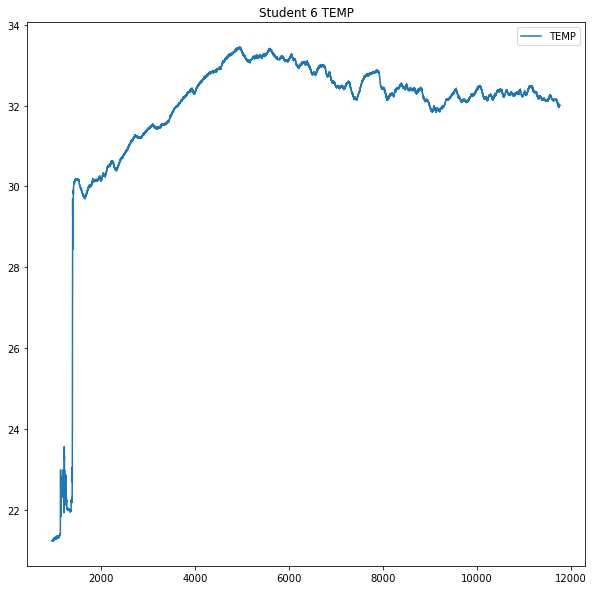

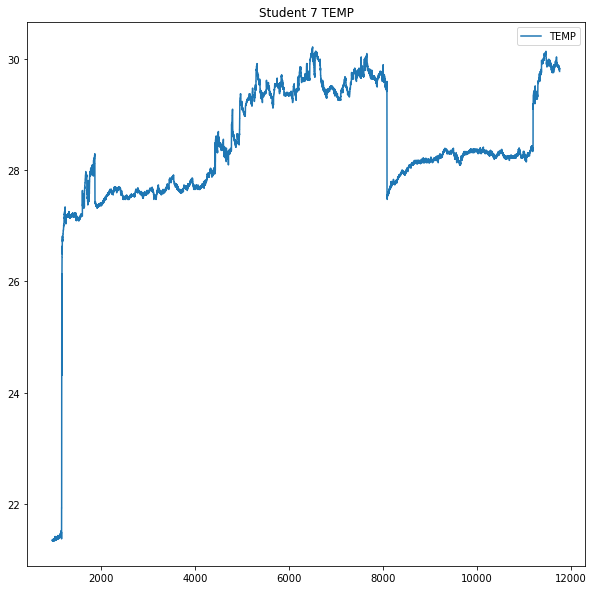

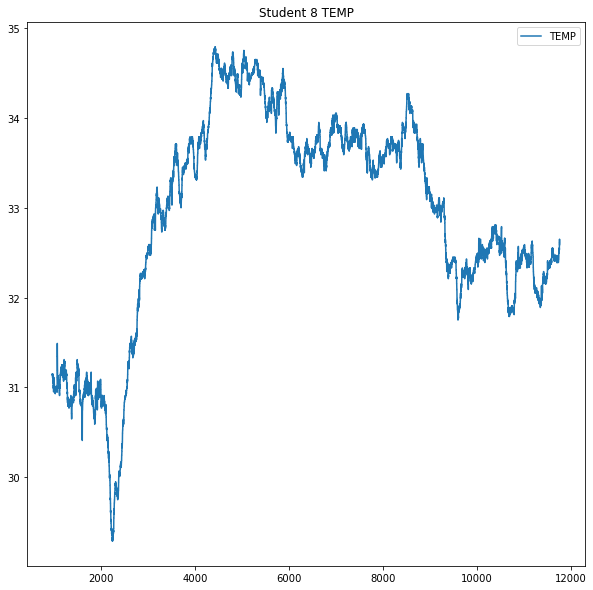

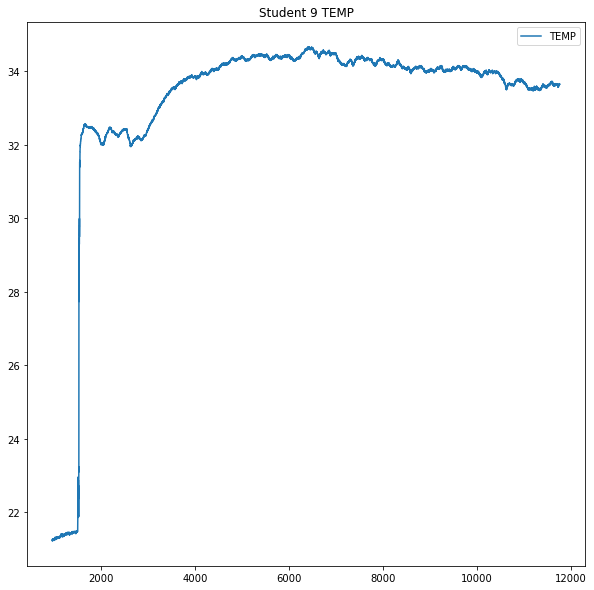

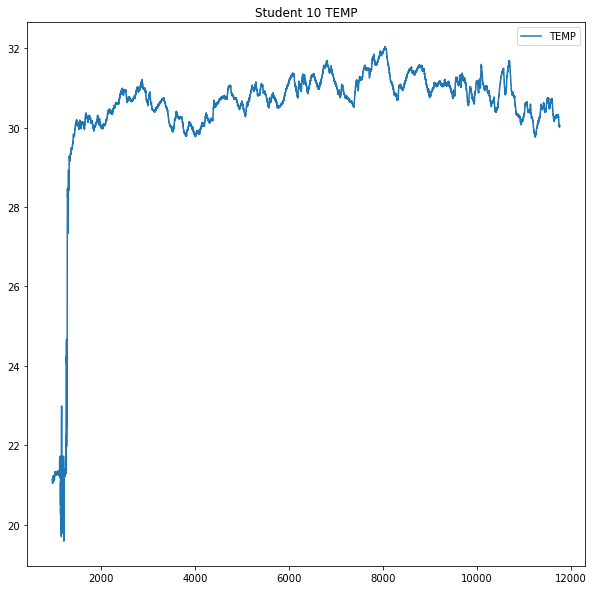

In [91]:
for stud in range(10):
    data = np.loadtxt('exam_S'+str(stud)+'_F.csv', delimiter=',', skiprows=1)
    time = data[:,0]
    TEMP = data[:,4] 

    fig, ax = plt.subplots(figsize=(10,10))

    ax.plot(time, TEMP, label='TEMP')
    plt.title('Student '+str(stud+1)+' TEMP')
    plt.legend()

In [92]:
M1_HR_long_bf=[]
M1_HR_long_ex=[]
M1_HR_long_af=[]
M1_HR_frl = []
M1_HR_varl_ex = []
for i in range(10):
    M1_HR_frl.append(M1_HR_fr[i]*64)
for i in range(10):
    t0 = 0
    t1 = unix_M1-M1_HR_time[i]
    M1_HR_long_bf, M1_HR_stdl_bf, M1_HR_varl_bf = aver_data(M1_HR_long,M1_HR_frl,t0,t1) # HR before M1 exam
    t2 = t1 + 5400
    M1_HR_long_ex, M1_HR_stdl_ex, M1_HR_varl_ex = aver_data(M1_HR_long,M1_HR_frl,t1,t2) # HR during M1 exam
    t3 = int(len(M1_HR[i]))
    M1_HR_long_af, M1_HR_stdl_af, M1_HR_varl_ex = aver_data(M1_HR_long,M1_HR_frl,t2,t3) # HR after M1 exam
for i in range(10):
    M1_HR_varl_ex.append(M1_HR_stdl_ex[i]**2)
print('Heart rate smooth BEFORE ',EX,' exam \n', M1_HR_smo_bf, np.mean(M1_HR_smo_bf))
print('Heart rate smooth std BEFORE ',EX,' exam \n', M1_HR_stds_bf, np.mean(M1_HR_stds_bf))
print()
print('Heart rate BEFORE ',EX,' exam \n', M1_HR_mean_bf, np.mean(M1_HR_mean_bf))
print('Heart rate std BEFORE ',EX,' exam \n', M1_HR_std_bf, np.mean(M1_HR_std_bf))
print()
print('Heart rate long BEFORE ',EX,' exam \n', M1_HR_long_bf, np.mean(M1_HR_long_bf))
print('Heart rate long std BEFORE ',EX,' exam \n', M1_HR_stdl_bf, np.mean(M1_HR_stdl_bf))
print()
print('Heart rate smooth DURING ',EX,' exam \n', M1_HR_smo_ex, np.mean(M1_HR_smo_ex))
print('Heart rate smooth std DURING ',EX,' exam \n', M1_HR_stds_ex, np.mean(M1_HR_stds_ex))
print()
print('Heart rate DURING ',EX,' exam \n', M1_HR_mean_ex, np.mean(M1_HR_mean_ex))
print('Heart rate std DURING ',EX,' exam \n', M1_HR_std_ex, np.mean(M1_HR_std_ex))
print()
print('Heart rate long DURING ',EX,' exam \n', M1_HR_long_ex, np.mean(M1_HR_long_ex))
print('Heart rate long var DURING ',EX,' exam \n', M1_HR_varl_ex, np.mean(M1_HR_varl_ex))
print()
print('Heart rate AFTER ',EX,' exam \n', M1_HR_smo_af, np.mean(M1_HR_smo_af))
print('Heart rate std AFTER ',EX,' exam \n', M1_HR_stds_af, np.mean(M1_HR_stds_af))

Heart rate smooth BEFORE  FINAL/  exam 
 [124.14326041666665, 141.91738281250002, 117.55420833333332, 131.0045390625, 128.67876562499998, 125.29771614583333, 128.39256770833333, 133.567984375, 124.8774765625, 130.49510677083333] 128.59290078125
Heart rate smooth std BEFORE  FINAL/  exam 
 [26.241657264430394, 29.145447960639203, 29.82206915965996, 27.532687417238403, 29.422451113012084, 20.06458243586095, 26.492161959278928, 26.6385366336108, 22.597487617016853, 24.027556857356963] 26.19846384181045

Heart rate BEFORE  FINAL/  exam 
 [123.79797930142301, 141.58795601552393, 117.34501681759379, 130.69219922380336, 128.37610866752908, 125.10043984476066, 128.28904527813714, 133.3928486416559, 124.50694178525227, 130.1360698576973] 128.32246054333763
Heart rate std BEFORE  FINAL/  exam 
 [28.33082122139217, 31.91733325376198, 31.04596315228048, 30.52754884570547, 31.368519109432807, 22.974491370350936, 28.47040563086149, 28.24970730153903, 25.192955297030228, 26.68286802528222] 28.4760613